# Technical Analysis Indicator Price Prediction
The goal of this project is to analyze the predictive power of the top 10 most popular TA indicators and see how well they do to predict price over a 30 day period. I am going to find the value of the indicators on day 1 (30 trading days ago) and then find the daily closing price for 30 days later and measure how well the indicator predicted the price.  

first we'll find the top 500 stocks by market cap from nasdaq and pull them into a dataframe


In [84]:
# Warning Supression
import warnings
from pandas.errors import PerformanceWarning 

warnings.filterwarnings('ignore')

warnings.filterwarnings('ignore', category=PerformanceWarning)


In [ ]:
# Importing pandas library for data manipulation and analysis
import pandas as pd

# Load the CSV file into a DataFrame
csv_file_path = '/Users/evancallaghan/Downloads/nasdaq_screener_1726538993372.csv' 
df = pd.read_csv(csv_file_path)

# Inspect the DataFrame to understand its structure
print(df.head())

# Filter DataFrame to only show the columns 'Symbol', 'Name', and 'Market Cap'
df = df[['Symbol', 'Name', 'Market Cap']]

# Convert 'Market Cap' to numeric if it's not already
# Remove commas, dollar signs, and replace these symbols with empty spaces
df['Market Cap'] = df['Market Cap'].replace({'\$': '', ',': ''}, regex=True).astype(float)

# Sort the DataFrame by Market Cap in descending order
df_sorted = df.sort_values(by='Market Cap', ascending=False).head(1000)                                                                        
df_sorted.head()


In [ ]:
# Reset the index of the DataFrame and drop the old index
df_sorted.reset_index(drop=True, inplace=True)

# Update the index to start from 1 instead of 0
df_sorted.index = df_sorted.index + 1

# Display the first few rows of the updated DataFrame
df_sorted.head()

remove all stocks except common stocks

In [ ]:
# Ensure there are no leading or trailing whitespaces in the 'Name' column
df_sorted['Name'] = df_sorted['Name'].str.strip()

# List of terms to filter out
terms_to_drop = ["Capital Stock", "Depository Shares", "Global Notes", "ADS", 
                 "Registry Shares", "Depositary Shares"
]

# Create a regex pattern to match any of the terms
# //b ensures that the match occues only at the start or end of a word
# pipe '|' ensures that if any of the terms in 'terms_to_drop' are seen, 
# there is a match
pattern = '|'.join([f"\\b{term}\\b" for term in terms_to_drop])

# Apply filtering based on the updated pattern
df_filtered = df_sorted[~df_sorted['Name'].str.contains(pattern, case=False, 
                                                        na=False)
]

# Display the filtered DataFrame
df_filtered.head()

In [ ]:
# Reset the index of the DataFrame and drop the old index
df_filtered.reset_index(drop=True, inplace=True)

# Update the index to start from 1 instead of 0
df_filtered.index = df_filtered.index + 1

# Display the first few rows of the updated DataFrame
df_filtered.head()

In [ ]:
df_filtered[595:600]

In [ ]:
df_filtered.shape

below are the 10 technical indicators we are going to use for this project.
1. Relative Strength Index (RSI)
2. Moving Average Convergence Divergence (MACD)
3. Stochastic Oscillator
4. Simple Moving Average (SMA)
5. Exponential Moving Average (EMA)
6. Volume Weighted Average Price (VWAP)
7. Bollinger Bands
8. Average True Range (ATR)
9. Fibonacci Retracement 

In [ ]:
# 10 year historical data top 600 stocks
# Pulls data from yahoo finance into CSV files
import yfinance as yf
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
import time
import os

# Function to download stock data for a single stock
def download_stock_data(ticker, retries=3):
    for attempt in range(retries):
        try:
            # Add a delay to avoid rate limiting
            time.sleep(1)  # Increase delay to 2 seconds between requests
            
            print(f"Downloading data for {ticker}, attempt {attempt + 1}")
            data = yf.download(ticker, start="2015-02-10", end="2025-02-17", interval="1d")[['Close', 'High', 'Low', 'Volume']]
            
            if data.empty:
                print(f"Warning: No data found for {ticker}")
                return None  # Return None if data is empty

            # Explicitly add 'Date' as a column before resetting the index
            data['Date'] = data.index

            # Reset the index and make 'Date' a normal column
            data.reset_index(drop=True, inplace=True)
            
            data['Ticker'] = ticker
            print(f"Downloaded data for {ticker}:\n{data.head()}")
            return data
        except Exception as e:
            print(f"Error downloading data for {ticker}: {e}")
            time.sleep(1)  # Longer delay before retrying in case of failure
    return None  # Return None after retries if still fails

# List of tickers from your df_filtered dataframe
tickers = df_filtered['Symbol'].head(600).astype(str).tolist()  # Ensure tickers are strings

# Batch size for processing tickers in smaller chunks
batch_size = 100  # Reduce batch size to avoid rate limits

# Directory to save CSV files
output_dir = "/Users/evancallaghan/flatiron_ds/phase_5/capstone_project"

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Create a function to download data for a batch of tickers in parallel
def download_batch(batch_tickers, batch_index):
    with ThreadPoolExecutor(max_workers=2) as executor:  # Use fewer threads to reduce load
        results = list(executor.map(lambda ticker: download_stock_data(ticker), batch_tickers))

    # Remove None values and ensure we have valid data
    valid_results = [(batch_tickers[i], results[i]) for i in range(len(batch_tickers)) if results[i] is not None]
    
    # Add ticker info to the valid results
    for ticker, df in valid_results:
        df['Ticker'] = ticker  # Explicitly add a column for ticker
    
    # Combine all the valid stock data into a single DataFrame
    if valid_results:
        df_batch = pd.concat([df for _, df in valid_results], ignore_index=False)  # Don't lose index info
        print(f"Saving batch {batch_index} data to CSV.")
        # Save the batch to a CSV file
        df_batch.to_csv(f"{output_dir}/top600_10yr_stock_price_data_{batch_index}.csv", index=False)
    else:
        print(f"No data downloaded for batch {batch_index}.")

# Split tickers into batches
for i in range(0, len(tickers), batch_size):
    batch_tickers = tickers[i:i + batch_size]
    batch_index = (i // batch_size) + 1  # Batch index starts from 1
    download_batch(batch_tickers, batch_index)

print("All batches processed and saved.")


In [ ]:
# Not sure if we will use thiis

# 5 year historical data top 600 stocks
# Pulls data from yahoo finance into CSV files
import yfinance as yf
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
import time
import os

# Function to download stock data for a single stock
def download_stock_data(ticker, retries=3):
    for attempt in range(retries):
        try:
            # Add a delay to avoid rate limiting
            time.sleep(1)  # Increase delay to 2 seconds between requests
            
            print(f"Downloading data for {ticker}, attempt {attempt + 1}")
            data = yf.download(ticker, start="2020-02-10", end="2025-02-17", interval="1d")[['Close', 'High', 'Low', 'Volume']]
            
            if data.empty:
                print(f"Warning: No data found for {ticker}")
                return None  # Return None if data is empty

            # Explicitly add 'Date' as a column before resetting the index
            data['Date'] = data.index

            # Reset the index and make 'Date' a normal column
            data.reset_index(drop=True, inplace=True)
            
            data['Ticker'] = ticker
            print(f"Downloaded data for {ticker}:\n{data.head()}")
            return data
        except Exception as e:
            print(f"Error downloading data for {ticker}: {e}")
            time.sleep(1)  # Longer delay before retrying in case of failure
    return None  # Return None after retries if still fails

# List of tickers from your df_filtered dataframe
tickers = df_filtered['Symbol'].head(600).astype(str).tolist()  # Ensure tickers are strings

# Batch size for processing tickers in smaller chunks
batch_size = 100  # Reduce batch size to avoid rate limits

# Directory to save CSV files
output_dir = "/Users/evancallaghan/flatiron_ds/phase_5/capstone_project"

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Create a function to download data for a batch of tickers in parallel
def download_batch(batch_tickers, batch_index):
    with ThreadPoolExecutor(max_workers=2) as executor:  # Use fewer threads to reduce load
        results = list(executor.map(lambda ticker: download_stock_data(ticker), batch_tickers))

    # Remove None values and ensure we have valid data
    valid_results = [(batch_tickers[i], results[i]) for i in range(len(batch_tickers)) if results[i] is not None]
    
    # Add ticker info to the valid results
    for ticker, df in valid_results:
        df['Ticker'] = ticker  # Explicitly add a column for ticker
    
    # Combine all the valid stock data into a single DataFrame
    if valid_results:
        df_batch = pd.concat([df for _, df in valid_results], ignore_index=False)  # Don't lose index info
        print(f"Saving batch {batch_index} data to CSV.")
        # Save the batch to a CSV file
        df_batch.to_csv(f"{output_dir}/top600_5yr_stock_price_data_{batch_index}.csv", index=False)
    else:
        print(f"No data downloaded for batch {batch_index}.")

# Split tickers into batches
for i in range(0, len(tickers), batch_size):
    batch_tickers = tickers[i:i + batch_size]
    batch_index = (i // batch_size) + 1  # Batch index starts from 1
    download_batch(batch_tickers, batch_index)

print("All batches processed and saved.")


In [1]:
import pandas as pd

# Initialize an empty list to hold DataFrames
df_list = []

# List of specific file indices
file_indices = range(1, 7)

# Loop through the specific CSV file indices
for i in file_indices:
    # Construct the file path for each batch
    csv_file_path = f'/Users/evancallaghan/flatiron_ds/phase_5/capstone_project/top600_10yr_stock_price_data_{i}.csv'

    # Load the CSV file into a DataFrame
    df = pd.read_csv(csv_file_path)


    # Append the DataFrame to the list
    df_list.append(df)

# Concatenate all DataFrames in the list along the rows (axis=0)
df_all = pd.concat(df_list, ignore_index=True)

# Display the first few rows of the merged DataFrame
df_all.head()


,Close,High,Low,Volume,Date,Ticker
0,30.504999,30.537500,30.040001,248034000,2015-02-10,AAPL
1,31.219999,31.230000,30.625000,294247200,2015-02-11,AAPL
2,31.615000,31.870001,31.392500,297898000,2015-02-12,AAPL
3,31.770000,31.820000,31.412500,217088800,2015-02-13,AAPL
4,31.957500,32.220001,31.730000,252609600,2015-02-17,AAPL


In [2]:
df_all.shape

(1404503, 6)

In [3]:
df_all = df_all[['Ticker', 'Date', 'Close', 'High', 'Low', 'Volume']]
df_all = df_all.rename(columns={'Ticker': 'Symbol',
                               'High': 'Daily_High',
                               'Low': 'Daily_Low'})
df_all.head()

,Symbol,Date,Close,Daily_High,Daily_Low,Volume
0,AAPL,2015-02-10,30.504999,30.537500,30.040001,248034000
1,AAPL,2015-02-11,31.219999,31.230000,30.625000,294247200
2,AAPL,2015-02-12,31.615000,31.870001,31.392500,297898000
3,AAPL,2015-02-13,31.770000,31.820000,31.412500,217088800
4,AAPL,2015-02-17,31.957500,32.220001,31.730000,252609600


In [4]:
print(df_all['Date'].dtype)

object


In [5]:
df_all['Date'] = pd.to_datetime(df_all['Date'], errors='coerce')
print(df_all['Date'].dtype)

datetime64[ns]


In [6]:
df_all.shape

(1404503, 6)

In [7]:
top_stocks = df_all['Symbol'].unique().tolist()
df_all = df_all[df_all['Symbol'].isin(top_stocks[:200])]
df_all.head()

,Symbol,Date,Close,Daily_High,Daily_Low,Volume
0,AAPL,2015-02-10,30.504999,30.537500,30.040001,248034000
1,AAPL,2015-02-11,31.219999,31.230000,30.625000,294247200
2,AAPL,2015-02-12,31.615000,31.870001,31.392500,297898000
3,AAPL,2015-02-13,31.770000,31.820000,31.412500,217088800
4,AAPL,2015-02-17,31.957500,32.220001,31.730000,252609600


In [9]:
len(df_all['Symbol'].unique())

200

In [10]:
stock_data_1_week = df_all.copy()
stock_data_1_month = df_all.copy()
stock_data_3_month = df_all.copy()

In [80]:
# Windows for my TA indicator calculations

one_week_window = [3, 5, 7]
one_month_window = [7, 10, 14, 20, 30]
three_month_window = [14, 20, 30, 50, 60, 90]

# Window mapping for loops
window_mapping = {
    "stock_data_1_week": (stock_data_1_week, one_week_window),
    "stock_data_1_month": (stock_data_1_month, one_month_window),
    "stock_data_3_month": (stock_data_3_month, three_month_window)
}

# List of dataframes for loops
stock_dataframes = [stock_data_1_week, stock_data_1_month, stock_data_3_month]

In [15]:
# Daily Volume MA

for name, (df, windows) in window_mapping.items():
    for window in windows:
        df[f'Volume_{window}day_avg'] = df.groupby('Symbol')['Volume'].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean()
        )


In [17]:
# Daily High Price MA

for name, (df, windows) in window_mapping.items():
    for window in windows:
        df[f'Daily_High_{window}day_avg'] = df.groupby('Symbol')['Daily_High'].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean()
        )   


In [19]:
# Daily Low Price MA

for name, (df, windows) in window_mapping.items():
    for window in windows:
        df[f'Daily_Low_{window}day_avg'] = df.groupby('Symbol')['Daily_Low'].transform(
        lambda x: x.rolling(window=window, min_periods=1).mean()
        )   


In [21]:
# Simple Moving Average

for name, (df, windows) in window_mapping.items():
    for window in windows:
        df[f'SMA_{window}'] = stock_data_1_week.groupby('Symbol')['Close'].transform(
        lambda x: x.rolling(window=window, min_periods=1).mean()
        )

In [23]:
# Exponential Moving Average

for name, (df, windows) in window_mapping.items():
    for window in windows:
        df[f'EMA_{window}'] = df.groupby('Symbol')['Close'].transform(
        lambda x: x.ewm(span=window, adjust=False).mean()
        )       


In [26]:
stock_data_3_month.head()

,Symbol,Date,Close,Daily_High,Daily_Low,Volume,Volume_14day_avg,Volume_20day_avg,Volume_30day_avg,Volume_50day_avg,...,SMA_30,SMA_50,SMA_60,SMA_90,EMA_14,EMA_20,EMA_30,EMA_50,EMA_60,EMA_90
0,AAPL,2015-02-10,30.504999,30.537500,30.040001,248034000,2.480340e+08,2.480340e+08,2.480340e+08,2.480340e+08,...,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999
1,AAPL,2015-02-11,31.219999,31.230000,30.625000,294247200,2.711406e+08,2.711406e+08,2.711406e+08,2.711406e+08,...,30.862499,30.862499,30.862499,30.862499,30.600333,30.573094,30.551128,30.533038,30.528442,30.520713
2,AAPL,2015-02-12,31.615000,31.870001,31.392500,297898000,2.800597e+08,2.800597e+08,2.800597e+08,2.800597e+08,...,31.113333,31.113333,31.113333,31.113333,30.735621,30.672323,30.619765,30.575468,30.564067,30.544764
3,AAPL,2015-02-13,31.770000,31.820000,31.412500,217088800,2.643170e+08,2.643170e+08,2.643170e+08,2.643170e+08,...,31.277500,31.277500,31.277500,31.277500,30.873539,30.776864,30.693974,30.622313,30.603605,30.571692
4,AAPL,2015-02-17,31.957500,32.220001,31.730000,252609600,2.619755e+08,2.619755e+08,2.619755e+08,2.619755e+08,...,31.413500,31.413500,31.413500,31.413500,31.018067,30.889306,30.775492,30.674673,30.647995,30.602149


In [34]:
# RSI

# Define a function to calculate RSI
def calculate_rsi(df, window):
    # Calculate price changes
    delta = df['Close'].diff()

    # Separate gains and losses
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # Calculate the rolling average of gains and losses
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    # Calculate Relative Strength (RS)
    rs = avg_gain / avg_loss

    # Calculate RSI
    rsi = 100 - (100 / (1 + rs))

    df['RSI'] = rsi

    return rsi

# Apply the function all dataframes to calculate RSI with industry standard 14day window
for df in stock_dataframes:
    calculate_rsi(df, 14)

for name, (df, windows) in window_mapping.items():
    for window in windows:
        df[f'RSI_{window}'] = df.groupby('Symbol', group_keys=False).apply(
        lambda x: calculate_rsi(x, window=window)
        )
        if window == 14:
            df.drop(columns = ['RSI_14'], inplace=True)
        else:
            continue


In [40]:
# MACD

def calculate_macd(df):
    
    df['EMA_12_MACD'] = df.groupby('Symbol')['Close'].transform(
        lambda x: x.ewm(span=12, adjust=False).mean()
    )
    df['EMA_26_MACD'] = df.groupby('Symbol')['Close'].transform(
        lambda x: x.ewm(span=26, adjust=False).mean()
    )

    df['MACD'] = df['EMA_12_MACD'] - df['EMA_26_MACD']
    df['Signal_Line'] = df.groupby('Symbol')['MACD'].transform(
        lambda x: x.ewm(span=9, adjust=False).mean()
    )
    df['MACD_Histogram'] = df['MACD'] - df['Signal_Line']

    df.drop(columns = ['EMA_12_MACD', 'EMA_26_MACD'], inplace=True)

    return df

def calculate_rolling_macd(df, window):

    df[f'MACD_rolling_{window}'] = df.groupby('Symbol')['MACD'].transform(
        lambda x: x.rolling(window=window, min_periods=1).mean()
    )
    
    # Apply rolling average to the Signal Line
    df[f'Signal_rolling_{window}'] = df.groupby('Symbol')['Signal_Line'].transform(
        lambda x: x.rolling(window=window, min_periods=1).mean()
    )
    
    df[f'MACD_Histogram_rolling_{window}'] = df.groupby('Symbol')['MACD_Histogram'].transform(
        lambda x: x.rolling(window=window, min_periods=1).mean()
    )

    return df


for name, (df, windows) in window_mapping.items():
    calculate_macd(df)
    for window in windows:
 
        calculate_rolling_macd(df, window)







In [64]:
# stochastic oscillator
def calculate_stoch_oscillator(df, windows):
        
    df['Stoch_Lowest_Low'] = df.groupby('Symbol')['Daily_Low'].transform(
        lambda x: x.rolling(window=window, min_periods=1).min()
    )
    
    df['Stoch_Highest_High'] = df.groupby('Symbol')['Daily_High'].transform(
        lambda x: x.rolling(window=window, min_periods=1).max()
    )
    
    df[f'%K_{window}'] = ((df['Close'] - df['Stoch_Lowest_Low']) / (df['Stoch_Highest_High'] - df['Stoch_Lowest_Low'])) * 100

    df[f'%D_{window}'] = df.groupby('Symbol')[f'%K_{window}'].transform(
            lambda x: x.rolling(window=3, min_periods=1).mean()
    )

    df.drop(columns=['Stoch_Lowest_Low', 'Stoch_Highest_High'], inplace=True)

    return df
    

def standard_stoch_oscillator(df):
    df['Stoch_Lowest_Low'] = df.groupby('Symbol')['Daily_Low'].transform(
        lambda x: x.rolling(window=14, min_periods=1).min()
    )
    
    df['Stoch_Highest_High'] = df.groupby('Symbol')['Daily_High'].transform(
        lambda x: x.rolling(window=14, min_periods=1).max()
    )
    
    df['%K'] = ((df['Close'] - df['Stoch_Lowest_Low']) / (df['Stoch_Highest_High'] - df['Stoch_Lowest_Low'])) * 100

    df['%D'] = df.groupby('Symbol')['%K'].transform(
            lambda x: x.rolling(window=3, min_periods=1).mean()
    )

    df.drop(columns=['Stoch_Lowest_Low', 'Stoch_Highest_High'], inplace=True)
    return df
    
for name, (df, windows) in window_mapping.items():
    standard_stoch_oscillator(df)   
    for window in windows:

        calculate_stoch_oscillator(df, window)
        
    if 14 in windows:
        cols_to_drop = [col for col in ['%K_14', '%D_14'] if col in df.columns]
        if cols_to_drop:  # Drop only if the list is not empty
            df.drop(columns=cols_to_drop, inplace=True)
       



In [67]:
# VWAP

# Calculate Volume Weighted Average Price (VWAP) per symbol
def calculate_vwap(df):
    # Ensure 'Close' and 'Volume' are numeric
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
    df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')

    # Calculate cumulative price-volume product for VWAP
    df['Cumulative_Price_Volume'] = df.groupby('Symbol')['Close'].transform(
    lambda x: (x * df.loc[x.index, 'Volume']).cumsum()
    )
    # Calculate cumulative volume for VWAP
    df['Cumulative_Volume'] = df.groupby('Symbol')['Volume'].transform(
    lambda x: x.cumsum()
    )
    # Calculate VWAP as the ratio of cumulative sums for each group (symbol)
    df['VWAP'] = df['Cumulative_Price_Volume'] / df['Cumulative_Volume']

    return df

# Add VWAP and VWAP window averages to dataframes
i = 0
while i < len(stock_dataframes):
    df = stock_dataframes[i]
    
    calculate_vwap(df)
    for name, (df_map, windows) in window_mapping.items():
        if df is df_map:
            for window in windows:
    
                df[f'VWAP_{window}'] = df.groupby('Symbol')['VWAP'].transform(
                    lambda x: x.rolling(window=window, min_periods=1).mean()
                )
    
    df.drop(columns=['Cumulative_Price_Volume', 'Cumulative_Volume'], inplace=True)
    i += 1
        

In [69]:
# Calculate Bollinger Bands per symbol

def calculate_bollinger_bands(df, windows):
    # Ensure 'Close' is numeric
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

    for window in windows:
        df[f'bb_Middle_Band_{window}'] = df.groupby('Symbol')['Close'].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean()
        )

        df[f'Std_Dev_{window}'] = df.groupby('Symbol')['Close'].transform(
            lambda x: x.rolling(window=window, min_periods=1).std()
        )

        df[f'Upper_Band_{window}'] = df[f'bb_Middle_Band_{window}'] + (df[f'Std_Dev_{window}'] * 2)
        df[f'Lower_Band_{window}'] = df[f'bb_Middle_Band_{window}'] - (df[f'Std_Dev_{window}'] * 2)
   
    return df

# Add Bollinger Bands to all dataframes
i = 0
while i < len(stock_dataframes):
    
    for name, (df, windows) in window_mapping.items():
        calculate_bollinger_bands(df, windows)
            
    i += 1


/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_19326/488875708.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Lower_Band_{window}'] = df[f'bb_Middle_Band_{window}'] - (df[f'Std_Dev_{window}'] * 2)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_19326/488875708.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'bb_Middle_Band_{window}'] = df.groupby('Symbol')['Close'].transform(
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_19326/488875708.py:12: PerformanceWarning: DataFrame i

In [70]:
# Average True Range (ATR)

# Function to calculate True Range (TR)
def calculate_true_range(df):
    # Convert relevant columns to numeric (if not already numeric)
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
    df['Daily_High'] = pd.to_numeric(df['Daily_High'], errors='coerce')
    df['Daily_Low'] = pd.to_numeric(df['Daily_Low'], errors='coerce')

    # Ensure previous close is calculated per stock symbol to prevent cross-stock contamination
    df['ATR_Prev_Close'] = df.groupby('Symbol')['Close'].shift(1)

    df['ATR_High_Low'] = df['Daily_High'] - df['Daily_Low']  # High - Low
    df['ATR_High_Close'] = (df['Daily_High'] - df['ATR_Prev_Close']).abs()  # High - Prev Close
    df['ATR_Low_Close'] = (df['Daily_Low'] - df['ATR_Prev_Close']).abs()  # Low - Prev Close

    # True Range is the max of the three
    df['ATR'] = df[['ATR_High_Low', 'ATR_High_Close', 'ATR_Low_Close']].max(axis=1)

    df.drop(columns=['ATR_Prev_Close', 'ATR_High_Low', 'ATR_High_Close', 'ATR_Low_Close'], inplace=True)
    
    return df

# Add ATR calculation to all dataframes and add rolling windows
for name, (df, windows) in window_mapping.items():
    df = calculate_true_range(df)
    for window in windows:

        df[f'ATR_{window}'] = df.groupby('Symbol')['ATR'].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean()
        )

/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_19326/2462574716.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ATR_Prev_Close'] = df.groupby('Symbol')['Close'].shift(1)
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_19326/2462574716.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ATR_High_Low'] = df['Daily_High'] - df['Daily_Low']  # High - Low
/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_19326/2462574716.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is 

In [75]:
pd.options.display.max_columns = None  # Show all columns

stock_data_3_month.head()

,Symbol,Date,Close,Daily_High,Daily_Low,Volume,Volume_14day_avg,Volume_20day_avg,Volume_30day_avg,Volume_50day_avg,Volume_60day_avg,Volume_90day_avg,Daily_High_14day_avg,Daily_High_20day_avg,Daily_High_30day_avg,Daily_High_50day_avg,Daily_High_60day_avg,Daily_High_90day_avg,Daily_Low_14day_avg,Daily_Low_20day_avg,Daily_Low_30day_avg,Daily_Low_50day_avg,Daily_Low_60day_avg,Daily_Low_90day_avg,SMA_14,SMA_20,SMA_30,SMA_50,SMA_60,SMA_90,EMA_14,EMA_20,EMA_30,EMA_50,EMA_60,EMA_90,RSI,RSI_20,RSI_30,RSI_50,RSI_60,RSI_90,MACD,Signal_Line,MACD_Histogram,MACD_rolling_14,Signal_rolling_14,MACD_Histogram_rolling_14,MACD_rolling_20,Signal_rolling_20,MACD_Histogram_rolling_20,MACD_rolling_30,Signal_rolling_30,MACD_Histogram_rolling_30,MACD_rolling_50,Signal_rolling_50,MACD_Histogram_rolling_50,MACD_rolling_60,Signal_rolling_60,MACD_Histogram_rolling_60,MACD_rolling_90,Signal_rolling_90,MACD_Histogram_rolling_90,%K,%D,%K_20,%D_20,%K_30,%D_30,%K_50,%D_50,%K_60,%D_60,%K_90,%D_90,VWAP,VWAP_14,VWAP_20,VWAP_30,VWAP_50,VWAP_60,VWAP_90,bb_Middle_Band_14,Std_Dev_14,Upper_Band_14,Lower_Band_14,bb_Middle_Band_20,Std_Dev_20,Upper_Band_20,Lower_Band_20,bb_Middle_Band_30,Std_Dev_30,Upper_Band_30,Lower_Band_30,bb_Middle_Band_50,Std_Dev_50,Upper_Band_50,Lower_Band_50,bb_Middle_Band_60,Std_Dev_60,Upper_Band_60,Lower_Band_60,bb_Middle_Band_90,Std_Dev_90,Upper_Band_90,Lower_Band_90,ATR,ATR_14,ATR_20,ATR_30,ATR_50,ATR_60,ATR_90
0,AAPL,2015-02-10,30.504999,30.537500,30.040001,248034000,2.480340e+08,2.480340e+08,2.480340e+08,2.480340e+08,2.480340e+08,2.480340e+08,30.537500,30.537500,30.537500,30.537500,30.537500,30.537500,30.040001,30.040001,30.040001,30.040001,30.040001,30.040001,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,93.467084,93.467084,93.467084,93.467084,93.467084,93.467084,93.467084,93.467084,93.467084,93.467084,93.467084,93.467084,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,NaN,NaN,NaN,30.504999,NaN,NaN,NaN,30.504999,NaN,NaN,NaN,30.504999,NaN,NaN,NaN,30.504999,NaN,NaN,NaN,30.504999,NaN,NaN,NaN,0.497499,0.497499,0.497499,0.497499,0.497499,0.497499,0.497499
1,AAPL,2015-02-11,31.219999,31.230000,30.625000,294247200,2.711406e+08,2.711406e+08,2.711406e+08,2.711406e+08,2.711406e+08,2.711406e+08,30.883750,30.883750,30.883750,30.883750,30.883750,30.883750,30.332500,30.332500,30.332500,30.332500,30.332500,30.332500,30.862499,30.862499,30.862499,30.862499,30.862499,30.862499,30.600333,30.573094,30.551128,30.533038,30.528442,30.520713,NaN,NaN,NaN,NaN,NaN,NaN,0.057037,0.011407,0.045630,0.028519,0.005704,0.022815,0.028519,0.005704,0.022815,0.028519,0.005704,0.022815,0.028519,0.005704,0.022815,0.028519,0.005704,0.022815,0.028519,0.005704,0.022815,99.159644,96.313364,99.159644,96.313364,99.159644,96.313364,99.159644,96.313364,99.159644,96.313364,99.159644,96.313364,30.892965,30.698982,30.698982,30.698982,30.698982,30.698982,30.698982,30.862499,0.505581,31.873662,29.851336,30.862499,0.505581,31.873662,29.851336,30.862499,0.505581,31.873662,29.851336,30.862499,0.505581,31.873662,29.851336,30.862499,0.505581,31.873662,29.851336,30.862499,0.505581,31.873662,29.851336,0.725000,0.611250,0.611250,0.611250,0.611250,0.611250,0.611250
2,AAPL,2015-02-12,31.615000,31.870001,31.392500,297898000,2.800597e+08,2.800597e+08,2.800597e+08,2.800597e+08,2.800597e+08,2.800597e+08,31.212500,31.212500,31.212500,31.212500,31.212500,31.212500,30.685834,30.685834,30.685834,30.685834,30.685834,30.685834,31.113333,31.113333,31.113333,31.113333,31.113333,31.113333,30.735621,30.672323,30.619765,30.575468,30.564067,30.544764,NaN,NaN,NaN,NaN,NaN,NaN,0.132584,0.035643,0.096941,0.063207,0.015683,0.047524,0.063207,0.015683,0.047524,0.063207,0.015683,0.047524,0.063207,0.015683,0.04752

In [96]:
import numpy as np
import pandas as pd


# def calculate_fibonacci_retracement(df, windows):
#     # Convert relevant columns to numeric
#     df['Daily_High'] = pd.to_numeric(df['Daily_High'], errors='coerce')
#     df['Daily_Low'] = pd.to_numeric(df['Daily_Low'], errors='coerce')

#     # Define Fibonacci levels
#     fib_levels = [0.236, 0.382, 0.500, 0.618, 0.786, 1.000, 1.618, 2.618, 4.236]

#     # Group by 'Symbol' and calculate Fibonacci levels for a given window
#     def fib_retracement(stock_df, window):
#         stock_df[f'Fib_{window}_High_Max'] = stock_df['Daily_High'].transform(
#             lambda x: x.rolling(window=window, min_periods=1).max()
#         )
#         stock_df[f'Fib_{window}_Low_Min'] = stock_df['Daily_Low'].transform(
#             lambda x: x.rolling(window=window, min_periods=1).min()
#         )

#         # Calculate Fibonacci retracement levels for each level
#         for level in fib_levels:
#             stock_df[f'{window}_day_Fib_{int(level*100)}'] = stock_df[f'Fib_{window}_High_Max'] - (
#                 level * (stock_df[f'Fib_{window}_High_Max'] - stock_df[f'Fib_{window}_Low_Min']))
#         stock_df.drop(columns = [f'Fib_{window}_High_Max', f'Fib_{window}_Low_Min'], inplace=True)

#         return stock_df

#     # Apply the function to each stock symbol and window
#     for window in windows:
#         df = df.groupby('Symbol', group_keys=False).apply(fib_retracement, window)

#     return df



# Group by 'Symbol' and calculate Fibonacci levels for a given window
def fib_retracement(df, windows, levels):
    for window in windows:
        df[f'Fib_{window}_High_Max'] = df['Daily_High'].transform(
            lambda x: x.rolling(window=window, min_periods=1).max()
        )
        df[f'Fib_{window}_Low_Min'] = df['Daily_Low'].transform(
            lambda x: x.rolling(window=window, min_periods=1).min()
        )
    
        # Calculate Fibonacci retracement levels for each level
        for level in fib_levels:
            df[f'{window}_day_Fib_{level*100:.1f}%'] = df[f'Fib_{window}_High_Max'] - (
                level * (df[f'Fib_{window}_High_Max'] - df[f'Fib_{window}_Low_Min']))
        df.drop(columns = [f'Fib_{window}_High_Max', f'Fib_{window}_Low_Min'], inplace=True)
    
    return df


# Define Fibonacci levels
fib_levels = [0.236, 0.382, 0.500, 0.618, 0.786, 1.000, 1.618, 2.618, 4.236]
fib_windows = [5, 14, 30]

for df in stock_dataframes:
    fib_retracement(df, fib_windows, fib_levels)


In [97]:
import pandas as pd

pd.set_option('display.max_columns', None)
stock_data_3_month.head()

,Symbol,Date,Close,Daily_High,Daily_Low,Volume,Volume_14day_avg,Volume_20day_avg,Volume_30day_avg,Volume_50day_avg,Volume_60day_avg,Volume_90day_avg,Daily_High_14day_avg,Daily_High_20day_avg,Daily_High_30day_avg,Daily_High_50day_avg,Daily_High_60day_avg,Daily_High_90day_avg,Daily_Low_14day_avg,Daily_Low_20day_avg,Daily_Low_30day_avg,Daily_Low_50day_avg,Daily_Low_60day_avg,Daily_Low_90day_avg,SMA_14,SMA_20,SMA_30,SMA_50,SMA_60,SMA_90,EMA_14,EMA_20,EMA_30,EMA_50,EMA_60,EMA_90,RSI,RSI_20,RSI_30,RSI_50,RSI_60,RSI_90,MACD,Signal_Line,MACD_Histogram,MACD_rolling_14,Signal_rolling_14,MACD_Histogram_rolling_14,MACD_rolling_20,Signal_rolling_20,MACD_Histogram_rolling_20,MACD_rolling_30,Signal_rolling_30,MACD_Histogram_rolling_30,MACD_rolling_50,Signal_rolling_50,MACD_Histogram_rolling_50,MACD_rolling_60,Signal_rolling_60,MACD_Histogram_rolling_60,MACD_rolling_90,Signal_rolling_90,MACD_Histogram_rolling_90,%K,%D,%K_20,%D_20,%K_30,%D_30,%K_50,%D_50,%K_60,%D_60,%K_90,%D_90,VWAP,VWAP_14,VWAP_20,VWAP_30,VWAP_50,VWAP_60,VWAP_90,bb_Middle_Band_14,Std_Dev_14,Upper_Band_14,Lower_Band_14,bb_Middle_Band_20,Std_Dev_20,Upper_Band_20,Lower_Band_20,bb_Middle_Band_30,Std_Dev_30,Upper_Band_30,Lower_Band_30,bb_Middle_Band_50,Std_Dev_50,Upper_Band_50,Lower_Band_50,bb_Middle_Band_60,Std_Dev_60,Upper_Band_60,Lower_Band_60,bb_Middle_Band_90,Std_Dev_90,Upper_Band_90,Lower_Band_90,ATR,ATR_14,ATR_20,ATR_30,ATR_50,ATR_60,ATR_90,5_day_Fib_23.6%,5_day_Fib_38.2%,5_day_Fib_50.0%,5_day_Fib_61.8%,5_day_Fib_78.6%,5_day_Fib_100.0%,5_day_Fib_161.8%,5_day_Fib_261.8%,5_day_Fib_423.6%,14_day_Fib_23.6%,14_day_Fib_38.2%,14_day_Fib_50.0%,14_day_Fib_61.8%,14_day_Fib_78.6%,14_day_Fib_100.0%,14_day_Fib_161.8%,14_day_Fib_261.8%,14_day_Fib_423.6%,30_day_Fib_23.6%,30_day_Fib_38.2%,30_day_Fib_50.0%,30_day_Fib_61.8%,30_day_Fib_78.6%,30_day_Fib_100.0%,30_day_Fib_161.8%,30_day_Fib_261.8%,30_day_Fib_423.6%
0,AAPL,2015-02-10,30.504999,30.537500,30.040001,248034000,2.480340e+08,2.480340e+08,2.480340e+08,2.480340e+08,2.480340e+08,2.480340e+08,30.537500,30.537500,30.537500,30.537500,30.537500,30.537500,30.040001,30.040001,30.040001,30.040001,30.040001,30.040001,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,93.467084,93.467084,93.467084,93.467084,93.467084,93.467084,93.467084,93.467084,93.467084,93.467084,93.467084,93.467084,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,NaN,NaN,NaN,30.504999,NaN,NaN,NaN,30.504999,NaN,NaN,NaN,30.504999,NaN,NaN,NaN,30.504999,NaN,NaN,NaN,30.504999,NaN,NaN,NaN,0.497499,0.497499,0.497499,0.497499,0.497499,0.497499,0.497499,30.420091,30.347456,30.288751,30.230046,30.146466,30.040001,29.732546,29.235047,28.430093,30.420091,30.347456,30.288751,30.230046,30.146466,30.040001,29.732546,29.235047,28.430093,30.420091,30.347456,30.288751,30.230046,30.146466,30.040001,29.732546,29.235047,28.430093
1,AAPL,2015-02-11,31.219999,31.230000,30.625000,294247200,2.711406e+08,2.711406e+08,2.711406e+08,2.711406e+08,2.711406e+08,2.711406e+08,30.883750,30.883750,30.883750,30.883750,30.883750,30.883750,30.332500,30.332500,30.332500,30.332500,30.332500,30.332500,30.862499,30.862499,30.862499,30.862499,30.862499,30.862499,30.600333,30.573094,30.551128,30.533038,30.528442,30.520713,NaN,NaN,NaN,NaN,NaN,NaN,0.057037,0.011407,0.045630,0.028519,0.005704,0.022815,0.028519,0.005704,0.022815,0.028519,0.005704,0.022815,0.028519,0.005704,0.022815,0.028519,0.005704,0.022815,0.028519,0.005704,0.022815,99.159644,96.313364,99.159644,96.313364,99.159644,96.313364,99.159644,96.313364,99.159644,96.313364,99.159644,96.313364,30.892965,30.698982,30.698982,30.698982,30.698982,30.698982,30.698982,30.862499,0.505581,31.873662,29.851336,30.862499,0.505581,31.873662,29.851336,30.862499,0.505581,3

In [103]:
# OBV

def calculate_obv(df):
    df['OBV'] = df.groupby('Symbol').apply(
        lambda group: (np.sign(group['Close'].diff()) * group['Volume']).cumsum()
    ).reset_index(level=0, drop=True)

    df['OBV'] = df['OBV'].fillna(0) 

    return df

def calculate_rolling_obv(df, windows):
    df[f'OBV_{window}day_avg'] = df.groupby('Symbol')['OBV'].transform(
        lambda x: x.rolling(window=window).mean()
    )

    df[f'OBV_{window}day_avg'] = df[f'OBV_{window}day_avg'].fillna(0)
    
    return df
    

for name, (df, windows) in window_mapping.items():
    calculate_obv(df)
    for window in windows:
        calculate_rolling_obv(df, window)


In [104]:
stock_data_3_month.head()

,Symbol,Date,Close,Daily_High,Daily_Low,Volume,Volume_14day_avg,Volume_20day_avg,Volume_30day_avg,Volume_50day_avg,Volume_60day_avg,Volume_90day_avg,Daily_High_14day_avg,Daily_High_20day_avg,Daily_High_30day_avg,Daily_High_50day_avg,Daily_High_60day_avg,Daily_High_90day_avg,Daily_Low_14day_avg,Daily_Low_20day_avg,Daily_Low_30day_avg,Daily_Low_50day_avg,Daily_Low_60day_avg,Daily_Low_90day_avg,SMA_14,SMA_20,SMA_30,SMA_50,SMA_60,SMA_90,EMA_14,EMA_20,EMA_30,EMA_50,EMA_60,EMA_90,RSI,RSI_20,RSI_30,RSI_50,RSI_60,RSI_90,MACD,Signal_Line,MACD_Histogram,MACD_rolling_14,Signal_rolling_14,MACD_Histogram_rolling_14,MACD_rolling_20,Signal_rolling_20,MACD_Histogram_rolling_20,MACD_rolling_30,Signal_rolling_30,MACD_Histogram_rolling_30,MACD_rolling_50,Signal_rolling_50,MACD_Histogram_rolling_50,MACD_rolling_60,Signal_rolling_60,MACD_Histogram_rolling_60,MACD_rolling_90,Signal_rolling_90,MACD_Histogram_rolling_90,%K,%D,%K_20,%D_20,%K_30,%D_30,%K_50,%D_50,%K_60,%D_60,%K_90,%D_90,VWAP,VWAP_14,VWAP_20,VWAP_30,VWAP_50,VWAP_60,VWAP_90,bb_Middle_Band_14,Std_Dev_14,Upper_Band_14,Lower_Band_14,bb_Middle_Band_20,Std_Dev_20,Upper_Band_20,Lower_Band_20,bb_Middle_Band_30,Std_Dev_30,Upper_Band_30,Lower_Band_30,bb_Middle_Band_50,Std_Dev_50,Upper_Band_50,Lower_Band_50,bb_Middle_Band_60,Std_Dev_60,Upper_Band_60,Lower_Band_60,bb_Middle_Band_90,Std_Dev_90,Upper_Band_90,Lower_Band_90,ATR,ATR_14,ATR_20,ATR_30,ATR_50,ATR_60,ATR_90,5_day_Fib_23.6%,5_day_Fib_38.2%,5_day_Fib_50.0%,5_day_Fib_61.8%,5_day_Fib_78.6%,5_day_Fib_100.0%,5_day_Fib_161.8%,5_day_Fib_261.8%,5_day_Fib_423.6%,14_day_Fib_23.6%,14_day_Fib_38.2%,14_day_Fib_50.0%,14_day_Fib_61.8%,14_day_Fib_78.6%,14_day_Fib_100.0%,14_day_Fib_161.8%,14_day_Fib_261.8%,14_day_Fib_423.6%,30_day_Fib_23.6%,30_day_Fib_38.2%,30_day_Fib_50.0%,30_day_Fib_61.8%,30_day_Fib_78.6%,30_day_Fib_100.0%,30_day_Fib_161.8%,30_day_Fib_261.8%,30_day_Fib_423.6%,OBV,OBV_14day_avg,OBV_20day_avg,OBV_30day_avg,OBV_50day_avg,OBV_60day_avg,OBV_90day_avg
0,AAPL,2015-02-10,30.504999,30.537500,30.040001,248034000,2.480340e+08,2.480340e+08,2.480340e+08,2.480340e+08,2.480340e+08,2.480340e+08,30.537500,30.537500,30.537500,30.537500,30.537500,30.537500,30.040001,30.040001,30.040001,30.040001,30.040001,30.040001,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,93.467084,93.467084,93.467084,93.467084,93.467084,93.467084,93.467084,93.467084,93.467084,93.467084,93.467084,93.467084,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,NaN,NaN,NaN,30.504999,NaN,NaN,NaN,30.504999,NaN,NaN,NaN,30.504999,NaN,NaN,NaN,30.504999,NaN,NaN,NaN,30.504999,NaN,NaN,NaN,0.497499,0.497499,0.497499,0.497499,0.497499,0.497499,0.497499,30.420091,30.347456,30.288751,30.230046,30.146466,30.040001,29.732546,29.235047,28.430093,30.420091,30.347456,30.288751,30.230046,30.146466,30.040001,29.732546,29.235047,28.430093,30.420091,30.347456,30.288751,30.230046,30.146466,30.040001,29.732546,29.235047,28.430093,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0
1,AAPL,2015-02-11,31.219999,31.230000,30.625000,294247200,2.711406e+08,2.711406e+08,2.711406e+08,2.711406e+08,2.711406e+08,2.711406e+08,30.883750,30.883750,30.883750,30.883750,30.883750,30.883750,30.332500,30.332500,30.332500,30.332500,30.332500,30.332500,30.862499,30.862499,30.862499,30.862499,30.862499,30.862499,30.600333,30.573094,30.551128,30.533038,30.528442,30.520713,NaN,NaN,NaN,NaN,NaN,NaN,0.057037,0.011407,0.045630,0.028519,0.005704,0.022815,0.028519,0.005704,0.022815,0.028519,0.005704,0.022815,0.028519,0.005704,0.022815,0.028519,0.005704,0.022815,0.028519,0.005704,0.022815,99.159644,96.313364,99.159644,96.313364,99.159644,96.313364,99.159644,96.313364,99.159644,96.313364,99.159644,96.313364,30.892965,30.698982,30.698982,30.698982,30.

In [116]:
#WMA
# delete, taking too long to calculate
# delete

# Define the function for weighted moving average
def weighted_moving_average(series, weights):
    return np.dot(series, weights) / weights.sum()

# Function to apply rolling WMA for each window in the dataframe
def wma_rolling(df, windows):
    for window in windows:
        df[f'WMA_{window}'] = df.groupby('Symbol')['Close'].rolling(
            window=window, min_periods=1
        ).apply(lambda x: weighted_moving_average(x, np.linspace(1, 0.1, len(x))), raw=False).droplevel(0)
    return df

wma_windows = [3, 7, 14, 50, 200]
for df in stock_dataframes:
    wma_rolling(df, wma_windows)

# # Apply the rolling WMA for each window using Parallel
# for name, (df, windows) in window_mapping.items():
#     Parallel(n_jobs=-1)(
#         delayed(wma_rolling)(df, window) for window in windows
#     )

KeyboardInterrupt: 

In [124]:
# Momentum Features

def calculate_momentum(df, windows):
    for window in windows:

        df[f'Momentum_{window}'] = df.groupby('Symbol')['Close'].transform(
            lambda x: x - x.shift(window)
        ).fillna(0)
    return df

for name, (df, windows) in  window_mapping.items():
    calculate_momentum(df, windows)



In [125]:
stock_data_3_month.head()

,Symbol,Date,Close,Daily_High,Daily_Low,Volume,Volume_14day_avg,Volume_20day_avg,Volume_30day_avg,Volume_50day_avg,Volume_60day_avg,Volume_90day_avg,Daily_High_14day_avg,Daily_High_20day_avg,Daily_High_30day_avg,Daily_High_50day_avg,Daily_High_60day_avg,Daily_High_90day_avg,Daily_Low_14day_avg,Daily_Low_20day_avg,Daily_Low_30day_avg,Daily_Low_50day_avg,Daily_Low_60day_avg,Daily_Low_90day_avg,SMA_14,SMA_20,SMA_30,SMA_50,SMA_60,SMA_90,EMA_14,EMA_20,EMA_30,EMA_50,EMA_60,EMA_90,RSI,RSI_20,RSI_30,RSI_50,RSI_60,RSI_90,MACD,Signal_Line,MACD_Histogram,MACD_rolling_14,Signal_rolling_14,MACD_Histogram_rolling_14,MACD_rolling_20,Signal_rolling_20,MACD_Histogram_rolling_20,MACD_rolling_30,Signal_rolling_30,MACD_Histogram_rolling_30,MACD_rolling_50,Signal_rolling_50,MACD_Histogram_rolling_50,MACD_rolling_60,Signal_rolling_60,MACD_Histogram_rolling_60,MACD_rolling_90,Signal_rolling_90,MACD_Histogram_rolling_90,%K,%D,%K_20,%D_20,%K_30,%D_30,%K_50,%D_50,%K_60,%D_60,%K_90,%D_90,VWAP,VWAP_14,VWAP_20,VWAP_30,VWAP_50,VWAP_60,VWAP_90,bb_Middle_Band_14,Std_Dev_14,Upper_Band_14,Lower_Band_14,bb_Middle_Band_20,Std_Dev_20,Upper_Band_20,Lower_Band_20,bb_Middle_Band_30,Std_Dev_30,Upper_Band_30,Lower_Band_30,bb_Middle_Band_50,Std_Dev_50,Upper_Band_50,Lower_Band_50,bb_Middle_Band_60,Std_Dev_60,Upper_Band_60,Lower_Band_60,bb_Middle_Band_90,Std_Dev_90,Upper_Band_90,Lower_Band_90,ATR,ATR_14,ATR_20,ATR_30,ATR_50,ATR_60,ATR_90,5_day_Fib_23.6%,5_day_Fib_38.2%,5_day_Fib_50.0%,5_day_Fib_61.8%,5_day_Fib_78.6%,5_day_Fib_100.0%,5_day_Fib_161.8%,5_day_Fib_261.8%,5_day_Fib_423.6%,14_day_Fib_23.6%,14_day_Fib_38.2%,14_day_Fib_50.0%,14_day_Fib_61.8%,14_day_Fib_78.6%,14_day_Fib_100.0%,14_day_Fib_161.8%,14_day_Fib_261.8%,14_day_Fib_423.6%,30_day_Fib_23.6%,30_day_Fib_38.2%,30_day_Fib_50.0%,30_day_Fib_61.8%,30_day_Fib_78.6%,30_day_Fib_100.0%,30_day_Fib_161.8%,30_day_Fib_261.8%,30_day_Fib_423.6%,OBV,OBV_14day_avg,OBV_20day_avg,OBV_30day_avg,OBV_50day_avg,OBV_60day_avg,OBV_90day_avg,Momentum_14,Momentum_20,Momentum_30,Momentum_50,Momentum_60,Momentum_90
0,AAPL,2015-02-10,30.504999,30.537500,30.040001,248034000,2.480340e+08,2.480340e+08,2.480340e+08,2.480340e+08,2.480340e+08,2.480340e+08,30.537500,30.537500,30.537500,30.537500,30.537500,30.537500,30.040001,30.040001,30.040001,30.040001,30.040001,30.040001,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,93.467084,93.467084,93.467084,93.467084,93.467084,93.467084,93.467084,93.467084,93.467084,93.467084,93.467084,93.467084,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,NaN,NaN,NaN,30.504999,NaN,NaN,NaN,30.504999,NaN,NaN,NaN,30.504999,NaN,NaN,NaN,30.504999,NaN,NaN,NaN,30.504999,NaN,NaN,NaN,0.497499,0.497499,0.497499,0.497499,0.497499,0.497499,0.497499,30.420091,30.347456,30.288751,30.230046,30.146466,30.040001,29.732546,29.235047,28.430093,30.420091,30.347456,30.288751,30.230046,30.146466,30.040001,29.732546,29.235047,28.430093,30.420091,30.347456,30.288751,30.230046,30.146466,30.040001,29.732546,29.235047,28.430093,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AAPL,2015-02-11,31.219999,31.230000,30.625000,294247200,2.711406e+08,2.711406e+08,2.711406e+08,2.711406e+08,2.711406e+08,2.711406e+08,30.883750,30.883750,30.883750,30.883750,30.883750,30.883750,30.332500,30.332500,30.332500,30.332500,30.332500,30.332500,30.862499,30.862499,30.862499,30.862499,30.862499,30.862499,30.600333,30.573094,30.551128,30.533038,30.528442,30.520713,NaN,NaN,NaN,NaN,NaN,NaN,0.057037,0.011407,0.045630,0.028519,0.005704,0.022815,0.028519,0.005704,0.022815,0.028519,0.005704,0.022815,0.028519,0.005704,0.022815,0.028519,0.005704,0.022815,0.028519,0.005704,0.022815,99.159644,96.313364,99.159644,96.313364,99.159644,96.313364,99.1596

In [127]:
# Quantile-Based Features

def calculate_quantiles(df, windows):

    for window in windows:
    
        df[f'Rolling_Median_{window}'] = df.groupby('Symbol')['Close'].transform(
            lambda x: x.rolling(window=window).median()
        ).fillna(0)
    
        # Rolling 25th Quantile
        df[f'Rolling_Quantile_25_{window}'] = df.groupby('Symbol')['Close'].transform(
            lambda x: x.rolling(window=window).quantile(0.25)
        ).fillna(0)
    
        # Rolling 75th Quantile
        df[f'Rolling_Quantile_75_{window}'] = df.groupby('Symbol')['Close'].transform(
            lambda x: x.rolling(window=window).quantile(0.75)
        ).fillna(0)

    return df

for name, (df, windows) in window_mapping.items():
    calculate_quantiles(df, windows)


In [ ]:
pd.set_option('display.max_columns', None)
df_all_cleaned.head()

In [129]:
# List of columns to create lags for (focusing on short-term indicators)
one_week_lags = ['Close', 'SMA_3', 'SMA_7', 
                  'EMA_3', 'EMA_7', 'Volume',
                  'RSI', 'RSI_3', 'RSI_7', 'Signal_Line', 'MACD', 
                  'VWAP', '%K', '%D', 'OBV', 'Momentum_3', 
                  'Momentum_7','Std_Dev_3', 'Std_Dev_7', 
                  'Rolling_Median_3', 'Rolling_Median_7',
                  'Rolling_Quantile_25_3', 'Rolling_Quantile_25_7', 
                  'Rolling_Quantile_75_3', 'Rolling_Quantile_75_7',
                 'Daily_High_3day_avg', 'Daily_High_7day_avg',
                 'Daily_Low_3day_avg', 'Daily_Low_7day_avg',
                 'Volume_3day_avg', 'Volume_7day_avg']
one_month_lags = ['Close', 'SMA_14', 'SMA_30', 
                  'EMA_14', 'EMA_30', 'Volume',
                  'RSI', 'RSI_20', 'RSI_30', 'Signal_Line', 'MACD', 
                  'VWAP', '%K', '%D', 'OBV', 'Momentum_14', 
                  'Momentum_30','Std_Dev_14', 'Std_Dev_30', 
                  'Rolling_Median_14', 'Rolling_Median_30',
                  'Rolling_Quantile_25_14', 'Rolling_Quantile_25_30', 
                  'Rolling_Quantile_75_14', 'Rolling_Quantile_75_30',
                 'Daily_High_14day_avg', 'Daily_High_30day_avg',
                 'Daily_Low_14day_avg', 'Daily_Low_30day_avg',
                 'Volume_14day_avg', 'Volume_30day_avg']

three_month_lags = ['Close', 'SMA_90', 'SMA_30', 
                  'EMA_90', 'EMA_30', 'Volume',
                  'RSI', 'RSI_90', 'RSI_30', 'Signal_Line', 'MACD', 
                  'VWAP', '%K', '%D', 'OBV', 'Momentum_90', 
                  'Momentum_30','Std_Dev_90', 'Std_Dev_30', 
                  'Rolling_Median_90', 'Rolling_Median_30',
                  'Rolling_Quantile_25_90', 'Rolling_Quantile_25_30', 
                  'Rolling_Quantile_75_90', 'Rolling_Quantile_75_30',
                 'Daily_High_90day_avg', 'Daily_High_30day_avg',
                 'Daily_Low_90day_avg', 'Daily_Low_30day_avg',
                 'Volume_90day_avg', 'Volume_30day_avg']

lagging_cols = [one_week_lags, one_month_lags, three_month_lags]

# Creating lag features for each column
# [1, 3, 5, 7, 10, 14, 20, 30, 50, 60, 90, 100 180, 200] are the lags we will use
# but to save space, we will only use necessary lags per the timeline goal of the model
# this first model will be predicting price 1 week ahead (5 trading days)
# lags = [1, 3, 5, 7]
# for col in columns_to_lag:
#     for lag in lags:
#         df_all_cleaned[f'{col}_lag_{lag}'] = df_all_cleaned[col].shift(lag)

# Define the lags corresponding to each timeframe
lags = [[3, 7], [14, 30], [30, 90]]

def calculate_lag(df, features, lags):
    # Apply lags to the dataframe
    for col in features:
        for lag in lags:
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    return df

# Assuming stock_dataframes is a list of your dataframes
for df, (lags_for_df, features_for_df) in zip(stock_dataframes, zip(lags, lagging_cols)):
    calculate_lag(df, features_for_df, lags_for_df)
    


In [652]:
stock_data_3_month.head()

,Symbol,Date,Close,Daily_High,Daily_Low,Volume,Volume_14day_avg,Volume_20day_avg,Volume_30day_avg,Volume_50day_avg,Volume_60day_avg,Volume_90day_avg,Daily_High_14day_avg,Daily_High_20day_avg,Daily_High_30day_avg,Daily_High_50day_avg,Daily_High_60day_avg,Daily_High_90day_avg,Daily_Low_14day_avg,Daily_Low_20day_avg,Daily_Low_30day_avg,Daily_Low_50day_avg,Daily_Low_60day_avg,Daily_Low_90day_avg,SMA_14,SMA_20,SMA_30,SMA_50,SMA_60,SMA_90,EMA_14,EMA_20,EMA_30,EMA_50,EMA_60,EMA_90,RSI,RSI_20,RSI_30,RSI_50,RSI_60,RSI_90,MACD,Signal_Line,MACD_Histogram,MACD_rolling_14,Signal_rolling_14,MACD_Histogram_rolling_14,MACD_rolling_20,Signal_rolling_20,MACD_Histogram_rolling_20,MACD_rolling_30,Signal_rolling_30,MACD_Histogram_rolling_30,MACD_rolling_50,Signal_rolling_50,MACD_Histogram_rolling_50,MACD_rolling_60,Signal_rolling_60,MACD_Histogram_rolling_60,MACD_rolling_90,Signal_rolling_90,MACD_Histogram_rolling_90,%K,%D,%K_20,%D_20,%K_30,%D_30,%K_50,%D_50,%K_60,%D_60,%K_90,%D_90,VWAP,VWAP_14,VWAP_20,VWAP_30,VWAP_50,VWAP_60,VWAP_90,Std_Dev_14,Upper_Band_14,Lower_Band_14,Std_Dev_20,Upper_Band_20,Lower_Band_20,Std_Dev_30,Upper_Band_30,Lower_Band_30,Std_Dev_50,Upper_Band_50,Lower_Band_50,Std_Dev_60,Upper_Band_60,Lower_Band_60,Std_Dev_90,Upper_Band_90,Lower_Band_90,ATR,ATR_14,ATR_20,ATR_30,ATR_50,ATR_60,ATR_90,5_day_Fib_23.6%,5_day_Fib_38.2%,5_day_Fib_50.0%,5_day_Fib_61.8%,5_day_Fib_78.6%,5_day_Fib_100.0%,5_day_Fib_161.8%,5_day_Fib_261.8%,5_day_Fib_423.6%,14_day_Fib_23.6%,14_day_Fib_38.2%,14_day_Fib_50.0%,14_day_Fib_61.8%,14_day_Fib_78.6%,14_day_Fib_100.0%,14_day_Fib_161.8%,14_day_Fib_261.8%,14_day_Fib_423.6%,30_day_Fib_23.6%,30_day_Fib_38.2%,30_day_Fib_50.0%,30_day_Fib_61.8%,30_day_Fib_78.6%,30_day_Fib_100.0%,30_day_Fib_161.8%,30_day_Fib_261.8%,30_day_Fib_423.6%,OBV,OBV_14day_avg,OBV_20day_avg,OBV_30day_avg,OBV_50day_avg,OBV_60day_avg,OBV_90day_avg,Momentum_14,Momentum_20,Momentum_30,Momentum_50,Momentum_60,Momentum_90,Rolling_Median_14,Rolling_Quantile_25_14,Rolling_Quantile_75_14,Rolling_Median_20,Rolling_Quantile_25_20,Rolling_Quantile_75_20,Rolling_Median_30,Rolling_Quantile_25_30,Rolling_Quantile_75_30,Rolling_Median_50,Rolling_Quantile_25_50,Rolling_Quantile_75_50,Rolling_Median_60,Rolling_Quantile_25_60,Rolling_Quantile_75_60,Rolling_Median_90,Rolling_Quantile_25_90,Rolling_Quantile_75_90,Close_lag_30,Close_lag_90,SMA_90_lag_30,SMA_90_lag_90,SMA_30_lag_30,SMA_30_lag_90,EMA_90_lag_30,EMA_90_lag_90,EMA_30_lag_30,EMA_30_lag_90,Volume_lag_30,Volume_lag_90,RSI_lag_30,RSI_lag_90,RSI_90_lag_30,RSI_90_lag_90,RSI_30_lag_30,RSI_30_lag_90,Signal_Line_lag_30,Signal_Line_lag_90,MACD_lag_30,MACD_lag_90,VWAP_lag_30,VWAP_lag_90,%K_lag_30,%K_lag_90,%D_lag_30,%D_lag_90,OBV_lag_30,OBV_lag_90,Momentum_90_lag_30,Momentum_90_lag_90,Momentum_30_lag_30,Momentum_30_lag_90,Std_Dev_90_lag_30,Std_Dev_90_lag_90,Std_Dev_30_lag_30,Std_Dev_30_lag_90,Rolling_Median_90_lag_30,Rolling_Median_90_lag_90,Rolling_Median_30_lag_30,Rolling_Median_30_lag_90,Rolling_Quantile_25_90_lag_30,Rolling_Quantile_25_90_lag_90,Rolling_Quantile_25_30_lag_30,Rolling_Quantile_25_30_lag_90,Rolling_Quantile_75_90_lag_30,Rolling_Quantile_75_90_lag_90,Rolling_Quantile_75_30_lag_30,Rolling_Quantile_75_30_lag_90,Daily_High_90day_avg_lag_30,Daily_High_90day_avg_lag_90,Daily_High_30day_avg_lag_30,Daily_High_30day_avg_lag_90,Daily_Low_90day_avg_lag_30,Daily_Low_90day_avg_lag_90,Daily_Low_30day_avg_lag_30,Daily_Low_30day_avg_lag_90,Volume_90day_avg_lag_30,Volume_90day_avg_lag_90,Volume_30day_avg_lag_30,Volume_30day_avg_lag_90
0,AAPL,2015-02-10,30.504999,30.537500,30.040001,248034000,2.480340e+08,2.480340e+08,2.480340e+08,2.480340e+08,2.480340e+08,2.480340e+08,30.537500,30.537500,30.537500,30.537500,30.537500,30.537500,30.040001,30.040001,30.040001,30.040001,30.040001,30.040001,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

RSI
MACD and MACD Signal Line
Stochastic Oscillator
VWAP
Bollinger Bands (Upper and Lower)
Price Range (High - Low)
Momentum and Standard Deviation
Fib Levels
OBV
Quantile Features (Median, Upper/Lower Quantile)
Weighted Moving Average (WMA)

In [135]:
# Check if we accidentally have the same values in any of these columns (rounded to 4 decimal places)
# Get the first 1000 rows of the dataframe
# one week
df_sample_1_week = stock_data_1_week.head(2500)

# Exclude 'Symbol' and 'Date' columns
columns = [col for col in df_sample_1_week.columns if col not in ['Symbol', 'Date']]

# Lists to store matching column pairs
col_a_list = []
col_b_list = []

# Loop through all pairs of remaining columns and compare their values rounded to 4 decimal places
for a in range(len(columns)):
    for b in range(a + 1, len(columns)):  # Avoid duplicate comparisons
        if (df_sample_1_week[columns[a]].round(4) == df_sample_1_week[columns[b]].round(4)).all():
            col_a_list.append(columns[a])
            col_b_list.append(columns[b])

# Print the two lists
print("Matching Column Pairs:")
print("Column a:", col_a_list)
print("Column b:", col_b_list)


Matching Column Pairs:
Column a: ['SMA_3', 'SMA_5', 'SMA_7']
Column b: ['bb_Middle_Band_3', 'bb_Middle_Band_5', 'bb_Middle_Band_7']


In [136]:
# Check if we accidentally have the same values in any of these columns (rounded to 4 decimal places)
# Get the first 1000 rows of the dataframe
# one month
df_sample_1_month = stock_data_1_month.head(2500)

# Exclude 'Symbol' and 'Date' columns
columns = [col for col in df_sample_1_month.columns if col not in ['Symbol', 'Date']]

# Lists to store matching column pairs
col_c_list = []
col_d_list = []

# Loop through all pairs of remaining columns and compare their values rounded to 4 decimal places
for c in range(len(columns)):
    for d in range(c + 1, len(columns)):  # Avoid duplicate comparisons
        if (df_sample_1_month[columns[c]].round(4) == df_sample_1_month[columns[d]].round(4)).all():
            col_c_list.append(columns[c])
            col_d_list.append(columns[d])

# Print the two lists
print("Matching Column Pairs:")
print("Column c:", col_c_list)
print("Column d:", col_d_list)

Matching Column Pairs:
Column c: ['SMA_7', 'SMA_10', 'SMA_14', 'SMA_20', 'SMA_30']
Column d: ['bb_Middle_Band_7', 'bb_Middle_Band_10', 'bb_Middle_Band_14', 'bb_Middle_Band_20', 'bb_Middle_Band_30']


In [137]:
# Check if we accidentally have the same values in any of these columns (rounded to 4 decimal places)
# Get the first 1000 rows of the dataframe
# three month
df_sample_3_month = stock_data_3_month.head(2500)

# Exclude 'Symbol' and 'Date' columns
columns = [col for col in df_sample_3_month.columns if col not in ['Symbol', 'Date']]

# Lists to store matching column pairs
col_e_list = []
col_f_list = []

# Loop through all pairs of remaining columns and compare their values rounded to 4 decimal places
for e in range(len(columns)):
    for f in range(e + 1, len(columns)):  # Avoid duplicate comparisons
        if (df_sample_3_month[columns[e]].round(4) == df_sample_3_month[columns[f]].round(4)).all():
            col_e_list.append(columns[e])
            col_f_list.append(columns[f])

# Print the two lists
print("Matching Column Pairs:")
print("Column e:", col_e_list)
print("Column f:", col_f_list)

Matching Column Pairs:
Column e: ['SMA_14', 'SMA_20', 'SMA_30', 'SMA_50', 'SMA_60', 'SMA_90']
Column f: ['bb_Middle_Band_14', 'bb_Middle_Band_20', 'bb_Middle_Band_30', 'bb_Middle_Band_50', 'bb_Middle_Band_60', 'bb_Middle_Band_90']


In [145]:
stock_data_1_week.shape

(489134, 167)

In [146]:
stock_data_1_month.shape

(489134, 206)

In [147]:
stock_data_3_month.shape

(489134, 227)

In [144]:
repeat_columns = col_b_list + col_d_list + col_f_list
for df in stock_dataframes:
    for col in repeat_columns:
        if col in df.columns:
            df.drop(columns=[col], inplace=True)
        else:
            continue
    

In [149]:
df_sample_1_week.head()

,Symbol,Date,Close,Daily_High,Daily_Low,Volume,Volume_3day_avg,Volume_5day_avg,Volume_7day_avg,Daily_High_3day_avg,Daily_High_5day_avg,Daily_High_7day_avg,Daily_Low_3day_avg,Daily_Low_5day_avg,Daily_Low_7day_avg,SMA_3,SMA_5,SMA_7,EMA_3,EMA_5,EMA_7,RSI,RSI_3,RSI_5,RSI_7,MACD,Signal_Line,MACD_Histogram,MACD_rolling_3,Signal_rolling_3,MACD_Histogram_rolling_3,MACD_rolling_5,Signal_rolling_5,MACD_Histogram_rolling_5,MACD_rolling_7,Signal_rolling_7,MACD_Histogram_rolling_7,%K,%D,%K_3,%D_3,%K_5,%D_5,%K_7,%D_7,VWAP,VWAP_3,VWAP_5,VWAP_7,bb_Middle_Band_3,Std_Dev_3,Upper_Band_3,Lower_Band_3,bb_Middle_Band_5,Std_Dev_5,Upper_Band_5,Lower_Band_5,bb_Middle_Band_7,Std_Dev_7,Upper_Band_7,Lower_Band_7,ATR,ATR_3,ATR_5,ATR_7,5_day_Fib_23.6%,5_day_Fib_38.2%,5_day_Fib_50.0%,5_day_Fib_61.8%,5_day_Fib_78.6%,5_day_Fib_100.0%,5_day_Fib_161.8%,5_day_Fib_261.8%,5_day_Fib_423.6%,14_day_Fib_23.6%,14_day_Fib_38.2%,14_day_Fib_50.0%,14_day_Fib_61.8%,14_day_Fib_78.6%,14_day_Fib_100.0%,14_day_Fib_161.8%,14_day_Fib_261.8%,14_day_Fib_423.6%,30_day_Fib_23.6%,30_day_Fib_38.2%,30_day_Fib_50.0%,30_day_Fib_61.8%,30_day_Fib_78.6%,30_day_Fib_100.0%,30_day_Fib_161.8%,30_day_Fib_261.8%,30_day_Fib_423.6%,OBV,OBV_3day_avg,OBV_5day_avg,OBV_7day_avg,Momentum_3,Momentum_5,Momentum_7,Rolling_Median_3,Rolling_Quantile_25_3,Rolling_Quantile_75_3,Rolling_Median_5,Rolling_Quantile_25_5,Rolling_Quantile_75_5,Rolling_Median_7,Rolling_Quantile_25_7,Rolling_Quantile_75_7,Close_lag_3,Close_lag_7,SMA_3_lag_3,SMA_3_lag_7,SMA_7_lag_3,SMA_7_lag_7,EMA_3_lag_3,EMA_3_lag_7,EMA_7_lag_3,EMA_7_lag_7,Volume_lag_3,Volume_lag_7,RSI_lag_3,RSI_lag_7,RSI_3_lag_3,RSI_3_lag_7,RSI_7_lag_3,RSI_7_lag_7,Signal_Line_lag_3,Signal_Line_lag_7,MACD_lag_3,MACD_lag_7,VWAP_lag_3,VWAP_lag_7,%K_lag_3,%K_lag_7,%D_lag_3,%D_lag_7,OBV_lag_3,OBV_lag_7,Momentum_3_lag_3,Momentum_3_lag_7,Momentum_7_lag_3,Momentum_7_lag_7,Std_Dev_3_lag_3,Std_Dev_3_lag_7,Std_Dev_7_lag_3,Std_Dev_7_lag_7,Rolling_Median_3_lag_3,Rolling_Median_3_lag_7,Rolling_Median_7_lag_3,Rolling_Median_7_lag_7,Rolling_Quantile_25_3_lag_3,Rolling_Quantile_25_3_lag_7,Rolling_Quantile_25_7_lag_3,Rolling_Quantile_25_7_lag_7,Rolling_Quantile_75_3_lag_3,Rolling_Quantile_75_3_lag_7,Rolling_Quantile_75_7_lag_3,Rolling_Quantile_75_7_lag_7,Daily_High_3day_avg_lag_3,Daily_High_3day_avg_lag_7,Daily_High_7day_avg_lag_3,Daily_High_7day_avg_lag_7,Daily_Low_3day_avg_lag_3,Daily_Low_3day_avg_lag_7,Daily_Low_7day_avg_lag_3,Daily_Low_7day_avg_lag_7,Volume_3day_avg_lag_3,Volume_3day_avg_lag_7,Volume_7day_avg_lag_3,Volume_7day_avg_lag_7
0,AAPL,2015-02-10,30.504999,30.537500,30.040001,248034000,2.480340e+08,2.480340e+08,2.480340e+08,30.537500,30.537500,30.537500,30.040001,30.040001,30.040001,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,93.467084,93.467084,93.467084,93.467084,93.467084,93.467084,93.467084,93.467084,30.504999,30.504999,30.504999,30.504999,30.504999,NaN,NaN,NaN,30.504999,NaN,NaN,NaN,30.504999,NaN,NaN,NaN,0.497499,0.497499,0.497499,0.497499,30.420091,30.347456,30.288751,30.230046,30.146466,30.040001,29.732546,29.235047,28.430093,30.420091,30.347456,30.288751,30.230046,30.146466,30.040001,29.732546,29.235047,28.430093,30.420091,30.347456,30.288751,30.230046,30.146466,30.040001,29.732546,29.235047,28.430093,0.000000e+00,0.000000e+00,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.000,0.000000,0.00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAPL,2015-02-11,31.219999,31.230000,30.625000,294247200,2.711406e+08,2.711406e+08,2.711406e+08,30.883750,30.883750,30.883750,30.332500,30.332500,30.332500,30.862499,30.862499,30.862499,30.862499,30.743333,30.683749,NaN,NaN,NaN,NaN,0.057037,0.011407,0.045630,0.028519,0.005704,0.022

In [151]:
# Save DataFrame as CSV file for easy access
stock_data_1_week.to_csv('/Users/evancallaghan/flatiron_ds/phase_5/capstone_project/stock_10_yr_200_ta_1_week.csv', index=False)
stock_data_1_month.to_csv('/Users/evancallaghan/flatiron_ds/phase_5/capstone_project/stock_10_yr_200_ta_1_month.csv', index=False)
stock_data_3_month.to_csv('/Users/evancallaghan/flatiron_ds/phase_5/capstone_project/stock_10_yr_200_ta_3_month.csv', index=False)


In [651]:
stock_data_1_month.head()

,Symbol,Date,Close,Daily_High,Daily_Low,Volume,Volume_7day_avg,Volume_10day_avg,Volume_14day_avg,Volume_20day_avg,Volume_30day_avg,Daily_High_7day_avg,Daily_High_10day_avg,Daily_High_14day_avg,Daily_High_20day_avg,Daily_High_30day_avg,Daily_Low_7day_avg,Daily_Low_10day_avg,Daily_Low_14day_avg,Daily_Low_20day_avg,Daily_Low_30day_avg,SMA_7,SMA_10,SMA_14,SMA_20,SMA_30,EMA_7,EMA_10,EMA_14,EMA_20,EMA_30,RSI,RSI_7,RSI_10,RSI_20,RSI_30,MACD,Signal_Line,MACD_Histogram,MACD_rolling_7,Signal_rolling_7,MACD_Histogram_rolling_7,MACD_rolling_10,Signal_rolling_10,MACD_Histogram_rolling_10,MACD_rolling_14,Signal_rolling_14,MACD_Histogram_rolling_14,MACD_rolling_20,Signal_rolling_20,MACD_Histogram_rolling_20,MACD_rolling_30,Signal_rolling_30,MACD_Histogram_rolling_30,%K,%D,%K_7,%D_7,%K_10,%D_10,%K_20,%D_20,%K_30,%D_30,VWAP,VWAP_7,VWAP_10,VWAP_14,VWAP_20,VWAP_30,Std_Dev_7,Upper_Band_7,Lower_Band_7,Std_Dev_10,Upper_Band_10,Lower_Band_10,Std_Dev_14,Upper_Band_14,Lower_Band_14,Std_Dev_20,Upper_Band_20,Lower_Band_20,Std_Dev_30,Upper_Band_30,Lower_Band_30,ATR,ATR_7,ATR_10,ATR_14,ATR_20,ATR_30,5_day_Fib_23.6%,5_day_Fib_38.2%,5_day_Fib_50.0%,5_day_Fib_61.8%,5_day_Fib_78.6%,5_day_Fib_100.0%,5_day_Fib_161.8%,5_day_Fib_261.8%,5_day_Fib_423.6%,14_day_Fib_23.6%,14_day_Fib_38.2%,14_day_Fib_50.0%,14_day_Fib_61.8%,14_day_Fib_78.6%,14_day_Fib_100.0%,14_day_Fib_161.8%,14_day_Fib_261.8%,14_day_Fib_423.6%,30_day_Fib_23.6%,30_day_Fib_38.2%,30_day_Fib_50.0%,30_day_Fib_61.8%,30_day_Fib_78.6%,30_day_Fib_100.0%,30_day_Fib_161.8%,30_day_Fib_261.8%,30_day_Fib_423.6%,OBV,OBV_7day_avg,OBV_10day_avg,OBV_14day_avg,OBV_20day_avg,OBV_30day_avg,Momentum_7,Momentum_10,Momentum_14,Momentum_20,Momentum_30,Rolling_Median_7,Rolling_Quantile_25_7,Rolling_Quantile_75_7,Rolling_Median_10,Rolling_Quantile_25_10,Rolling_Quantile_75_10,Rolling_Median_14,Rolling_Quantile_25_14,Rolling_Quantile_75_14,Rolling_Median_20,Rolling_Quantile_25_20,Rolling_Quantile_75_20,Rolling_Median_30,Rolling_Quantile_25_30,Rolling_Quantile_75_30,Close_lag_14,Close_lag_30,SMA_14_lag_14,SMA_14_lag_30,SMA_30_lag_14,SMA_30_lag_30,EMA_14_lag_14,EMA_14_lag_30,EMA_30_lag_14,EMA_30_lag_30,Volume_lag_14,Volume_lag_30,RSI_lag_14,RSI_lag_30,RSI_20_lag_14,RSI_20_lag_30,RSI_30_lag_14,RSI_30_lag_30,Signal_Line_lag_14,Signal_Line_lag_30,MACD_lag_14,MACD_lag_30,VWAP_lag_14,VWAP_lag_30,%K_lag_14,%K_lag_30,%D_lag_14,%D_lag_30,OBV_lag_14,OBV_lag_30,Momentum_14_lag_14,Momentum_14_lag_30,Momentum_30_lag_14,Momentum_30_lag_30,Std_Dev_14_lag_14,Std_Dev_14_lag_30,Std_Dev_30_lag_14,Std_Dev_30_lag_30,Rolling_Median_14_lag_14,Rolling_Median_14_lag_30,Rolling_Median_30_lag_14,Rolling_Median_30_lag_30,Rolling_Quantile_25_14_lag_14,Rolling_Quantile_25_14_lag_30,Rolling_Quantile_25_30_lag_14,Rolling_Quantile_25_30_lag_30,Rolling_Quantile_75_14_lag_14,Rolling_Quantile_75_14_lag_30,Rolling_Quantile_75_30_lag_14,Rolling_Quantile_75_30_lag_30,Daily_High_14day_avg_lag_14,Daily_High_14day_avg_lag_30,Daily_High_30day_avg_lag_14,Daily_High_30day_avg_lag_30,Daily_Low_14day_avg_lag_14,Daily_Low_14day_avg_lag_30,Daily_Low_30day_avg_lag_14,Daily_Low_30day_avg_lag_30,Volume_14day_avg_lag_14,Volume_14day_avg_lag_30,Volume_30day_avg_lag_14,Volume_30day_avg_lag_30
0,AAPL,2015-02-10,30.504999,30.537500,30.040001,248034000,2.480340e+08,2.480340e+08,2.480340e+08,2.480340e+08,2.480340e+08,30.537500,30.537500,30.537500,30.537500,30.537500,30.040001,30.040001,30.040001,30.040001,30.040001,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,93.467084,93.467084,93.467084,93.467084,93.467084,93.467084,93.467084,93.467084,93.467084,93.467084,30.504999,30.504999,30.504999,30.504999,30.504999,30.504999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.497499,0.497499,0.497499,0.497499,0.497499,0.497499,30.420091,30.347456,30.288

In [254]:
# BASELINE MODEL

# i think this one would actually be the baseline, as i can separate the dates and test only
# after feb 10 which is what i want to do
# it also contains scaled data, which was better
# baseline model

import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Sort values by 'Symbol' and 'Date' to maintain time order
stock_data_1_week = stock_data_1_week.sort_values(by=['Symbol', 'Date'])

# Use data until the end of January 2022 for training (i.e., last 2-3 years for testing)
stock_data_train_1_week_baseline = stock_data_1_week[stock_data_1_week['Date'] <= '2023-01-24']

# Use data from February 1, 2022, onwards for testing
stock_data_test_1_week_baseline = stock_data_1_week[stock_data_1_week['Date'] > '2023-01-31']


# Check if the test set is empty
if stock_data_test_1_week_baseline.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 5 trading days ahead
stock_data_train_1_week_baseline['Close_Target'] = stock_data_train_1_week_baseline.groupby('Symbol')['Close'].shift(-5)
stock_data_test_1_week_baseline['Close_Target'] = stock_data_test_1_week_baseline.groupby('Symbol')['Close'].shift(-5)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
stock_data_train_1_week_baseline = stock_data_train_1_week_baseline.dropna(subset=['Close_Target'])
stock_data_test_1_week_baseline = stock_data_test_1_week_baseline.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
stock_data_train_1_week_baseline.replace([np.inf, -np.inf], np.nan, inplace=True)
stock_data_test_1_week_baseline.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = stock_data_train_1_week_baseline.select_dtypes(include=[np.number]).columns
numeric_cols_test = stock_data_test_1_week_baseline.select_dtypes(include=[np.number]).columns

stock_data_train_1_week_baseline[numeric_cols_train] = stock_data_train_1_week_baseline[numeric_cols_train].fillna(stock_data_train_1_week_baseline[numeric_cols_train].median())
stock_data_test_1_week_baseline[numeric_cols_test] = stock_data_test_1_week_baseline[numeric_cols_test].fillna(stock_data_test_1_week_baseline[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {stock_data_train_1_week_baseline.shape}")
print(f"Testing data shape: {stock_data_test_1_week_baseline.shape}")

# Create X (features) and y (target) for training
X_train_1_week_baseline = stock_data_train_1_week_baseline.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_week_baseline = stock_data_train_1_week_baseline['Close_Target']

# Create X and y for testing
X_test_1_week_baseline = stock_data_test_1_week_baseline.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_1_week_baseline = stock_data_test_1_week_baseline['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_1_week_baseline shape: {X_train_1_week_baseline.shape}, y_train_1_week_baseline shape: {y_train_1_week_baseline.shape}")
print(f"X_test_1_week_baseline shape: {X_test_1_week_baseline.shape}, y_test_1_week_baseline shape: {y_test_1_week_baseline.shape}")

# Ensure there are samples in both training and testing sets
if X_train_1_week_baseline.shape[0] == 0 or X_test_1_week_baseline.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_baseline_1_week = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_baseline_1_week.fit(X_train_1_week_baseline, y_train_1_week_baseline)

# Make predictions on the unseen test data (February 17, 2024, onwards)
y_pred_1_week_baseline = model_baseline_1_week.predict(X_test_1_week_baseline)

# Calculate performance on the test data
mse_test_1_week_baseline = mean_squared_error(y_test_1_week_baseline, y_pred_1_week_baseline)
print(f'Mean Squared Error on unseen data (post-February 17, 2024): {mse_test_1_week_baseline}')


Training data shape: (385035, 168)
Testing data shape: (101109, 168)
X_train_1_week_baseline shape: (385035, 164), y_train_1_week_baseline shape: (385035,)
X_test_1_week_baseline shape: (101109, 164), y_test_1_week_baseline shape: (101109,)
Mean Squared Error on unseen data (post-February 17, 2024): 12898.594739541757


In [255]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Assuming `y_pred_1_week_baseline` are your predictions for the test data and `y_test_1_week_baseline` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_1_week_baseline = mean_squared_error(y_test_1_week_baseline, y_pred_1_week_baseline)
mae_1_week_baseline = mean_absolute_error(y_test_1_week_baseline, y_pred_1_week_baseline)
rmse_1_week_baseline = np.sqrt(mse_1_week_baseline)  # Root Mean Squared Error
r2_1_week_baseline = r2_score(y_test_1_week_baseline, y_pred_1_week_baseline)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_1_week_baseline}')
print(f'Mean Absolute Error on unseen data: {mae_1_week_baseline}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_week_baseline}')
print(f'R-squared on unseen data: {r2_1_week_baseline}')

# Additional metrics
medae_1_week_baseline = median_absolute_error(y_test_1_week_baseline, y_pred_1_week_baseline)
print(f'Median Absolute Error on unseen data: {medae_1_week_baseline}')

dw_stat_1_week_baseline = durbin_watson(y_test_1_week_baseline - y_pred_1_week_baseline)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_week_baseline}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_week_baseline = np.mean(np.abs((y_test_1_week_baseline - y_pred_1_week_baseline) / y_test_1_week_baseline)) * 100
print(f'MAPE on unseen data: {mape_1_week_baseline:.2f}%')
# Get feature importance as a dictionary
feature_importance_1_week_baseline = dict(zip(X_train_1_week_baseline.columns, model_baseline_1_week.feature_importances_))

# Sort features by importance in descending order
sorted_features_1_week_baseline = sorted(feature_importance_1_week_baseline.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_1_week_baseline:
    if int(importance*100) >= 1:
        print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 12898.594739541757
Mean Absolute Error on unseen data: 16.56519185539962
Root Mean Squared Error on unseen data: 113.57198043329947
R-squared on unseen data: 0.8777647895834017
Median Absolute Error on unseen data: 2.6649398803710938
Durbin-Watson Statistic on unseen data: 0.018538681343526795
MAPE on unseen data: 3.44%
SMA_3: 27.89%
Daily_Low_7day_avg: 17.48%
Daily_Low_5day_avg: 12.59%
Lower_Band_3: 5.77%
EMA_3: 5.57%
Daily_Low: 5.13%
Upper_Band_5: 3.88%
Lower_Band_7: 3.60%
Upper_Band_3: 3.46%
Daily_High: 3.03%
Daily_Low_3day_avg: 2.15%
30_day_Fib_100.0%: 1.52%
5_day_Fib_261.8%: 1.26%
5_day_Fib_161.8%: 1.17%


In [188]:
# we're going to use the scaled data, so the model above will be
# our baseline
# next we're going to use the same model and use a new dataframe
# with features from the baseline model that contributed more than 1%
# first we need to get a list of important feautres from our baseline
# model and create a new dataframe containing only those features
# Get feature importance as a dictionary
# Get feature importance as a dictionary
feature_importance_1_week_baseline = dict(zip(X_train_1_week_baseline.columns, model_baseline_1_week.feature_importances_))

# Filter features with importance greater than 1%
important_features_1_week_baseline = {feature: importance for feature, importance in feature_importance_1_week_baseline.items() if importance > 0.01}

# Sort features by importance in descending order
sorted_important_features_1_week_baseline = sorted(important_features_1_week_baseline.items(), key=lambda x: x[1], reverse=True)

# Extract the features names (keys) into a list
important_feature_names_1_week_baseline = [feature for feature, importance in sorted_important_features_1_week_baseline]

# Print the sorted important features (optional)
print("Features with more than 1% contribution:")
for feature in sorted_important_features_1_week_baseline:
    print(f"{feature[0]}: {feature[1] * 100:.2f}%")

# The list of important features that you can use to create a new dataframe
print("List of important features:")
print(important_feature_names_1_week_baseline)



Features with more than 1% contribution:
SMA_3: 27.89%
Daily_Low_7day_avg: 17.48%
Daily_Low_5day_avg: 12.59%
Lower_Band_3: 5.77%
EMA_3: 5.57%
Daily_Low: 5.13%
Upper_Band_5: 3.88%
Lower_Band_7: 3.60%
Upper_Band_3: 3.46%
Daily_High: 3.03%
Daily_Low_3day_avg: 2.15%
30_day_Fib_100.0%: 1.52%
5_day_Fib_261.8%: 1.26%
5_day_Fib_161.8%: 1.17%
List of important features:
['SMA_3', 'Daily_Low_7day_avg', 'Daily_Low_5day_avg', 'Lower_Band_3', 'EMA_3', 'Daily_Low', 'Upper_Band_5', 'Lower_Band_7', 'Upper_Band_3', 'Daily_High', 'Daily_Low_3day_avg', '30_day_Fib_100.0%', '5_day_Fib_261.8%', '5_day_Fib_161.8%']


In [252]:
columns_list = stock_data_1_week.columns
imp_feat_columns_list = important_feature_names_1_week_baseline
important_features= [
    col for col in columns_list
    if col in imp_feat_columns_list or col in {'Symbol', 'Date', 'Close'}
]

stock_data_1_week_if = stock_data_1_week[important_features]
stock_data_1_week_if.head()

,Symbol,Date,Close,Daily_High,Daily_Low,Daily_Low_3day_avg,Daily_Low_5day_avg,Daily_Low_7day_avg,SMA_3,EMA_3,Upper_Band_3,Lower_Band_3,Upper_Band_5,Lower_Band_7,5_day_Fib_161.8%,5_day_Fib_261.8%,30_day_Fib_100.0%
0,AAPL,2015-02-10,30.504999,30.537500,30.040001,30.040001,30.040001,30.040001,30.504999,30.504999,NaN,NaN,NaN,NaN,29.732546,29.235047,30.040001
1,AAPL,2015-02-11,31.219999,31.230000,30.625000,30.332500,30.332500,30.332500,30.862499,30.862499,31.873662,29.851336,31.873662,29.851336,29.304582,28.114583,30.040001
2,AAPL,2015-02-12,31.615000,31.870001,31.392500,30.685834,30.685834,30.685834,31.113333,31.238750,32.238604,29.988062,32.238604,29.988062,28.909061,27.079061,30.040001
3,AAPL,2015-02-13,31.770000,31.820000,31.412500,31.143333,30.867500,30.867500,31.535000,31.504375,32.102187,30.967813,32.406822,30.148177,28.909061,27.079061,30.040001
4,AAPL,2015-02-17,31.957500,32.220001,31.730000,31.511667,31.040000,31.040000,31.780834,31.730938,32.123848,31.437819,32.565215,30.261785,28.692761,26.512760,30.040001


In [256]:
# 1 week model 2
# we're going to use the important feature only data, so the model above will be
# our baseline
# next we're going to use the same model and use a new dataframe
# with features from the baseline model that contributed more than 1%

from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
stock_data_1_week_if = stock_data_1_week_if.sort_values(by=['Symbol', 'Date'])

# Use data until the end of January 2022 for training (i.e., last 2-3 years for testing)
stock_data_train_1_week_if = stock_data_1_week_if[stock_data_1_week_if['Date'] <= '2023-01-24']

# Use data from February 1, 2022, onwards for testing
stock_data_test_1_week_if = stock_data_1_week_if[stock_data_1_week_if['Date'] > '2023-01-31']

# Check if the test set is empty
if stock_data_test_1_week_if.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 5 trading days ahead
stock_data_train_1_week_if['Close_Target'] = stock_data_train_1_week_if.groupby('Symbol')['Close'].shift(-5)
stock_data_test_1_week_if['Close_Target'] = stock_data_test_1_week_if.groupby('Symbol')['Close'].shift(-5)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
stock_data_train_1_week_if = stock_data_train_1_week_if.dropna(subset=['Close_Target'])
stock_data_test_1_week_if = stock_data_test_1_week_if.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
stock_data_train_1_week_if.replace([np.inf, -np.inf], np.nan, inplace=True)
stock_data_test_1_week_if.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = stock_data_train_1_week_if.select_dtypes(include=[np.number]).columns
numeric_cols_test = stock_data_test_1_week_if.select_dtypes(include=[np.number]).columns

stock_data_train_1_week_if[numeric_cols_train] = stock_data_train_1_week_if[numeric_cols_train].fillna(stock_data_train_1_week_if[numeric_cols_train].median())
stock_data_test_1_week_if[numeric_cols_test] = stock_data_test_1_week_if[numeric_cols_test].fillna(stock_data_test_1_week_if[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {stock_data_train_1_week_if.shape}")
print(f"Testing data shape: {stock_data_test_1_week_if.shape}")

# Create X (features) and y (target) for training
X_train_1_week_if = stock_data_train_1_week_if.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_week_if = stock_data_train_1_week_if['Close_Target']

# Create X and y for testing
X_test_1_week_if = stock_data_test_1_week_if.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_1_week_if = stock_data_test_1_week_if['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_1_week_if shape: {X_train_1_week_if.shape}, y_train_1_week_if shape: {y_train_1_week_if.shape}")
print(f"X_test_1_week_if shape: {X_test_1_week_if.shape}, y_test_1_week_if shape: {y_test_1_week_if.shape}")

# Ensure there are samples in both training and testing sets
if X_train_1_week_if.shape[0] == 0 or X_test_1_week_if.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_1_week_if = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_1_week_if.fit(X_train_1_week_if, y_train_1_week_if)

# Make predictions on the unseen test data (February 17, 2024, onwards)
y_pred_1_week_if = model_1_week_if.predict(X_test_1_week_if)

# Calculate performance on the test data
mse_test_1_week_if = mean_squared_error(y_test_1_week_if, y_pred_1_week_if)
print(f'Mean Squared Error on unseen data (post-February 17, 2024): {mse_test_1_week_if}')


Training data shape: (385035, 18)
Testing data shape: (101109, 18)
X_train_1_week_if shape: (385035, 14), y_train_1_week_if shape: (385035,)
X_test_1_week_if shape: (101109, 14), y_test_1_week_if shape: (101109,)
Mean Squared Error on unseen data (post-February 17, 2024): 15883.624026841184


In [258]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Assuming `y_pred_1_week_if` are your predictions for the test data and `y_test_1_week_if` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_1_week_if = mean_squared_error(y_test_1_week_if, y_pred_1_week_if)
mae_1_week_if = mean_absolute_error(y_test_1_week_if, y_pred_1_week_if)
rmse_1_week_if = np.sqrt(mse_1_week_if)  # Root Mean Squared Error
r2_1_week_if = r2_score(y_test_1_week_if, y_pred_1_week_if)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_1_week_if}')
print(f'Mean Absolute Error on unseen data: {mae_1_week_if}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_week_if}')
print(f'R-squared on unseen data: {r2_1_week_if}')

# Additional metrics
medae_1_week_if = median_absolute_error(y_test_1_week_if, y_pred_1_week_if)
print(f'Median Absolute Error on unseen data: {medae_1_week_if}')

dw_stat_1_week_if = durbin_watson(y_test_1_week_if - y_pred_1_week_if)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_week_if}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_week_if = np.mean(np.abs((y_test_1_week_if - y_pred_1_week_if) / y_test_1_week_if)) * 100
print(f'MAPE on unseen data: {mape_1_week_if:.2f}%')
# Get feature importance as a dictionary
feature_importance_1_week_if = dict(zip(X_train_1_week_if.columns, model_1_week_if.feature_importances_))

# Sort features by importance in descending order
sorted_features_1_week_if = sorted(feature_importance_1_week_if.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_1_week_if:
    print(f"{feature}: {importance * 100:.2f}%")
 


Mean Squared Error on unseen data: 15883.624026841184
Mean Absolute Error on unseen data: 17.438855440939257
Root Mean Squared Error on unseen data: 126.03025044345974
R-squared on unseen data: 0.8494767713612152
Median Absolute Error on unseen data: 2.6926345825195312
Durbin-Watson Statistic on unseen data: 0.016593131690471233
MAPE on unseen data: 3.50%
EMA_3: 21.28%
Daily_High: 18.20%
SMA_3: 17.84%
Daily_Low: 16.22%
Lower_Band_3: 8.33%
Upper_Band_3: 5.50%
Daily_Low_7day_avg: 4.80%
Upper_Band_5: 2.99%
Lower_Band_7: 1.86%
30_day_Fib_100.0%: 1.51%
Daily_Low_3day_avg: 0.71%
5_day_Fib_261.8%: 0.41%
Daily_Low_5day_avg: 0.31%
5_day_Fib_161.8%: 0.04%


# Evaluation: Baseline vs. improtant feature model
model 1 is better, put all feature back and use OG 1 week dataframe

In [259]:
# 1 week model 3
# removing important features led to the degredation of all metrics
# we're going to use all metrics again and try adjusting a few of the hyper parameters
# adjust learning_rate
# learning_rate = 0.01

from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
stock_data_1_week = stock_data_1_week.sort_values(by=['Symbol', 'Date'])

# Use data until the end of January 2022 for training (i.e., last 2-3 years for testing)
stock_data_train_1_week_lr_01 = stock_data_1_week[stock_data_1_week['Date'] <= '2023-01-24']

# Use data from February 1, 2022, onwards for testing
stock_data_test_1_week_lr_01 = stock_data_1_week[stock_data_1_week['Date'] > '2023-01-31']

# Check if the test set is empty
if stock_data_test_1_week_lr_01.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 5 trading days ahead
stock_data_train_1_week_lr_01['Close_Target'] = stock_data_train_1_week_lr_01.groupby('Symbol')['Close'].shift(-5)
stock_data_test_1_week_lr_01['Close_Target'] = stock_data_test_1_week_lr_01.groupby('Symbol')['Close'].shift(-5)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
stock_data_train_1_week_lr_01 = stock_data_train_1_week_lr_01.dropna(subset=['Close_Target'])
stock_data_test_1_week_lr_01 = stock_data_test_1_week_lr_01.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
stock_data_train_1_week_lr_01.replace([np.inf, -np.inf], np.nan, inplace=True)
stock_data_test_1_week_lr_01.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = stock_data_train_1_week_lr_01.select_dtypes(include=[np.number]).columns
numeric_cols_test = stock_data_test_1_week_lr_01.select_dtypes(include=[np.number]).columns

stock_data_train_1_week_lr_01[numeric_cols_train] = stock_data_train_1_week_lr_01[numeric_cols_train].fillna(stock_data_train_1_week_lr_01[numeric_cols_train].median())
stock_data_test_1_week_lr_01[numeric_cols_test] = stock_data_test_1_week_lr_01[numeric_cols_test].fillna(stock_data_test_1_week_lr_01[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {stock_data_train_1_week_lr_01.shape}")
print(f"Testing data shape: {stock_data_test_1_week_lr_01.shape}")

# Create X (features) and y (target) for training
X_train_1_week_lr_01 = stock_data_train_1_week_lr_01.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_week_lr_01 = stock_data_train_1_week_lr_01['Close_Target']

# Create X and y for testing
X_test_1_week_lr_01 = stock_data_test_1_week_lr_01.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_1_week_lr_01 = stock_data_test_1_week_lr_01['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_1_week_lr_01 shape: {X_train_1_week_lr_01.shape}, y_train_1_week_lr_01 shape: {y_train_1_week_lr_01.shape}")
print(f"X_test_1_week_lr_01 shape: {X_test_1_week_lr_01.shape}, y_test_1_week_lr_01 shape: {y_test_1_week_lr_01.shape}")

# Ensure there are samples in both training and testing sets
if X_train_1_week_lr_01.shape[0] == 0 or X_test_1_week_lr_01.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_1_week_lr_01 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_1_week_lr_01.fit(X_train_1_week_lr_01, y_train_1_week_lr_01)

# Make predictions on the unseen test data (February 17, 2024, onwards)
y_pred_1_week_lr_01 = model_1_week_lr_01.predict(X_test_1_week_lr_01)

# Calculate performance on the test data
mse_test_1_week_lr_01 = mean_squared_error(y_test_1_week_lr_01, y_pred_1_week_lr_01)
print(f'Mean Squared Error on unseen data (post-February 17, 2024): {mse_test_1_week_lr_01}')


Training data shape: (385035, 168)
Testing data shape: (101109, 168)
X_train_1_week_lr_01 shape: (385035, 164), y_train_1_week_lr_01 shape: (385035,)
X_test_1_week_lr_01 shape: (101109, 164), y_test_1_week_lr_01 shape: (101109,)
Mean Squared Error on unseen data (post-February 17, 2024): 12794.652748426448


In [263]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np


# Assuming `y_pred_1_week_lr_01` are your predictions for the test data and `y_test_1_week_lr_01` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_1_week_lr_01 = mean_squared_error(y_test_1_week_lr_01, y_pred_1_week_lr_01)
mae_1_week_lr_01 = mean_absolute_error(y_test_1_week_lr_01, y_pred_1_week_lr_01)
rmse_1_week_lr_01 = np.sqrt(mse_1_week_lr_01)  # Root Mean Squared Error
r2_1_week_lr_01 = r2_score(y_test_1_week_lr_01, y_pred_1_week_lr_01)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_1_week_lr_01}')
print(f'Mean Absolute Error on unseen data: {mae_1_week_lr_01}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_week_lr_01}')
print(f'R-squared on unseen data: {r2_1_week_lr_01}')

# Additional metrics
medae_week_lr_01 = median_absolute_error(y_test_1_week_lr_01, y_pred_1_week_lr_01)
print(f'Median Absolute Error on unseen data: {medae_week_lr_01}')

dw_stat_1_week_lr_01 = durbin_watson(y_test_1_week_lr_01 - y_pred_1_week_lr_01)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_week_lr_01}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_week_lr_01 = np.mean(np.abs((y_test_1_week_lr_01 - y_pred_1_week_lr_01) / y_test_1_week_lr_01)) * 100
print(f'MAPE on unseen data: {mape_1_week_lr_01:.2f}%')
# Get feature importance as a dictionary
feature_importance_1_week_lr_01 = dict(zip(X_train_1_week_lr_01.columns, model_1_week_lr_01.feature_importances_))

# Sort features by importance in descending order
sorted_features_1_week_lr_01 = sorted(feature_importance_1_week_lr_01.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_1_week_lr_01:
    if int(importance*100) >= 1:
        print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 12794.652748426448
Mean Absolute Error on unseen data: 16.08634830000096
Root Mean Squared Error on unseen data: 113.11345078471635
R-squared on unseen data: 0.878749809379097
Median Absolute Error on unseen data: 2.6458282470703125
Durbin-Watson Statistic on unseen data: 0.01674707949699548
MAPE on unseen data: 3.42%
SMA_3: 35.11%
Daily_Low_7day_avg: 18.16%
Daily_Low_5day_avg: 13.52%
Lower_Band_7: 4.48%
Upper_Band_3: 3.25%
Upper_Band_5: 2.93%
Lower_Band_3: 2.72%
30_day_Fib_100.0%: 2.35%
Daily_Low: 2.35%
EMA_3: 2.29%
Daily_Low_3day_avg: 1.93%
Daily_High: 1.85%
5_day_Fib_161.8%: 1.70%
5_day_Fib_261.8%: 1.67%


In [261]:
# 1 week model 4
# adjust learning_rate
# learning_rate = 0.1

from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
stock_data_1_week = stock_data_1_week .sort_values(by=['Symbol', 'Date'])

# Use data until the end of January 2022 for training (i.e., last 2-3 years for testing)
stock_data_train_1_week_lr_1 = stock_data_1_week [stock_data_1_week ['Date'] <= '2023-01-24']
stock_data_train_1_week_lr_1
# Use data from February 1, 2022, onwards for testing
stock_data_test_1_week_lr_1 = stock_data_1_week [stock_data_1_week ['Date'] > '2023-01-31']
stock_data_test_1_week_lr_1
# Check if the test set is empty
if stock_data_test_1_week_lr_1.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 5 trading days ahead
stock_data_train_1_week_lr_1['Close_Target'] = stock_data_train_1_week_lr_1.groupby('Symbol')['Close'].shift(-5)
stock_data_test_1_week_lr_1['Close_Target'] = stock_data_test_1_week_lr_1.groupby('Symbol')['Close'].shift(-5)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
stock_data_train_1_week_lr_1 = stock_data_train_1_week_lr_1.dropna(subset=['Close_Target'])
stock_data_test_1_week_lr_1 = stock_data_test_1_week_lr_1.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
stock_data_train_1_week_lr_1.replace([np.inf, -np.inf], np.nan, inplace=True)
stock_data_test_1_week_lr_1.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = stock_data_train_1_week_lr_1.select_dtypes(include=[np.number]).columns
numeric_cols_test = stock_data_test_1_week_lr_1.select_dtypes(include=[np.number]).columns

stock_data_train_1_week_lr_1[numeric_cols_train] = stock_data_train_1_week_lr_1[numeric_cols_train].fillna(stock_data_train_1_week_lr_1[numeric_cols_train].median())
stock_data_test_1_week_lr_1[numeric_cols_test] = stock_data_test_1_week_lr_1[numeric_cols_test].fillna(stock_data_test_1_week_lr_1[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {stock_data_train_1_week_lr_1.shape}")
print(f"Testing data shape: {stock_data_test_1_week_lr_1.shape}")

# Create X (features) and y (target) for training
X_train_1_week_lr_1 = stock_data_train_1_week_lr_1.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_week_lr_1 = stock_data_train_1_week_lr_1['Close_Target']

# Create X and y for testing
X_test_1_week_lr_1 = stock_data_test_1_week_lr_1.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_1_week_lr_1 = stock_data_test_1_week_lr_1['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_1_week_lr_1 shape: {X_train_1_week_lr_1.shape}, y_train_1_week_lr_1 shape: {y_train_1_week_lr_1.shape}")
print(f"X_test_1_week_lr_1 shape: {X_test_1_week_lr_1.shape}, y_test_1_week_lr_1 shape: {y_test_1_week_lr_1.shape}")

# Ensure there are samples in both training and testing sets
if X_train_1_week_lr_1.shape[0] == 0 or X_test_1_week_lr_1.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_1_week_lr_1 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_1_week_lr_1.fit(X_train_1_week_lr_1, y_train_1_week_lr_1)

# Make predictions on the unseen test data (February 17, 2024, onwards)
y_pred_1_week_lr_1 = model_1_week_lr_1.predict(X_test_1_week_lr_1)

# Calculate performance on the test data
mse_test_1_week_lr_1 = mean_squared_error(y_test_1_week_lr_1, y_pred_1_week_lr_1)
print(f'Mean Squared Error on unseen data (post-February 17, 2024): {mse_test_1_week_lr_1}')


Training data shape: (385035, 168)
Testing data shape: (101109, 168)
X_train_1_week_lr_1 shape: (385035, 164), y_train_1_week_lr_1 shape: (385035,)
X_test_1_week_lr_1 shape: (101109, 164), y_test_1_week_lr_1 shape: (101109,)
Mean Squared Error on unseen data (post-February 17, 2024): 12960.952462093375


In [264]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Assuming `y_pred_1_week_lr_1` are your predictions for the test data and `y_test_1_week_lr_1` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_1_week_lr_1 = mean_squared_error(y_test_1_week_lr_1, y_pred_1_week_lr_1)
mae_1_week_lr_1 = mean_absolute_error(y_test_1_week_lr_1, y_pred_1_week_lr_1)
rmse_1_week_lr_1 = np.sqrt(mse_1_week_lr_1)  # Root Mean Squared Error
r2_1_week_lr_1 = r2_score(y_test_1_week_lr_1, y_pred_1_week_lr_1)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_1_week_lr_1}')
print(f'Mean Absolute Error on unseen data: {mae_1_week_lr_1}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_week_lr_1}')
print(f'R-squared on unseen data: {r2_1_week_lr_1}')

# Additional metrics
medae_1_week_lr_1 = median_absolute_error(y_test_1_week_lr_1, y_pred_1_week_lr_1)
print(f'Median Absolute Error on unseen data: {medae_1_week_lr_1}')

dw_stat_1_week_lr_1 = durbin_watson(y_test_1_week_lr_1 - y_pred_1_week_lr_1)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_week_lr_1}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_week_lr_1 = np.mean(np.abs((y_test_1_week_lr_1 - y_pred_1_week_lr_1) / y_test_1_week_lr_1)) * 100
print(f'MAPE on unseen data: {mape_1_week_lr_1:.2f}%')
# Get feature importance as a dictionary
feature_importance_1_week_lr_1 = dict(zip(X_train_1_week_lr_1.columns, model_1_week_lr_1.feature_importances_))

# Sort features by importance in descending order
sorted_features_1_week_lr_1 = sorted(feature_importance_1_week_lr_1.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_1_week_lr_1:
    if int(importance*100) >= 1:
        print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 12960.952462093375
Mean Absolute Error on unseen data: 17.056120914541324
Root Mean Squared Error on unseen data: 113.84617895253831
R-squared on unseen data: 0.8771738485164783
Median Absolute Error on unseen data: 2.71502685546875
Durbin-Watson Statistic on unseen data: 0.019321138879212142
MAPE on unseen data: 3.55%
Daily_Low_5day_avg: 32.61%
SMA_3: 24.87%
Daily_Low_7day_avg: 12.81%
EMA_3: 5.16%
Daily_Low: 5.15%
Lower_Band_3: 3.80%
Lower_Band_7: 3.10%
Daily_High: 3.01%
Upper_Band_3: 2.62%
30_day_Fib_100.0%: 1.07%


# Evaluation: baseline vs. learning_rate = 0.01 vs. learning_rate=0.1
* learning_rate = 0.01 (model 3) performed best
* keeping learning_rate at 0.01 and now going to run two more models to modify max_depth

In [ ]:
# 1 week model 5
# learning_rate outcome: learning_rate=0.01 showed the best improvement
# and had better metrics than the baseline, so we'll keep it and now tweak max_depth

# max_depth = 3

from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
stock_data_1_week = stock_data_1_week.sort_values(by=['Symbol', 'Date'])

# Use data until the end of January 2022 for training (i.e., last 2-3 years for testing)
stock_data_train_1_week_md_3 = stock_data_1_week[stock_data_1_week['Date'] <= '2023-01-24']

# Use data from February 1, 2022, onwards for testing
stock_data_test_1_week_md_3 = stock_data_1_week[stock_data_1_week['Date'] > '2023-01-31']

# Check if the test set is empty
if stock_data_test_1_week_md_3.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 5 trading days ahead
stock_data_train_1_week_md_3['Close_Target'] = stock_data_train_1_week_md_3.groupby('Symbol')['Close'].shift(-5)
stock_data_test_1_week_md_3['Close_Target'] = stock_data_test_1_week_md_3.groupby('Symbol')['Close'].shift(-5)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
stock_data_train_1_week_md_3 = stock_data_train_1_week_md_3.dropna(subset=['Close_Target'])
stock_data_test_1_week_md_3 = stock_data_test_1_week_md_3.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
stock_data_train_1_week_md_3.replace([np.inf, -np.inf], np.nan, inplace=True)
stock_data_test_1_week_md_3.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = stock_data_train_1_week_md_3.select_dtypes(include=[np.number]).columns
numeric_cols_test = stock_data_test_1_week_md_3.select_dtypes(include=[np.number]).columns

stock_data_train_1_week_md_3[numeric_cols_train] = stock_data_train_1_week_md_3[numeric_cols_train].fillna(stock_data_train_1_week_md_3[numeric_cols_train].median())
stock_data_test_1_week_md_3[numeric_cols_test] = stock_data_test_1_week_md_3[numeric_cols_test].fillna(stock_data_test_1_week_md_3[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {stock_data_train_1_week_md_3.shape}")
print(f"Testing data shape: {stock_data_test_1_week_md_3.shape}")

# Create X (features) and y (target) for training
X_train_1_week_md_3 = stock_data_train_1_week_md_3.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_week_md_3 = stock_data_train_1_week_md_3['Close_Target']

# Create X and y for testing
X_test_1_week_md_3 = stock_data_test_1_week_md_3.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_1_week_md_3 = stock_data_test_1_week_md_3['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_1_week_md_3 shape: {X_train_1_week_md_3.shape}, y_train_1_week_md_3 shape: {y_train_1_week_md_3.shape}")
print(f"X_test_1_week_md_3 shape: {X_test_1_week_md_3.shape}, y_test_1_week_md_3 shape: {y_test_1_week_md_3.shape}")

# Ensure there are samples in both training and testing sets
if X_train_1_week_md_3.shape[0] == 0 or X_test_1_week_md_3.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_1_week_md_3 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=3,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_1_week_md_3.fit(X_train_1_week_md_3, y_train_1_week_md_3)

# Make predictions on the unseen test data (February 17, 2024, onwards)
y_pred_1_week_md_3 = model_1_week_md_3.predict(X_test_1_week_md_3)

# Calculate performance on the test data
mse_test_1_week_md_3 = mean_squared_error(y_test_1_week_md_3, y_pred_1_week_md_3)
print(f'Mean Squared Error on unseen data (post-February 17, 2024): {mse_test_1_week_md_3}')


Training data shape: (385035, 168)
Testing data shape: (101109, 168)
X_train_1_week_md_3 shape: (385035, 164), y_train_1_week_md_3 shape: (385035,)
X_test_1_week_md_3 shape: (101109, 164), y_test_1_week_md_3 shape: (101109,)


In [ ]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Assuming `y_pred_1_week_md_3` are your predictions for the test data and `y_test_1_week_md_3` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_1_week_md_3 = mean_squared_error(y_test_1_week_md_3, y_pred_1_week_md_3)
mae_1_week_md_3 = mean_absolute_error(y_test_1_week_md_3, y_pred_1_week_md_3)
rmse_1_week_md_3 = np.sqrt(mse_1_week_md_3)  # Root Mean Squared Error
r2_1_week_md_3 = r2_score(y_test_1_week_md_3, y_pred_1_week_md_3)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_1_week_md_3}')
print(f'Mean Absolute Error on unseen data: {mae_1_week_md_3}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_week_md_3}')
print(f'R-squared on unseen data: {r2_1_week_md_3}')

# Additional metrics
medae_1_week_md_3 = median_absolute_error(y_test_1_week_md_3, y_pred_1_week_md_3)
print(f'Median Absolute Error on unseen data: {medae_1_week_md_3}')

dw_stat_1_week_md_3 = durbin_watson(y_test_1_week_md_3 - y_pred_1_week_md_3)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_week_md_3}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_week_md_3 = np.mean(np.abs((y_test_1_week_md_3 - y_pred_1_week_md_3) / y_test_1_week_md_3)) * 100
print(f'MAPE on unseen data: {mape_1_week_md_3:.2f}%')
# Get feature importance as a dictionary
feature_importance_1_week_md_3 = dict(zip(X_train_1_week_md_3.columns, model_1_week_md_3.feature_importances_))

# Sort features by importance in descending order
sorted_features_1_week_md_3 = sorted(feature_importance_1_week_md_3.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_1_week_md_3:
    if int(importance*100) >= 1:
        print(f"{feature}: {importance * 100:.2f}%")



In [269]:
# 1 week model 6
# learning_rate outcome: learning_rate=0.01 showed the best improvement
# and had better metrics than the baseline, so we'll keep it and now tweak max_depth

# max_depth = 7

from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
stock_data_1_week = stock_data_1_week.sort_values(by=['Symbol', 'Date'])

# Use data until the end of January 2022 for training (i.e., last 2-3 years for testing)
stock_data_train_1_week_md_7 = stock_data_1_week[stock_data_1_week['Date'] <= '2023-01-24']

# Use data from February 1, 2022, onwards for testing
stock_data_test_1_week_md_7 = stock_data_1_week[stock_data_1_week['Date'] > '2023-01-31']

# Check if the test set is empty
if stock_data_train_1_week_md_7.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 5 trading days ahead
stock_data_train_1_week_md_7['Close_Target'] = stock_data_train_1_week_md_7.groupby('Symbol')['Close'].shift(-5)
stock_data_test_1_week_md_7['Close_Target'] = stock_data_test_1_week_md_7.groupby('Symbol')['Close'].shift(-5)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
stock_data_train_1_week_md_7 = stock_data_train_1_week_md_7.dropna(subset=['Close_Target'])
stock_data_test_1_week_md_7 = stock_data_test_1_week_md_7.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
stock_data_train_1_week_md_7.replace([np.inf, -np.inf], np.nan, inplace=True)
stock_data_test_1_week_md_7.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = stock_data_train_1_week_md_7.select_dtypes(include=[np.number]).columns
numeric_cols_test = stock_data_test_1_week_md_7.select_dtypes(include=[np.number]).columns

stock_data_train_1_week_md_7[numeric_cols_train] = stock_data_train_1_week_md_7[numeric_cols_train].fillna(stock_data_train_1_week_md_7[numeric_cols_train].median())
stock_data_test_1_week_md_7[numeric_cols_test] = stock_data_test_1_week_md_7[numeric_cols_test].fillna(stock_data_test_1_week_md_7[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {stock_data_train_1_week_md_7.shape}")
print(f"Testing data shape: {stock_data_test_1_week_md_7.shape}")

# Create X (features) and y (target) for training
X_train_1_week_md_7 = stock_data_train_1_week_md_7.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_week_md_7 = stock_data_train_1_week_md_7['Close_Target']

# Create X and y for testing
X_test_1_week_md_7 = stock_data_test_1_week_md_7.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_1_week_md_7 = stock_data_test_1_week_md_7['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_1_week_md_7 shape: {X_train_1_week_md_7.shape}, y_train_1_week_md_7 shape: {y_train_1_week_md_7.shape}")
print(f"X_test_1_week_md_7 shape: {X_test_1_week_md_7.shape}, y_test_1_week_md_7 shape: {y_test_1_week_md_7.shape}")

# Ensure there are samples in both training and testing sets
if X_train_1_week_md_7.shape[0] == 0 or X_test_1_week_md_7.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_1_week_md_7 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=7,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_1_week_md_7.fit(X_train_1_week_md_7, y_train_1_week_md_7)

# Make predictions on the unseen test data (February 17, 2024, onwards)
y_pred_1_week_md_7 = model_1_week_md_7.predict(X_test_1_week_md_7)

# Calculate performance on the test data
mse_test_1_week_md_7 = mean_squared_error(y_test_1_week_md_7, y_pred_1_week_md_7)
print(f'Mean Squared Error on unseen data (post-February 17, 2024): {mse_test_1_week_md_7}')


Training data shape: (385035, 168)
Testing data shape: (101109, 168)
X_train_1_week_md_7 shape: (385035, 164), y_train_1_week_md_7 shape: (385035,)
X_test_1_week_md_7 shape: (101109, 164), y_test_1_week_md_7 shape: (101109,)
Mean Squared Error on unseen data (post-February 17, 2024): 13267.10161799358


In [270]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Assuming `y_pred_1_week_md_7` are your predictions for the test data and `y_test_1_week_md_7` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_1_week_md_7 = mean_squared_error(y_test_1_week_md_7, y_pred_1_week_md_7)
mae_1_week_md_7 = mean_absolute_error(y_test_1_week_md_7, y_pred_1_week_md_7)
rmse_1_week_md_7 = np.sqrt(mse_1_week_md_7)  # Root Mean Squared Error
r2_1_week_md_7 = r2_score(y_test_1_week_md_7, y_pred_1_week_md_7)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_1_week_md_7}')
print(f'Mean Absolute Error on unseen data: {mae_1_week_md_7}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_week_md_7}')
print(f'R-squared on unseen data: {r2_1_week_md_7}')

# Additional metrics
medae_1_week_md_7 = median_absolute_error(y_test_1_week_md_7, y_pred_1_week_md_7)
print(f'Median Absolute Error on unseen data: {medae_1_week_md_7}')

dw_stat_1_week_md_7 = durbin_watson(y_test_1_week_md_7 - y_pred_1_week_md_7)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_week_md_7}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_week_md_7 = np.mean(np.abs((y_test_1_week_md_7 - y_pred_1_week_md_7) / y_test_1_week_md_7)) * 100
print(f'MAPE on unseen data: {mape_1_week_md_7:.2f}%')
# Get feature importance as a dictionary
feature_importance_1_week_md_7 = dict(zip(X_train_1_week_md_7.columns, model_1_week_md_7.feature_importances_))

# Sort features by importance in descending order
sorted_features_1_week_md_7 = sorted(feature_importance_1_week_md_7.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_1_week_md_7:
    if int(importance*100) >= 1:
        print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 13267.10161799358
Mean Absolute Error on unseen data: 16.347572697138137
Root Mean Squared Error on unseen data: 115.18290505970745
R-squared on unseen data: 0.8742725862281451
Median Absolute Error on unseen data: 2.6384124755859375
Durbin-Watson Statistic on unseen data: 0.01705400012726453
MAPE on unseen data: 3.37%
SMA_3: 56.34%
Daily_Low_7day_avg: 11.51%
Upper_Band_5: 10.53%
Daily_Low: 2.97%
Daily_High: 2.89%
Daily_Low_5day_avg: 2.64%
Lower_Band_3: 2.22%
EMA_3: 2.00%
Upper_Band_3: 1.58%
30_day_Fib_100.0%: 1.01%


# evaluation: learning_rate = 0.01 (model 4) vs. max_depth=3(modeel 5) vs. max_depth = 7(model 6)
* max_depth = 3 (model 5) is the best 1 week prediction model

# best one week model:
* learning_rate = 0.01
* max_depth = 3

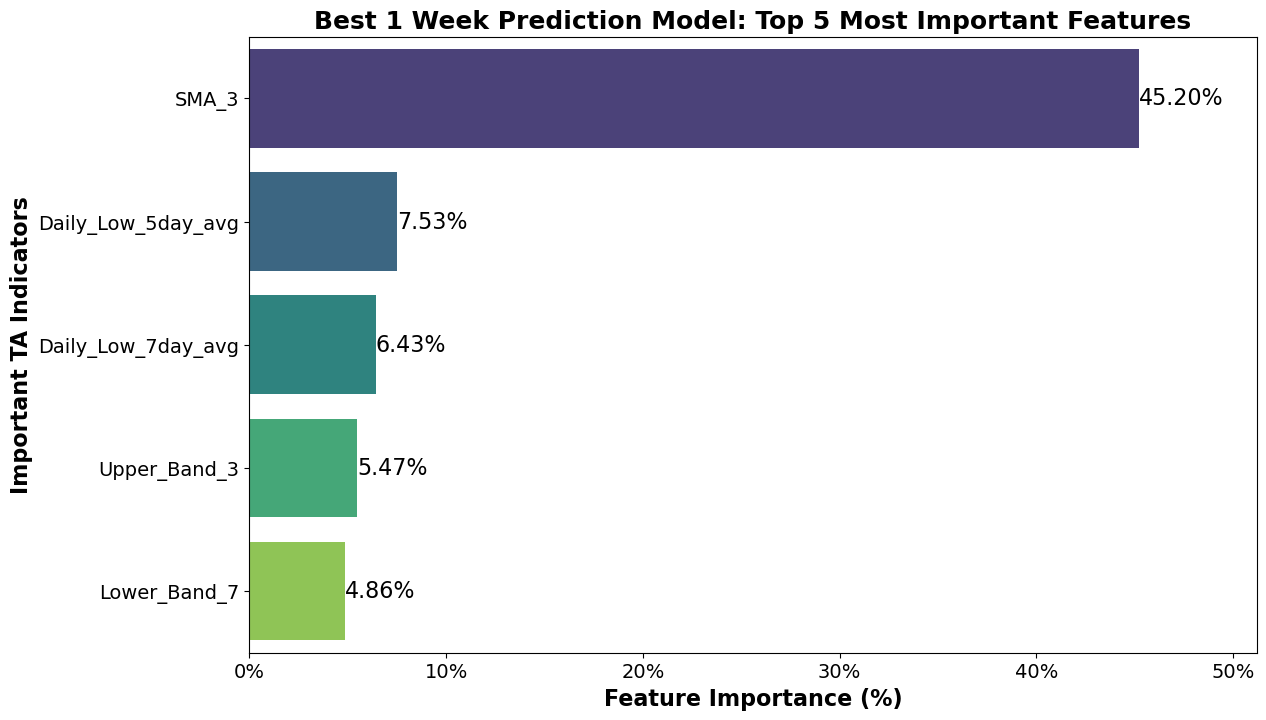

In [271]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert to NumPy arrays (ensuring correct types)
features = np.array([feature for feature, importance in sorted_features_1_week_md_3[:5]])  # Extract feature names
importances = np.array([importance for feature, importance in sorted_features_1_week_md_3[:5]])  # Extract importances

# Create a bar plot
plt.figure(figsize=(13, 8))
ax = sns.barplot(x=importances * 100, y=features, palette="viridis")

# Add text labels to the bars (feature importance values)
for i, v in enumerate(importances * 100):
    ax.text(v + 0.01, i, f"{v:.2f}%", va="center", fontsize=16)  # Adjust position & format

# Format x-axis labels to include % sign
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0f}%"))

# Extend x-axis limits for more space
plt.xlim(0, max(importances * 100) + 6)  # Extend to provide more space on the right

# Add labels and title
plt.xlabel("Feature Importance (%)", fontsize=16, fontweight='bold')  # Bigger x-axis title
plt.ylabel("Important TA Indicators", fontsize=16, fontweight='bold')  # Bigger y-axis title
plt.title("Best 1 Week Prediction Model: Top 5 Most Important Features", fontsize=18, fontweight='bold')  # Bigger title

# Increase font size for y-axis and x-axis tick labels (feature names)
ax.set_yticklabels(features, fontsize=14)
plt.xticks(fontsize=14)  # Increase font size for x-axis labels
# Show the plot
plt.show()


In [653]:
# now we're going to move onto our next model: 1 month prediction
# we'll start at our baseline model and then do the same as we just did
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
stock_data_1_month = stock_data_1_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to January 10, 2024 for training
stock_data_train_1_month_baseline = stock_data_1_month[stock_data_1_month['Date'] <= '2022-12-20']

# Filter data to only include rows with Date after February 10, 2024 for testing
stock_data_test_1_month_baseline = stock_data_1_month[stock_data_1_month['Date'] > '2023-01-20']

# Check if the test set is empty
if stock_data_test_1_month_baseline.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
stock_data_train_1_month_baseline['Close_Target'] = stock_data_train_1_month_baseline.groupby('Symbol')['Close'].shift(-20)
stock_data_test_1_month_baseline['Close_Target'] = stock_data_test_1_month_baseline.groupby('Symbol')['Close'].shift(-20)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
stock_data_train_1_month_baseline = stock_data_train_1_month_baseline.dropna(subset=['Close_Target'])
stock_data_test_1_month_baseline = stock_data_test_1_month_baseline.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
stock_data_train_1_month_baseline.replace([np.inf, -np.inf], np.nan, inplace=True)
stock_data_test_1_month_baseline.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = stock_data_train_1_month_baseline.select_dtypes(include=[np.number]).columns
numeric_cols_test = stock_data_test_1_month_baseline.select_dtypes(include=[np.number]).columns

stock_data_train_1_month_baseline[numeric_cols_train] = stock_data_train_1_month_baseline[numeric_cols_train].fillna(stock_data_train_1_month_baseline[numeric_cols_train].median())
stock_data_test_1_month_baseline[numeric_cols_test] = stock_data_test_1_month_baseline[numeric_cols_test].fillna(stock_data_test_1_month_baseline[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {stock_data_train_1_month_baseline.shape}")
print(f"Testing data shape: {stock_data_test_1_month_baseline.shape}")

# Create X (features) and y (target) for training
X_train_1_month_baseline = stock_data_train_1_month_baseline.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_month_baseline = stock_data_train_1_month_baseline['Close_Target']

# Create X and y for testing
X_test_1_month_baseline = stock_data_test_1_month_baseline.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_1_month_baseline = stock_data_test_1_month_baseline['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_1_month_baseline shape: {X_train_1_month_baseline.shape}, y_train_1_month_baseline shape: {y_train_1_month_baseline.shape}")
print(f"X_test_1_month_baseline shape: {X_test_1_month_baseline.shape}, y_test_1_month_baseline shape: {y_test_1_month_baseline.shape}")

# Ensure there are samples in both training and testing sets
if X_train_1_month_baseline.shape[0] == 0 or X_test_1_month_baseline.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_baseline_1_month = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_baseline_1_month.fit(X_train_1_month_baseline, y_train_1_month_baseline)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_1_month_baseline = model_baseline_1_month.predict(X_test_1_month_baseline)

# Calculate performance on the test data
mse_test_1_month_baseline = mean_squared_error(y_test_1_month_baseline, y_pred_1_month_baseline)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_1_month_baseline}')


Training data shape: (377672, 207)
Testing data shape: (99502, 207)
X_train_1_month_baseline shape: (377672, 203), y_train_1_month_baseline shape: (377672,)
X_test_1_month_baseline shape: (99502, 203), y_test_1_month_baseline shape: (99502,)
Mean Squared Error on unseen data (post-February 10, 2024): 14729.881436771158


In [654]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np


# Assuming `y_pred_1_month_baseline` are your predictions for the test data and `y_test_1_month_baseline` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_1_month_baseline = mean_squared_error(y_test_1_month_baseline, y_pred_1_month_baseline)
mae_1_month_baseline = mean_absolute_error(y_test_1_month_baseline, y_pred_1_month_baseline)
rmse_1_month_baseline = np.sqrt(mse_1_month_baseline)  # Root Mean Squared Error
r2_1_month_baseline = r2_score(y_test_1_month_baseline, y_pred_1_month_baseline)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_1_month_baseline}')
print(f'Mean Absolute Error on unseen data: {mae_1_month_baseline}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_month_baseline}')
print(f'R-squared on unseen data: {r2_1_month_baseline}')

# Additional metrics
medae_1_month_baseline = median_absolute_error(y_test_1_month_baseline, y_pred_1_month_baseline)
print(f'Median Absolute Error on unseen data: {medae_1_month_baseline}')

dw_stat_1_month_baseline = durbin_watson(y_test_1_month_baseline - y_pred_1_month_baseline)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_month_baseline}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_month_baseline = np.mean(np.abs((y_test_1_month_baseline - y_pred_1_month_baseline) / y_test_1_month_baseline)) * 100
print(f'MAPE on unseen data: {mape_1_month_baseline:.2f}%')
# Get feature importance as a dictionary
feature_importance_1_month_baseline = dict(zip(X_train_1_month_baseline.columns, model_baseline_1_month.feature_importances_))

# Sort features by importance in descending order
sorted_features_1_month_baseline = sorted(feature_importance_1_month_baseline.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_1_month_baseline:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 14729.881436771158
Mean Absolute Error on unseen data: 23.93967692738588
Root Mean Squared Error on unseen data: 121.36672293825502
R-squared on unseen data: 0.8614930788922437
Median Absolute Error on unseen data: 5.729209899902344
Durbin-Watson Statistic on unseen data: 0.015630554892925343
MAPE on unseen data: 6.46%
SMA_7: 20.33%
Daily_Low: 12.30%
5_day_Fib_78.6%: 11.91%
Lower_Band_10: 10.63%
Daily_High: 6.76%
Lower_Band_7: 5.11%
5_day_Fib_23.6%: 3.77%
EMA_7: 3.48%
Upper_Band_30: 3.41%
5_day_Fib_61.8%: 2.70%
Rolling_Quantile_25_7: 2.66%
Lower_Band_14: 2.63%
5_day_Fib_261.8%: 1.66%
EMA_14: 1.54%
Rolling_Quantile_75_10: 1.25%
5_day_Fib_50.0%: 0.96%
Lower_Band_20: 0.84%
Lower_Band_30: 0.83%
14_day_Fib_61.8%: 0.76%
EMA_10: 0.72%
14_day_Fib_50.0%: 0.65%
EMA_30: 0.62%
30_day_Fib_161.8%: 0.60%
5_day_Fib_100.0%: 0.53%
EMA_20: 0.49%
VWAP_10: 0.31%
Rolling_Quantile_75_20: 0.22%
5_day_Fib_423.6%: 0.19%
30_day_Fib_100.0%: 0.16%
VWAP: 0.16%
Daily_High_7day_avg:

In [659]:
# 1 month baseline model with learning_rate=0.1
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
stock_data_1_month = stock_data_1_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to January 10, 2024 for training
stock_data_train_1_month_lr_1 = stock_data_1_month[stock_data_1_month['Date'] <= '2022-12-20']

# Filter data to only include rows with Date after February 10, 2024 for testing
stock_data_test_1_month_lr_1 = stock_data_1_month[stock_data_1_month['Date'] > '2023-01-20']

# Check if the test set is empty
if stock_data_test_1_month_lr_1.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
stock_data_train_1_month_lr_1['Close_Target'] = stock_data_train_1_month_lr_1.groupby('Symbol')['Close'].shift(-20)
stock_data_test_1_month_lr_1['Close_Target'] = stock_data_test_1_month_lr_1.groupby('Symbol')['Close'].shift(-20)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
stock_data_train_1_month_lr_1 = stock_data_train_1_month_lr_1.dropna(subset=['Close_Target'])
stock_data_test_1_month_lr_1 = stock_data_test_1_month_lr_1.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
stock_data_train_1_month_lr_1.replace([np.inf, -np.inf], np.nan, inplace=True)
stock_data_test_1_month_lr_1.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = stock_data_train_1_month_lr_1.select_dtypes(include=[np.number]).columns
numeric_cols_test = stock_data_test_1_month_lr_1.select_dtypes(include=[np.number]).columns

stock_data_train_1_month_lr_1[numeric_cols_train] = stock_data_train_1_month_lr_1[numeric_cols_train].fillna(stock_data_train_1_month_lr_1[numeric_cols_train].median())
stock_data_test_1_month_lr_1[numeric_cols_test] = stock_data_test_1_month_lr_1[numeric_cols_test].fillna(stock_data_test_1_month_lr_1[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {stock_data_train_1_month_lr_1.shape}")
print(f"Testing data shape: {stock_data_test_1_month_lr_1.shape}")

# Create X (features) and y (target) for training
X_train_1_month_lr_1 = stock_data_train_1_month_lr_1.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_month_lr_1 = stock_data_train_1_month_lr_1['Close_Target']

# Create X and y for testing
X_test_1_month_lr_1 = stock_data_test_1_month_lr_1.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_1_month_lr_1 = stock_data_test_1_month_lr_1['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_1_month_lr_1 shape: {X_train_1_month_lr_1.shape}, y_train_1_month_lr_1 shape: {y_train_1_month_lr_1.shape}")
print(f"X_test_1_month_lr_1 shape: {X_test_1_month_lr_1.shape}, y_test_1_month_lr_1 shape: {y_test_1_month_lr_1.shape}")

# Ensure there are samples in both training and testing sets
if X_train_1_month_lr_1.shape[0] == 0 or X_test_1_month_lr_1.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_1_month_lr_1 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_1_month_lr_1.fit(X_train_1_month_lr_1, y_train_1_month_lr_1)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_1_month_lr_1 = model_1_month_lr_1.predict(X_test_1_month_lr_1)

# Calculate performance on the test data
mse_test_1_month_lr_1 = mean_squared_error(y_test_1_month_lr_1, y_pred_1_month_lr_1)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_1_month_lr_1}')


Training data shape: (377672, 207)
Testing data shape: (99502, 207)
X_train_1_month_lr_1 shape: (377672, 203), y_train_1_month_lr_1 shape: (377672,)
X_test_1_month_lr_1 shape: (99502, 203), y_test_1_month_lr_1 shape: (99502,)
Mean Squared Error on unseen data (post-February 10, 2024): 14629.77851575325


In [660]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Assuming `y_pred_1_month_lr_1` are your predictions for the test data and `y_test_1_month_lr_1` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_1_month_lr_1 = mean_squared_error(y_test_1_month_lr_1, y_pred_1_month_lr_1)
mae_1_month_lr_1 = mean_absolute_error(y_test_1_month_lr_1, y_pred_1_month_lr_1)
rmse_1_month_lr_1 = np.sqrt(mse_1_month_lr_1)  # Root Mean Squared Error
r2_1_month_lr_1 = r2_score(y_test_1_month_lr_1, y_pred_1_month_lr_1)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_1_month_lr_1}')
print(f'Mean Absolute Error on unseen data: {mae_1_month_lr_1}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_month_lr_1}')
print(f'R-squared on unseen data: {r2_1_month_lr_1}')

# Additional metrics
medae_1_month_lr_1 = median_absolute_error(y_test_1_month_lr_1, y_pred_1_month_lr_1)
print(f'Median Absolute Error on unseen data: {medae_1_month_lr_1}')

dw_stat_1_month_lr_1 = durbin_watson(y_test_1_month_lr_1 - y_pred_1_month_lr_1)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_month_lr_1}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_month_lr_1 = np.mean(np.abs((y_test_1_month_lr_1 - y_pred_1_month_lr_1) / y_test_1_month_lr_1)) * 100
print(f'MAPE on unseen data: {mape_1_month_lr_1:.2f}%')
# Get feature importance as a dictionary
feature_importance_1_month_lr_1 = dict(zip(X_train_1_month_lr_1.columns, model_1_month_lr_1.feature_importances_))

# Sort features by importance in descending order
sorted_features_1_month_lr_1 = sorted(feature_importance_1_month_lr_1.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_1_month_lr_1:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 14629.77851575325
Mean Absolute Error on unseen data: 24.156909516055567
Root Mean Squared Error on unseen data: 120.95362134203857
R-squared on unseen data: 0.8624343592035347
Median Absolute Error on unseen data: 5.890249252319336
Durbin-Watson Statistic on unseen data: 0.016241226144344464
MAPE on unseen data: 6.64%
Daily_Low: 18.63%
Lower_Band_10: 13.26%
Lower_Band_7: 12.75%
Daily_High: 10.18%
5_day_Fib_78.6%: 10.12%
Lower_Band_14: 4.86%
Upper_Band_30: 4.19%
EMA_7: 4.16%
5_day_Fib_61.8%: 4.04%
EMA_14: 3.17%
Rolling_Quantile_25_7: 2.71%
5_day_Fib_261.8%: 1.73%
EMA_10: 1.40%
5_day_Fib_23.6%: 1.27%
5_day_Fib_100.0%: 1.06%
14_day_Fib_61.8%: 1.06%
EMA_30: 0.87%
EMA_20: 0.82%
30_day_Fib_161.8%: 0.53%
SMA_7: 0.28%
14_day_Fib_261.8%: 0.26%
Rolling_Quantile_75_20: 0.22%
VWAP_10: 0.21%
5_day_Fib_423.6%: 0.21%
30_day_Fib_100.0%: 0.16%
VWAP: 0.13%
Daily_High_30day_avg: 0.13%
OBV: 0.12%
Rolling_Quantile_75_30_lag_30: 0.10%
Daily_High_10day_avg: 0.09%
14_day_Fi

In [657]:
# 1 month baseline model with learning_rate=0.01
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
stock_data_1_month = stock_data_1_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to January 10, 2024 for training
stock_data_train_1_month_lr_01 = stock_data_1_month[stock_data_1_month['Date'] <= '2022-12-20']

# Filter data to only include rows with Date after February 10, 2024 for testing
stock_data_test_1_month_lr_01 = stock_data_1_month[stock_data_1_month['Date'] > '2023-01-20']

# Check if the test set is empty
if stock_data_test_1_month_lr_01.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
stock_data_train_1_month_lr_01['Close_Target'] = stock_data_train_1_month_lr_01.groupby('Symbol')['Close'].shift(-20)
stock_data_test_1_month_lr_01['Close_Target'] = stock_data_test_1_month_lr_01.groupby('Symbol')['Close'].shift(-20)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
stock_data_train_1_month_lr_01 = stock_data_train_1_month_lr_01.dropna(subset=['Close_Target'])
stock_data_test_1_month_lr_01 = stock_data_test_1_month_lr_01.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
stock_data_train_1_month_lr_01.replace([np.inf, -np.inf], np.nan, inplace=True)
stock_data_test_1_month_lr_01.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = stock_data_train_1_month_lr_01.select_dtypes(include=[np.number]).columns
numeric_cols_test = stock_data_test_1_month_lr_01.select_dtypes(include=[np.number]).columns

stock_data_train_1_month_lr_01[numeric_cols_train] = stock_data_train_1_month_lr_01[numeric_cols_train].fillna(stock_data_train_1_month_lr_01[numeric_cols_train].median())
stock_data_test_1_month_lr_01[numeric_cols_test] = stock_data_test_1_month_lr_01[numeric_cols_test].fillna(stock_data_test_1_month_lr_01[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {stock_data_train_1_month_lr_01.shape}")
print(f"Testing data shape: {stock_data_test_1_month_lr_01.shape}")

# Create X (features) and y (target) for training
X_train_1_month_lr_01 = stock_data_train_1_month_lr_01.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_month_lr_01 = stock_data_train_1_month_lr_01['Close_Target']

# Create X and y for testing
X_test_1_month_lr_01 = stock_data_test_1_month_lr_01.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_1_month_lr_01 = stock_data_test_1_month_lr_01['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_1_month_lr_01 shape: {X_train_1_month_lr_01.shape}, y_train_1_month_lr_01 shape: {y_train_1_month_lr_01.shape}")
print(f"X_test_1_month_lr_01 shape: {X_test_1_month_lr_01.shape}, y_test_1_month_lr_01 shape: {y_test_1_month_lr_01.shape}")

# Ensure there are samples in both training and testing sets
if X_train_1_month_lr_01.shape[0] == 0 or X_test_1_month_lr_01.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_1_month_lr_01 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_1_month_lr_01.fit(X_train_1_month_lr_01, y_train_1_month_lr_01)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_1_month_lr_01 = model_1_month_lr_01.predict(X_test_1_month_lr_01)

# Calculate performance on the test data
mse_test_1_month_lr_01 = mean_squared_error(y_test_1_month_lr_01, y_pred_1_month_lr_01)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_1_month_lr_01}')


Training data shape: (377672, 207)
Testing data shape: (99502, 207)
X_train_1_month_lr_01 shape: (377672, 203), y_train_1_month_lr_01 shape: (377672,)
X_test_1_month_lr_01 shape: (99502, 203), y_test_1_month_lr_01 shape: (99502,)
Mean Squared Error on unseen data (post-February 10, 2024): 14373.930782913732


In [658]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np


# Assuming `y_pred_1_month_lr_01` are your predictions for the test data and `y_test_1_month_lr_01` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_month_lr_01 = mean_squared_error(y_test_1_month_lr_01, y_pred_1_month_lr_01)
mae_1_month_lr_01 = mean_absolute_error(y_test_1_month_lr_01, y_pred_1_month_lr_01)
rmse_month_lr_01 = np.sqrt(mse_month_lr_01)  # Root Mean Squared Error
r2_month_lr_01 = r2_score(y_test_1_month_lr_01, y_pred_1_month_lr_01)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_month_lr_01}')
print(f'Mean Absolute Error on unseen data: {mae_1_month_lr_01}')
print(f'Root Mean Squared Error on unseen data: {rmse_month_lr_01}')
print(f'R-squared on unseen data: {r2_month_lr_01}')

# Additional metrics
medae_1_month_lr_01 = median_absolute_error(y_test_1_month_lr_01, y_pred_1_month_lr_01)
print(f'Median Absolute Error on unseen data: {medae_1_month_lr_01}')

dw_stat_1_month_lr_01 = durbin_watson(y_test_1_month_lr_01 - y_pred_1_month_lr_01)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_month_lr_01}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_month_lr_01 = np.mean(np.abs((y_test_1_month_lr_01 - y_pred_1_month_lr_01) / y_test_1_month_lr_01)) * 100
print(f'MAPE on unseen data: {mape_1_month_lr_01:.2f}%')
# Get feature importance as a dictionary
feature_importance_month_lr_01 = dict(zip(X_train_1_month_lr_01.columns, model_1_month_lr_01.feature_importances_))

# Sort features by importance in descending order
sorted_features_1_month_lr_01 = sorted(feature_importance_month_lr_01.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_1_month_lr_01:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 14373.930782913732
Mean Absolute Error on unseen data: 22.898349393657917
Root Mean Squared Error on unseen data: 119.89132905641564
R-squared on unseen data: 0.8648401274984199
Median Absolute Error on unseen data: 5.553302764892578
Durbin-Watson Statistic on unseen data: 0.014744606767688679
MAPE on unseen data: 6.32%
SMA_7: 24.75%
Lower_Band_10: 17.64%
5_day_Fib_78.6%: 8.22%
Lower_Band_14: 8.17%
Daily_Low: 5.11%
Lower_Band_7: 4.97%
Daily_High: 3.49%
5_day_Fib_23.6%: 2.81%
Upper_Band_30: 2.77%
Rolling_Quantile_75_10: 2.51%
EMA_7: 2.03%
5_day_Fib_261.8%: 1.86%
Lower_Band_20: 1.27%
Lower_Band_30: 1.23%
Rolling_Quantile_25_7: 1.22%
EMA_14: 1.10%
5_day_Fib_50.0%: 0.99%
30_day_Fib_161.8%: 0.89%
5_day_Fib_61.8%: 0.84%
Daily_Low_7day_avg: 0.78%
14_day_Fib_50.0%: 0.71%
VWAP_10: 0.70%
30_day_Fib_100.0%: 0.59%
5_day_Fib_100.0%: 0.54%
EMA_10: 0.50%
14_day_Fib_61.8%: 0.46%
EMA_30: 0.38%
VWAP: 0.33%
EMA_20: 0.28%
OBV: 0.26%
5_day_Fib_423.6%: 0.23%
Rolling_Quanti

In [661]:
# model with learning_rate = 0.01 is best again, so we keep that parameter
# now we'll do max depth
# max depth = 3
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
stock_data_1_month = stock_data_1_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to January 10, 2024 for training
stock_data_train_1_month_md_3 = stock_data_1_month[stock_data_1_month['Date'] <= '2022-12-20']

# Filter data to only include rows with Date after February 10, 2024 for testing
stock_data_test_1_month_md_3 = stock_data_1_month[stock_data_1_month['Date'] > '2023-01-20']

# Check if the test set is empty
if stock_data_test_1_month_md_3.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
stock_data_train_1_month_md_3['Close_Target'] = stock_data_train_1_month_md_3.groupby('Symbol')['Close'].shift(-20)
stock_data_test_1_month_md_3['Close_Target'] = stock_data_test_1_month_md_3.groupby('Symbol')['Close'].shift(-20)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
stock_data_train_1_month_md_3 = stock_data_train_1_month_md_3.dropna(subset=['Close_Target'])
stock_data_test_1_month_md_3 = stock_data_test_1_month_md_3.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
stock_data_train_1_month_md_3.replace([np.inf, -np.inf], np.nan, inplace=True)
stock_data_test_1_month_md_3.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = stock_data_train_1_month_md_3.select_dtypes(include=[np.number]).columns
numeric_cols_test = stock_data_test_1_month_md_3.select_dtypes(include=[np.number]).columns

stock_data_train_1_month_md_3[numeric_cols_train] = stock_data_train_1_month_md_3[numeric_cols_train].fillna(stock_data_train_1_month_md_3[numeric_cols_train].median())
stock_data_test_1_month_md_3[numeric_cols_test] = stock_data_test_1_month_md_3[numeric_cols_test].fillna(stock_data_test_1_month_md_3[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {stock_data_train_1_month_md_3.shape}")
print(f"Testing data shape: {stock_data_test_1_month_md_3.shape}")

# Create X (features) and y (target) for training
X_train_1_month_md_3 = stock_data_train_1_month_md_3.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_month_md_3 = stock_data_train_1_month_md_3['Close_Target']

# Create X and y for testing
X_test_1_month_md_3 = stock_data_test_1_month_md_3.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_1_month_md_3 = stock_data_test_1_month_md_3['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_1_month_md_3 shape: {X_train_1_month_md_3.shape}, y_train_1_month_md_3 shape: {y_train_1_month_md_3.shape}")
print(f"X_test_1_month_md_3 shape: {X_test_1_month_md_3.shape}, y_test_1_month_md_3 shape: {y_test_1_month_md_3.shape}")

# Ensure there are samples in both training and testing sets
if X_train_1_month_md_3.shape[0] == 0 or X_test_1_month_md_3.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_1_month_md_3 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=3,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_1_month_md_3.fit(X_train_1_month_md_3, y_train_1_month_md_3)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_1_month_md_3 = model_1_month_md_3.predict(X_test_1_month_md_3)

# Calculate performance on the test data
mse_test_1_month_md_3 = mean_squared_error(y_test_1_month_md_3, y_pred_1_month_md_3)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_1_month_md_3}')


Training data shape: (377672, 207)
Testing data shape: (99502, 207)
X_train_1_month_md_3 shape: (377672, 203), y_train_1_month_md_3 shape: (377672,)
X_test_1_month_md_3 shape: (99502, 203), y_test_1_month_md_3 shape: (99502,)
Mean Squared Error on unseen data (post-February 10, 2024): 12959.123123678353


In [662]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np


# Assuming `y_pred_1_month_md_3` are your predictions for the test data and `y_test_1_month_md_3` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_1_month_md_3 = mean_squared_error(y_test_1_month_md_3, y_pred_1_month_md_3)
mae_1_month_md_3 = mean_absolute_error(y_test_1_month_md_3, y_pred_1_month_md_3)
rmse_1_month_md_3 = np.sqrt(mse_1_month_md_3)  # Root Mean Squared Error
r2_1_month_md_3 = r2_score(y_test_1_month_md_3, y_pred_1_month_md_3)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_1_month_md_3}')
print(f'Mean Absolute Error on unseen data: {mae_1_month_md_3}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_month_md_3}')
print(f'R-squared on unseen data: {r2_1_month_md_3}')

# Additional metrics
medae_1_month_md_3 = median_absolute_error(y_test_1_month_md_3, y_pred_1_month_md_3)
print(f'Median Absolute Error on unseen data: {medae_1_month_md_3}')

dw_stat_1_month_md_3 = durbin_watson(y_test_1_month_md_3 - y_pred_1_month_md_3)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_month_md_3}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_month_md_3 = np.mean(np.abs((y_test_1_month_md_3 - y_pred_1_month_md_3) / y_test_1_month_md_3)) * 100
print(f'MAPE on unseen data: {mape_1_month_md_3:.2f}%')
# Get feature importance as a dictionary
feature_importance_1_month_md_3 = dict(zip(X_train_1_month_md_3.columns, model_1_month_md_3.feature_importances_))

# Sort features by importance in descending order
sorted_features_1_month_md_3 = sorted(feature_importance_1_month_md_3.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_1_month_md_3:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 12959.123123678353
Mean Absolute Error on unseen data: 21.034712872707228
Root Mean Squared Error on unseen data: 113.83814441424435
R-squared on unseen data: 0.8781437412227758
Median Absolute Error on unseen data: 5.534698486328132
Durbin-Watson Statistic on unseen data: 0.014613108621507902
MAPE on unseen data: 6.37%
SMA_7: 17.12%
Lower_Band_30: 7.52%
Lower_Band_20: 7.44%
Lower_Band_7: 7.23%
Lower_Band_10: 7.16%
Rolling_Quantile_25_7: 4.68%
Lower_Band_14: 3.97%
Daily_Low: 3.91%
Daily_High: 3.79%
5_day_Fib_78.6%: 3.21%
Daily_High_14day_avg: 3.06%
Daily_High_10day_avg: 3.03%
5_day_Fib_261.8%: 1.95%
EMA_20: 1.93%
Upper_Band_30: 1.78%
EMA_7: 1.71%
30_day_Fib_100.0%: 1.61%
Daily_High_20day_avg: 1.49%
14_day_Fib_161.8%: 1.42%
5_day_Fib_61.8%: 1.17%
14_day_Fib_50.0%: 1.00%
14_day_Fib_78.6%: 0.98%
5_day_Fib_161.8%: 0.93%
EMA_10: 0.89%
VWAP: 0.88%
SMA_30_lag_30: 0.73%
Daily_High_30day_avg: 0.70%
EMA_14: 0.62%
5_day_Fib_50.0%: 0.60%
5_day_Fib_23.6%: 0.59%
14

In [663]:
# model with learning_rate = 0.01 is best again, so we keep that parameter
# now we'll do max depth
# max depth = 7
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
stock_data_1_month = stock_data_1_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to January 10, 2024 for training
stock_data_train_1_month_md_7 = stock_data_1_month[stock_data_1_month['Date'] <= '2022-12-20']

# Filter data to only include rows with Date after February 10, 2024 for testing
stock_data_test_1_month_md_7 = stock_data_1_month[stock_data_1_month['Date'] > '2023-01-20']

# Check if the test set is empty
if stock_data_test_1_month_md_7.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
stock_data_train_1_month_md_7['Close_Target'] = stock_data_train_1_month_md_7.groupby('Symbol')['Close'].shift(-20)
stock_data_test_1_month_md_7['Close_Target'] = stock_data_test_1_month_md_7.groupby('Symbol')['Close'].shift(-20)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
stock_data_train_1_month_md_7 = stock_data_train_1_month_md_7.dropna(subset=['Close_Target'])
stock_data_test_1_month_md_7 = stock_data_test_1_month_md_7.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
stock_data_train_1_month_md_7.replace([np.inf, -np.inf], np.nan, inplace=True)
stock_data_test_1_month_md_7.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = stock_data_train_1_month_md_7.select_dtypes(include=[np.number]).columns
numeric_cols_test = stock_data_test_1_month_md_7.select_dtypes(include=[np.number]).columns

stock_data_train_1_month_md_7[numeric_cols_train] = stock_data_train_1_month_md_7[numeric_cols_train].fillna(stock_data_train_1_month_md_7[numeric_cols_train].median())
stock_data_test_1_month_md_7[numeric_cols_test] = stock_data_test_1_month_md_7[numeric_cols_test].fillna(stock_data_test_1_month_md_7[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {stock_data_train_1_month_md_7.shape}")
print(f"Testing data shape: {stock_data_test_1_month_md_7.shape}")

# Create X (features) and y (target) for training
X_train_1_month_md_7 = stock_data_train_1_month_md_7.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_1_month_md_7 = stock_data_train_1_month_md_7['Close_Target']

# Create X and y for testing
X_test_1_month_md_7 = stock_data_test_1_month_md_7.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_1_month_md_7 = stock_data_test_1_month_md_7['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_1_month_md_7 shape: {X_train_1_month_md_7.shape}, y_train_1_month_md_7 shape: {y_train_1_month_md_7.shape}")
print(f"X_test_1_month_md_7 shape: {X_test_1_month_md_7.shape}, y_test_1_month_md_7 shape: {y_test_1_month_md_7.shape}")

# Ensure there are samples in both training and testing sets
if X_train_1_month_md_7.shape[0] == 0 or X_test_1_month_md_7.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_1_month_md_7 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=7,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_1_month_md_7.fit(X_train_1_month_md_7, y_train_1_month_md_7)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_1_month_md_7 = model_1_month_md_7.predict(X_test_1_month_md_7)

# Calculate performance on the test data
mse_test_1_month_md_7 = mean_squared_error(y_test_1_month_md_7, y_pred_1_month_md_7)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_1_month_md_7}')


Training data shape: (377672, 207)
Testing data shape: (99502, 207)
X_train_1_month_md_7 shape: (377672, 203), y_train_1_month_md_7 shape: (377672,)
X_test_1_month_md_7 shape: (99502, 203), y_test_1_month_md_7 shape: (99502,)
Mean Squared Error on unseen data (post-February 10, 2024): 14421.832261953346


In [664]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Assuming `y_pred_1_month_md_7` are your predictions for the test data and `y_test_1_month_md_7` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_1_month_md_7 = mean_squared_error(y_test_1_month_md_7, y_pred_1_month_md_7)
mae_1_month_md_7 = mean_absolute_error(y_test_1_month_md_7, y_pred_1_month_md_7)
rmse_1_month_md_7 = np.sqrt(mse_1_month_md_7)  # Root Mean Squared Error
r2_1_month_md_7 = r2_score(y_test_1_month_md_7, y_pred_1_month_md_7)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_1_month_md_7}')
print(f'Mean Absolute Error on unseen data: {mae_1_month_md_7}')
print(f'Root Mean Squared Error on unseen data: {rmse_1_month_md_7}')
print(f'R-squared on unseen data: {r2_1_month_md_7}')

# Additional metrics
medae_1_month_md_7 = median_absolute_error(y_test_1_month_md_7, y_pred_1_month_md_7)
print(f'Median Absolute Error on unseen data: {medae_1_month_md_7}')

dw_stat_1_month_md_7 = durbin_watson(y_test_1_month_md_7 - y_pred_1_month_md_7)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_1_month_md_7}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_1_month_md_7 = np.mean(np.abs((y_test_1_month_md_7 - y_pred_1_month_md_7) / y_test_1_month_md_7)) * 100
print(f'MAPE on unseen data: {mape_1_month_md_7:.2f}%')
# Get feature importance as a dictionary
feature_importance_1_month_md_7 = dict(zip(X_train_1_month_md_7.columns, model_1_month_md_7.feature_importances_))

# Sort features by importance in descending order
sorted_features_1_month_md_7 = sorted(feature_importance_1_month_md_7.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_1_month_md_7:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 14421.832261953346
Mean Absolute Error on unseen data: 23.101471335590166
Root Mean Squared Error on unseen data: 120.09093330453113
R-squared on unseen data: 0.8643897038879677
Median Absolute Error on unseen data: 5.632774353027344
Durbin-Watson Statistic on unseen data: 0.015351998651493998
MAPE on unseen data: 6.33%
SMA_7: 18.90%
5_day_Fib_78.6%: 16.58%
Lower_Band_10: 13.17%
Lower_Band_7: 10.72%
Daily_Low: 8.10%
5_day_Fib_23.6%: 6.79%
Daily_Low_7day_avg: 4.97%
Daily_High: 4.67%
Upper_Band_30: 2.96%
EMA_7: 1.74%
Rolling_Quantile_75_10: 1.45%
14_day_Fib_61.8%: 1.31%
EMA_10: 1.22%
5_day_Fib_61.8%: 0.95%
Lower_Band_14: 0.85%
30_day_Fib_100.0%: 0.61%
Rolling_Quantile_75_20: 0.44%
Rolling_Quantile_25_7: 0.44%
14_day_Fib_50.0%: 0.44%
EMA_20: 0.30%
OBV: 0.25%
VWAP_10: 0.25%
14_day_Fib_161.8%: 0.21%
30_day_Fib_161.8%: 0.17%
14_day_Fib_23.6%: 0.15%
14_day_Fib_100.0%: 0.11%
5_day_Fib_100.0%: 0.11%
Rolling_Quantile_25_30_lag_30: 0.11%
5_day_Fib_50.0%: 0.10%
1

# best 1 month prediction model:
* learning_rate = 0.01
* max_depth = 3
* model_1_month_md_3

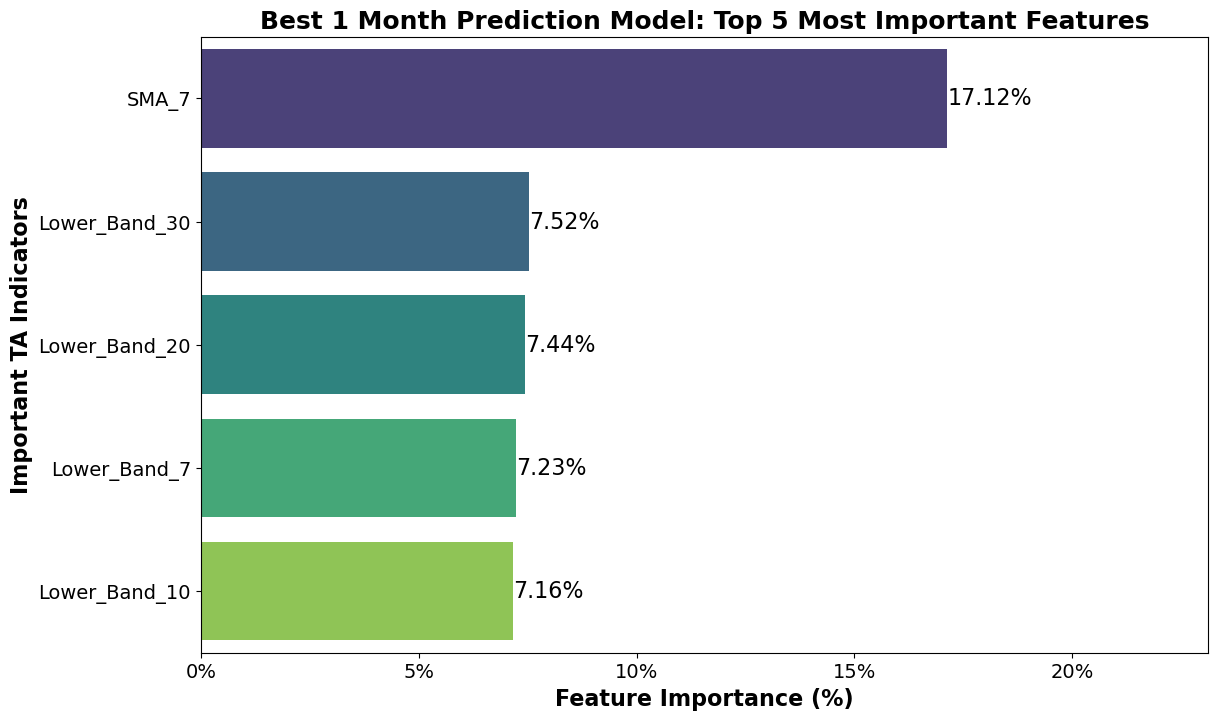

In [665]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert to NumPy arrays (ensuring correct types)
features = np.array([feature for feature, importance in sorted_features_1_month_md_3[:5]])  # Extract feature names
importances = np.array([importance for feature, importance in sorted_features_1_month_md_3[:5]])  # Extract importances

# Create a bar plot
plt.figure(figsize=(13, 8))
ax = sns.barplot(x=importances * 100, y=features, palette="viridis")

# Add text labels to the bars (feature importance values)
for i, v in enumerate(importances * 100):
    ax.text(v + 0.01, i, f"{v:.2f}%", va="center", fontsize=16)  # Adjust position & format

# Format x-axis labels to include % sign
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0f}%"))

# Extend x-axis limits for more space
plt.xlim(0, max(importances * 100) + 6)  # Extend to provide more space on the right

# Add labels and title
plt.xlabel("Feature Importance (%)", fontsize=16, fontweight='bold')  # Bigger x-axis title
plt.ylabel("Important TA Indicators", fontsize=16, fontweight='bold')  # Bigger y-axis title
plt.title("Best 1 Month Prediction Model: Top 5 Most Important Features", fontsize=18, fontweight='bold')  # Bigger title

# Increase font size for y-axis and x-axis tick labels (feature names)
ax.set_yticklabels(features, fontsize=14)
plt.xticks(fontsize=14)  # Increase font size for x-axis labels
# Show the plot
plt.show()


In [666]:
# now we're going to move onto our next model: 3 month prediction
# we'll start at our baseline model and then do the same as we just did
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
stock_data_3_month = stock_data_3_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to November 10, 2023 for training
stock_data_train_3_month_baseline = stock_data_3_month[stock_data_3_month['Date'] <= '2022-10-10']

# Filter data to only include rows with Date after February 10, 2024 for testing
stock_data_test_3_month_baseline = stock_data_3_month[stock_data_3_month['Date'] > '2023-01-10']

# Check if the test set is empty
if stock_data_test_3_month_baseline.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
stock_data_train_3_month_baseline['Close_Target'] = stock_data_train_3_month_baseline.groupby('Symbol')['Close'].shift(-60)
stock_data_test_3_month_baseline['Close_Target'] = stock_data_test_3_month_baseline.groupby('Symbol')['Close'].shift(-60)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
stock_data_train_3_month_baseline = stock_data_train_3_month_baseline.dropna(subset=['Close_Target'])
stock_data_test_3_month_baseline = stock_data_test_3_month_baseline.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
stock_data_train_3_month_baseline.replace([np.inf, -np.inf], np.nan, inplace=True)
stock_data_test_3_month_baseline.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = stock_data_train_3_month_baseline.select_dtypes(include=[np.number]).columns
numeric_cols_test = stock_data_test_3_month_baseline.select_dtypes(include=[np.number]).columns

stock_data_train_3_month_baseline[numeric_cols_train] = stock_data_train_3_month_baseline[numeric_cols_train].fillna(stock_data_train_3_month_baseline[numeric_cols_train].median())
stock_data_test_3_month_baseline[numeric_cols_test] = stock_data_test_3_month_baseline[numeric_cols_test].fillna(stock_data_test_3_month_baseline[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {stock_data_train_3_month_baseline.shape}")
print(f"Testing data shape: {stock_data_test_3_month_baseline.shape}")

# Create X (features) and y (target) for training
X_train_3_month_baseline = stock_data_train_3_month_baseline.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_3_month_baseline = stock_data_train_3_month_baseline['Close_Target']

# Create X and y for testing
X_test_3_month_baseline = stock_data_test_3_month_baseline.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_3_month_baseline = stock_data_test_3_month_baseline['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_3_month_baseline shape: {X_train_3_month_baseline.shape}, y_train_3_month_baseline shape: {y_train_3_month_baseline.shape}")
print(f"X_test_3_month_baseline shape: {X_test_3_month_baseline.shape}, y_test_3_month_baseline shape: {y_test_3_month_baseline.shape}")

# Ensure there are samples in both training and testing sets
if X_train_3_month_baseline.shape[0] == 0 or X_test_3_month_baseline.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_baseline_3_month = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_baseline_3_month.fit(X_train_3_month_baseline, y_train_3_month_baseline)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_3_month_baseline = model_baseline_3_month.predict(X_test_3_month_baseline)

# Calculate performance on the test data
mse_test_3_month_baseline = mean_squared_error(y_test_3_month_baseline, y_pred_3_month_baseline)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_3_month_baseline}')


Training data shape: (359762, 228)
Testing data shape: (92895, 228)
X_train_3_month_baseline shape: (359762, 224), y_train_3_month_baseline shape: (359762,)
X_test_3_month_baseline shape: (92895, 224), y_test_3_month_baseline shape: (92895,)
Mean Squared Error on unseen data (post-February 10, 2024): 16860.759527023438


In [668]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np


# Assuming `y_pred_3_month_baseline` are your predictions for the test data and `y_test_3_month_baseline` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_3_month_baseline = mean_squared_error(y_test_3_month_baseline, y_pred_3_month_baseline)
mae_3_month_baseline = mean_absolute_error(y_test_3_month_baseline, y_pred_3_month_baseline)
rmse_3_month_baseline = np.sqrt(mse_3_month_baseline)  # Root Mean Squared Error
r2_3_month_baseline = r2_score(y_test_3_month_baseline, y_pred_3_month_baseline)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_3_month_baseline}')
print(f'Mean Absolute Error on unseen data: {mae_3_month_baseline}')
print(f'Root Mean Squared Error on unseen data: {rmse_3_month_baseline}')
print(f'R-squared on unseen data: {r2_3_month_baseline}')

# Additional metrics
medae_3_month_baseline = median_absolute_error(y_test_3_month_baseline, y_pred_3_month_baseline)
print(f'Median Absolute Error on unseen data: {medae_3_month_baseline}')

dw_stat_3_month_baseline = durbin_watson(y_test_3_month_baseline - y_pred_3_month_baseline)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_3_month_baseline}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_3_month_baseline = np.mean(np.abs((y_test_3_month_baseline - y_pred_3_month_baseline) / y_test_3_month_baseline)) * 100
print(f'MAPE on unseen data: {mape_3_month_baseline:.2f}%')
# Get feature importance as a dictionary
feature_importance_3_month_baseline = dict(zip(X_train_3_month_baseline.columns, model_baseline_3_month.feature_importances_))

# Sort features by importance in descending order
sorted_features_3_month_baseline = sorted(feature_importance_3_month_baseline.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_3_month_baseline:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 16860.759527023438
Mean Absolute Error on unseen data: 34.89790953858637
Root Mean Squared Error on unseen data: 129.8489873931385
R-squared on unseen data: 0.8465253565809476
Median Absolute Error on unseen data: 11.04840087890625
Durbin-Watson Statistic on unseen data: 0.014174123778641448
MAPE on unseen data: 11.13%
Upper_Band_14: 29.55%
EMA_20: 19.60%
EMA_14: 11.44%
Upper_Band_20: 8.66%
Daily_High: 6.50%
Upper_Band_30: 3.36%
Daily_Low: 2.54%
30_day_Fib_161.8%: 1.98%
EMA_30: 1.65%
14_day_Fib_61.8%: 1.63%
EMA_50: 1.61%
5_day_Fib_23.6%: 1.53%
14_day_Fib_161.8%: 1.44%
Lower_Band_50: 0.99%
5_day_Fib_261.8%: 0.99%
SMA_14: 0.82%
VWAP: 0.69%
Daily_High_14day_avg: 0.49%
Daily_High_20day_avg: 0.45%
14_day_Fib_100.0%: 0.38%
Daily_Low_50day_avg: 0.36%
Upper_Band_60: 0.31%
Upper_Band_50: 0.17%
OBV_60day_avg: 0.17%
14_day_Fib_50.0%: 0.16%
Rolling_Quantile_75_50: 0.16%
14_day_Fib_38.2%: 0.15%
VWAP_14: 0.15%
Daily_High_30day_avg: 0.10%
5_day_Fib_100.0%: 0.09%
Low

In [670]:
# learning rate = 0.1
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
stock_data_3_month = stock_data_3_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to November 10, 2023 for training
stock_data_train_3_month_lr_1 = stock_data_3_month[stock_data_3_month['Date'] <= '2022-10-10']

# Filter data to only include rows with Date after February 10, 2024 for testing
stock_data_test_3_month_lr_1 = stock_data_3_month[stock_data_3_month['Date'] > '2023-01-10']

# Check if the test set is empty
if stock_data_test_3_month_lr_1.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
stock_data_train_3_month_lr_1['Close_Target'] = stock_data_train_3_month_lr_1.groupby('Symbol')['Close'].shift(-60)
stock_data_test_3_month_lr_1['Close_Target'] = stock_data_test_3_month_lr_1.groupby('Symbol')['Close'].shift(-60)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
stock_data_train_3_month_lr_1 = stock_data_train_3_month_lr_1.dropna(subset=['Close_Target'])
stock_data_test_3_month_lr_1 = stock_data_test_3_month_lr_1.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
stock_data_train_3_month_lr_1.replace([np.inf, -np.inf], np.nan, inplace=True)
stock_data_test_3_month_lr_1.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = stock_data_train_3_month_lr_1.select_dtypes(include=[np.number]).columns
numeric_cols_test = stock_data_test_3_month_lr_1.select_dtypes(include=[np.number]).columns

stock_data_train_3_month_lr_1[numeric_cols_train] = stock_data_train_3_month_lr_1[numeric_cols_train].fillna(stock_data_train_3_month_lr_1[numeric_cols_train].median())
stock_data_test_3_month_lr_1[numeric_cols_test] = stock_data_test_3_month_lr_1[numeric_cols_test].fillna(stock_data_test_3_month_lr_1[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {stock_data_train_3_month_lr_1.shape}")
print(f"Testing data shape: {stock_data_test_3_month_lr_1.shape}")

# Create X (features) and y (target) for training
X_train_3_month_lr_1 = stock_data_train_3_month_lr_1.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_3_month_lr_1 = stock_data_train_3_month_lr_1['Close_Target']

# Create X and y for testing
X_test_3_month_lr_1 = stock_data_test_3_month_lr_1.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_3_month_lr_1 = stock_data_test_3_month_lr_1['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_3_month_lr_1 shape: {X_train_3_month_lr_1.shape}, y_train_3_month_lr_1 shape: {y_train_3_month_lr_1.shape}")
print(f"X_test_3_month_lr_1 shape: {X_test_3_month_lr_1.shape}, y_test_3_month_lr_1 shape: {y_test_3_month_lr_1.shape}")

# Ensure there are samples in both training and testing sets
if X_train_3_month_lr_1.shape[0] == 0 or X_test_3_month_lr_1.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_3_month_lr_1 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_3_month_lr_1.fit(X_train_3_month_lr_1, y_train_3_month_lr_1)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_3_month_lr_1 = model_3_month_lr_1.predict(X_test_3_month_lr_1)

# Calculate performance on the test data
mse_test_3_month_lr_1 = mean_squared_error(y_test_3_month_lr_1, y_pred_3_month_lr_1)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_3_month_lr_1}')


Training data shape: (359762, 228)
Testing data shape: (92895, 228)
X_train_3_month_lr_1 shape: (359762, 224), y_train_3_month_lr_1 shape: (359762,)
X_test_3_month_lr_1 shape: (92895, 224), y_test_3_month_lr_1 shape: (92895,)
Mean Squared Error on unseen data (post-February 10, 2024): 17530.289570168006


In [671]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np


# Assuming `y_pred_3_month_lr_1` are your predictions for the test data and `y_test_3_month_lr_1` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_3_month_lr_1 = mean_squared_error(y_test_3_month_lr_1, y_pred_3_month_lr_1)
mae_3_month_lr_1 = mean_absolute_error(y_test_3_month_lr_1, y_pred_3_month_lr_1)
rmse_3_month_lr_1 = np.sqrt(mse_3_month_lr_1)  # Root Mean Squared Error
r2_3_month_lr_1 = r2_score(y_test_3_month_lr_1, y_pred_3_month_lr_1)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_3_month_lr_1}')
print(f'Mean Absolute Error on unseen data: {mae_3_month_lr_1}')
print(f'Root Mean Squared Error on unseen data: {rmse_3_month_lr_1}')
print(f'R-squared on unseen data: {r2_3_month_lr_1}')

# Additional metrics
medae_3_month_lr_1 = median_absolute_error(y_test_3_month_lr_1, y_pred_3_month_lr_1)
print(f'Median Absolute Error on unseen data: {medae_3_month_lr_1}')

dw_stat_3_month_lr_1 = durbin_watson(y_test_3_month_lr_1 - y_pred_3_month_lr_1)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_3_month_lr_1}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_3_month_lr_1 = np.mean(np.abs((y_test_3_month_lr_1 - y_pred_3_month_lr_1) / y_test_3_month_lr_1)) * 100
print(f'MAPE on unseen data: {mape_3_month_lr_1:.2f}%')
# Get feature importance as a dictionary
feature_importance_3_month_lr_1 = dict(zip(X_train_3_month_lr_1.columns, model_3_month_lr_1.feature_importances_))

# Sort features by importance in descending order
sorted_features_3_month_lr_1 = sorted(feature_importance_3_month_lr_1.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_3_month_lr_1:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 17530.289570168006
Mean Absolute Error on unseen data: 35.92602950579461
Root Mean Squared Error on unseen data: 132.4019998722376
R-squared on unseen data: 0.8404309760481333
Median Absolute Error on unseen data: 11.303009033203153
Durbin-Watson Statistic on unseen data: 0.014554722748454265
MAPE on unseen data: 11.51%
Upper_Band_14: 28.02%
EMA_14: 25.77%
EMA_20: 12.31%
Upper_Band_20: 7.57%
Daily_High: 5.91%
Upper_Band_30: 3.43%
Daily_Low: 2.64%
EMA_30: 2.20%
5_day_Fib_23.6%: 1.94%
5_day_Fib_261.8%: 1.93%
14_day_Fib_61.8%: 1.42%
30_day_Fib_161.8%: 1.00%
EMA_50: 0.74%
VWAP: 0.56%
14_day_Fib_161.8%: 0.56%
Lower_Band_50: 0.45%
Upper_Band_60: 0.42%
Daily_High_20day_avg: 0.32%
14_day_Fib_100.0%: 0.28%
14_day_Fib_50.0%: 0.22%
Rolling_Quantile_75_50: 0.20%
Upper_Band_50: 0.15%
OBV_60day_avg: 0.12%
VWAP_14: 0.12%
14_day_Fib_23.6%: 0.10%
5_day_Fib_100.0%: 0.09%
Daily_High_30day_avg: 0.07%
Daily_Low_50day_avg: 0.07%
OBV: 0.06%
Volume_90day_avg: 0.06%
30_day_Fi

In [672]:
# learning rate = 0.01
# this is the best one again
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Sort values by 'Symbol' and 'Date' to maintain time order
stock_data_3_month = stock_data_3_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to November 10, 2023 for training
stock_data_train_3_month_lr_01 = stock_data_3_month[stock_data_3_month['Date'] <= '2022-10-10']

# Filter data to only include rows with Date after February 10, 2024 for testing
stock_data_test_3_month_lr_01 = stock_data_3_month[stock_data_3_month['Date'] > '2023-01-10']

# Check if the test set is empty
if stock_data_test_3_month_lr_01.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
stock_data_train_3_month_lr_01['Close_Target'] = stock_data_train_3_month_lr_01.groupby('Symbol')['Close'].shift(-60)
stock_data_test_3_month_lr_01['Close_Target'] = stock_data_test_3_month_lr_01.groupby('Symbol')['Close'].shift(-60)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
stock_data_train_3_month_lr_01 = stock_data_train_3_month_lr_01.dropna(subset=['Close_Target'])
stock_data_test_3_month_lr_01 = stock_data_test_3_month_lr_01.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
stock_data_train_3_month_lr_01.replace([np.inf, -np.inf], np.nan, inplace=True)
stock_data_test_3_month_lr_01.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = stock_data_train_3_month_lr_01.select_dtypes(include=[np.number]).columns
numeric_cols_test = stock_data_test_3_month_lr_01.select_dtypes(include=[np.number]).columns

stock_data_train_3_month_lr_01[numeric_cols_train] = stock_data_train_3_month_lr_01[numeric_cols_train].fillna(stock_data_train_3_month_lr_01[numeric_cols_train].median())
stock_data_test_3_month_lr_01[numeric_cols_test] = stock_data_test_3_month_lr_01[numeric_cols_test].fillna(stock_data_test_3_month_lr_01[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {stock_data_train_3_month_lr_01.shape}")
print(f"Testing data shape: {stock_data_test_3_month_lr_01.shape}")

# Create X (features) and y (target) for training
X_train_3_month_lr_01 = stock_data_train_3_month_lr_01.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_3_month_lr_01 = stock_data_train_3_month_lr_01['Close_Target']

# Create X and y for testing
X_test_3_month_lr_01 = stock_data_test_3_month_lr_01.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_3_month_lr_01 = stock_data_test_3_month_lr_01['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_3_month_lr_01 shape: {X_train_3_month_lr_01.shape}, y_train_3_month_lr_01 shape: {y_train_3_month_lr_01.shape}")
print(f"X_test_3_month_lr_01 shape: {X_test_3_month_lr_01.shape}, y_test_3_month_lr_01 shape: {y_test_3_month_lr_01.shape}")

# Ensure there are samples in both training and testing sets
if X_train_3_month_lr_01.shape[0] == 0 or X_test_3_month_lr_01.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_3_month_lr_01 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_3_month_lr_01.fit(X_train_3_month_lr_01, y_train_3_month_lr_01)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_3_month_lr_01 = model_3_month_lr_01.predict(X_test_3_month_lr_01)

# Calculate performance on the test data
mse_test_3_month_lr_01 = mean_squared_error(y_test_3_month_lr_01, y_pred_3_month_lr_01)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_3_month_lr_01}')


Training data shape: (359762, 228)
Testing data shape: (92895, 228)
X_train_3_month_lr_01 shape: (359762, 224), y_train_3_month_lr_01 shape: (359762,)
X_test_3_month_lr_01 shape: (92895, 224), y_test_3_month_lr_01 shape: (92895,)
Mean Squared Error on unseen data (post-February 10, 2024): 16662.581399873445


In [673]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np


# Assuming `y_pred_3_month_lr_01` are your predictions for the test data and `y_test_3_month_lr_01` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_3_month_lr_01 = mean_squared_error(y_test_3_month_lr_01, y_pred_3_month_lr_01)
mae_3_month_lr_01 = mean_absolute_error(y_test_3_month_lr_01, y_pred_3_month_lr_01)
rmse_3_month_lr_01 = np.sqrt(mse_3_month_lr_01)  # Root Mean Squared Error
r2_3_month_lr_01 = r2_score(y_test_3_month_lr_01, y_pred_3_month_lr_01)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_3_month_lr_01}')
print(f'Mean Absolute Error on unseen data: {mae_3_month_lr_01}')
print(f'Root Mean Squared Error on unseen data: {rmse_3_month_lr_01}')
print(f'R-squared on unseen data: {r2_3_month_lr_01}')

# Additional metrics
medae_3_month_lr_01 = median_absolute_error(y_test_3_month_lr_01, y_pred_3_month_lr_01)
print(f'Median Absolute Error on unseen data: {medae_3_month_lr_01}')

dw_stat_3_month_lr_01 = durbin_watson(y_test_3_month_lr_01 - y_pred_3_month_lr_01)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_3_month_lr_01}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_3_month_lr_01 = np.mean(np.abs((y_test_3_month_lr_01 - y_pred_3_month_lr_01) / y_test_3_month_lr_01)) * 100
print(f'MAPE on unseen data: {mape_3_month_lr_01:.2f}%')
# Get feature importance as a dictionary
feature_importance_3_month_lr_01 = dict(zip(X_train_3_month_lr_01.columns, model_3_month_lr_01.feature_importances_))

# Sort features by importance in descending order
sorted_features_3_month_lr_01 = sorted(feature_importance_3_month_lr_01.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_3_month_lr_01:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 16662.581399873445
Mean Absolute Error on unseen data: 33.3040269837543
Root Mean Squared Error on unseen data: 129.08362173363994
R-squared on unseen data: 0.8483292680446662
Median Absolute Error on unseen data: 10.192817687988281
Durbin-Watson Statistic on unseen data: 0.013667986453904692
MAPE on unseen data: 10.56%
Upper_Band_14: 22.09%
EMA_14: 12.43%
EMA_20: 11.34%
Upper_Band_20: 9.24%
Daily_High: 4.65%
Upper_Band_30: 4.65%
30_day_Fib_161.8%: 3.99%
EMA_30: 3.66%
14_day_Fib_161.8%: 3.60%
Lower_Band_50: 3.47%
SMA_14: 2.82%
Daily_Low: 2.21%
VWAP: 1.44%
5_day_Fib_261.8%: 1.41%
Daily_High_14day_avg: 1.25%
5_day_Fib_23.6%: 1.18%
14_day_Fib_61.8%: 1.10%
EMA_50: 1.04%
Daily_Low_50day_avg: 0.83%
Upper_Band_60: 0.57%
Daily_High_20day_avg: 0.55%
14_day_Fib_100.0%: 0.52%
Rolling_Quantile_75_50: 0.41%
Upper_Band_50: 0.36%
VWAP_14: 0.26%
EMA_90: 0.24%
14_day_Fib_38.2%: 0.24%
OBV_60day_avg: 0.23%
Daily_Low_30day_avg: 0.23%
30_day_Fib_23.6%: 0.22%
OBV: 0.18%
Da

In [674]:
# learning rate = 0.01
# max depth 3
# this is actually the best one for 3 months now
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Sort values by 'Symbol' and 'Date' to maintain time order
stock_data_3_month = stock_data_3_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to November 10, 2023 for training
stock_data_train_3_month_md_3 = stock_data_3_month[stock_data_3_month['Date'] <= '2022-10-10']

# Filter data to only include rows with Date after February 10, 2024 for testing
stock_data_test_3_month_md_3 = stock_data_3_month[stock_data_3_month['Date'] > '2023-01-10']

# Check if the test set is empty
if stock_data_test_3_month_md_3.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
stock_data_train_3_month_md_3['Close_Target'] = stock_data_train_3_month_md_3.groupby('Symbol')['Close'].shift(-60)
stock_data_test_3_month_md_3['Close_Target'] = stock_data_test_3_month_md_3.groupby('Symbol')['Close'].shift(-60)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
stock_data_train_3_month_md_3 = stock_data_train_3_month_md_3.dropna(subset=['Close_Target'])
stock_data_test_3_month_md_3 = stock_data_test_3_month_md_3.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
stock_data_train_3_month_md_3.replace([np.inf, -np.inf], np.nan, inplace=True)
stock_data_test_3_month_md_3.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = stock_data_train_3_month_md_3.select_dtypes(include=[np.number]).columns
numeric_cols_test = stock_data_test_3_month_md_3.select_dtypes(include=[np.number]).columns

stock_data_train_3_month_md_3[numeric_cols_train] = stock_data_train_3_month_md_3[numeric_cols_train].fillna(stock_data_train_3_month_md_3[numeric_cols_train].median())
stock_data_test_3_month_md_3[numeric_cols_test] = stock_data_test_3_month_md_3[numeric_cols_test].fillna(stock_data_test_3_month_md_3[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {stock_data_train_3_month_md_3.shape}")
print(f"Testing data shape: {stock_data_test_3_month_md_3.shape}")

# Create X (features) and y (target) for training
X_train_3_month_md_3 = stock_data_train_3_month_md_3.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_3_month_md_3 = stock_data_train_3_month_md_3['Close_Target']

# Create X and y for testing
X_test_3_month_md_3 = stock_data_test_3_month_md_3.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_3_month_md_3 = stock_data_test_3_month_md_3['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_3_month_md_3 shape: {X_train_3_month_md_3.shape}, y_train_3_month_md_3 shape: {y_train_3_month_md_3.shape}")
print(f"X_test_3_month_md_3 shape: {X_test_3_month_md_3.shape}, y_test_3_month_md_3 shape: {y_test_3_month_md_3.shape}")

# Ensure there are samples in both training and testing sets
if X_train_3_month_md_3.shape[0] == 0 or X_test_3_month_md_3.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_3_month_md_3 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=3,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_3_month_md_3.fit(X_train_3_month_md_3, y_train_3_month_md_3)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_3_month_md_3 = model_3_month_md_3.predict(X_test_3_month_md_3)

# Calculate performance on the test data
mse_test_3_month_md_3 = mean_squared_error(y_test_3_month_md_3, y_pred_3_month_md_3)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_3_month_md_3}')


Training data shape: (359762, 228)
Testing data shape: (92895, 228)
X_train_3_month_md_3 shape: (359762, 224), y_train_3_month_md_3 shape: (359762,)
X_test_3_month_md_3 shape: (92895, 224), y_test_3_month_md_3 shape: (92895,)
Mean Squared Error on unseen data (post-February 10, 2024): 15557.952732246475


In [675]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Assuming `y_pred_3_month_md_3` are your predictions for the test data and `y_test_3_month_md_3` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_3_month_md_3 = mean_squared_error(y_test_3_month_md_3, y_pred_3_month_md_3)
mae_3_month_md_3 = mean_absolute_error(y_test_3_month_md_3, y_pred_3_month_md_3)
rmse_3_month_md_3 = np.sqrt(mse_3_month_md_3)  # Root Mean Squared Error
r2_3_month_md_3 = r2_score(y_test_3_month_md_3, y_pred_3_month_md_3)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_3_month_md_3}')
print(f'Mean Absolute Error on unseen data: {mae_3_month_md_3}')
print(f'Root Mean Squared Error on unseen data: {rmse_3_month_md_3}')
print(f'R-squared on unseen data: {r2_3_month_md_3}')

# Additional metrics
medae_3_month_md_3 = median_absolute_error(y_test_3_month_md_3, y_pred_3_month_md_3)
print(f'Median Absolute Error on unseen data: {medae_3_month_md_3}')

dw_stat_3_month_md_3 = durbin_watson(y_test_3_month_md_3 - y_pred_3_month_md_3)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_3_month_md_3}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_3_month_md_3 = np.mean(np.abs((y_test_3_month_md_3 - y_pred_3_month_md_3) / y_test_3_month_md_3)) * 100
print(f'MAPE on unseen data: {mape_3_month_md_3:.2f}%')
# Get feature importance as a dictionary
feature_importance_3_month_md_3 = dict(zip(X_train_3_month_md_3.columns, model_3_month_md_3.feature_importances_))

# Sort features by importance in descending order
sorted_features_3_month_md_3 = sorted(feature_importance_3_month_md_3.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_3_month_md_3:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 15557.952732246475
Mean Absolute Error on unseen data: 30.68257021862927
Root Mean Squared Error on unseen data: 124.73152260854701
R-squared on unseen data: 0.8583841229640307
Median Absolute Error on unseen data: 10.095184326171818
Durbin-Watson Statistic on unseen data: 0.014317481712311503
MAPE on unseen data: 10.58%
14_day_Fib_161.8%: 25.62%
Upper_Band_14: 9.53%
Upper_Band_20: 5.85%
EMA_20: 5.00%
Upper_Band_30: 4.94%
EMA_14: 4.44%
EMA_90: 4.35%
Daily_High: 4.17%
EMA_50: 4.02%
5_day_Fib_261.8%: 3.77%
30_day_Fib_161.8%: 2.79%
Daily_High_14day_avg: 2.40%
Daily_High_30day_avg: 1.86%
Daily_High_20day_avg: 1.74%
5_day_Fib_23.6%: 1.66%
Daily_High_50day_avg: 1.49%
VWAP_30: 1.46%
Daily_Low: 1.37%
5_day_Fib_161.8%: 1.33%
Close_lag_90: 1.20%
VWAP: 1.11%
5_day_Fib_423.6%: 1.01%
VWAP_14: 0.65%
EMA_30: 0.62%
SMA_14: 0.57%
5_day_Fib_100.0%: 0.53%
Daily_Low_14day_avg: 0.41%
Rolling_Median_90_lag_30: 0.39%
14_day_Fib_261.8%: 0.36%
SMA_90: 0.34%
Upper_Band_60: 0.2

In [678]:
# learning rate = 0.01
# max depth 7
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Sort values by 'Symbol' and 'Date' to maintain time order
stock_data_3_month = stock_data_3_month.sort_values(by=['Symbol', 'Date'])

# Filter data to only include rows with Date before or equal to November 10, 2023 for training
stock_data_train_3_month_md_7 = stock_data_3_month[stock_data_3_month['Date'] <= '2022-10-10']

# Filter data to only include rows with Date after February 10, 2024 for testing
stock_data_test_3_month_md_7 = stock_data_3_month[stock_data_3_month['Date'] > '2023-01-10']

# Check if the test set is empty
if stock_data_test_3_month_md_7.empty:
    raise ValueError("No data available in the testing set for the given date range.")

# Shift 'Close' to predict 20 trading days ahead (1 month ahead)
stock_data_train_3_month_md_7['Close_Target'] = stock_data_train_3_month_md_7.groupby('Symbol')['Close'].shift(-60)
stock_data_test_3_month_md_7['Close_Target'] = stock_data_test_3_month_md_7.groupby('Symbol')['Close'].shift(-60)

# Drop rows where 'Close_Target' is NaN (caused by shifting)
stock_data_train_3_month_md_7 = stock_data_train_3_month_md_7.dropna(subset=['Close_Target'])
stock_data_test_3_month_md_7 = stock_data_test_3_month_md_7.dropna(subset=['Close_Target'])

# Replace infinite values with NaN
stock_data_train_3_month_md_7.replace([np.inf, -np.inf], np.nan, inplace=True)
stock_data_test_3_month_md_7.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the median (or mean) of each numeric column
numeric_cols_train = stock_data_train_3_month_md_7.select_dtypes(include=[np.number]).columns
numeric_cols_test = stock_data_test_3_month_md_7.select_dtypes(include=[np.number]).columns

stock_data_train_3_month_md_7[numeric_cols_train] = stock_data_train_3_month_md_7[numeric_cols_train].fillna(stock_data_train_3_month_md_7[numeric_cols_train].median())
stock_data_test_3_month_md_7[numeric_cols_test] = stock_data_test_3_month_md_7[numeric_cols_test].fillna(stock_data_test_3_month_md_7[numeric_cols_test].median())

# Check for the shapes of the data
print(f"Training data shape: {stock_data_train_3_month_md_7.shape}")
print(f"Testing data shape: {stock_data_test_3_month_md_7.shape}")

# Create X (features) and y (target) for training
X_train_3_month_md_7 = stock_data_train_3_month_md_7.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_train_3_month_md_7 = stock_data_train_3_month_md_7['Close_Target']

# Create X and y for testing
X_test_3_month_md_7 = stock_data_test_3_month_md_7.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
y_test_3_month_md_7 = stock_data_test_3_month_md_7['Close_Target']

# Check the shapes of the training and testing data
print(f"X_train_3_month_md_7 shape: {X_train_3_month_md_7.shape}, y_train_3_month_md_7 shape: {y_train_3_month_md_7.shape}")
print(f"X_test_3_month_md_7 shape: {X_test_3_month_md_7.shape}, y_test_3_month_md_7 shape: {y_test_3_month_md_7.shape}")

# Ensure there are samples in both training and testing sets
if X_train_3_month_md_7.shape[0] == 0 or X_test_3_month_md_7.shape[0] == 0:
    raise ValueError("Insufficient data in either training or testing set.")

# Initialize and train XGBoost model
model_3_month_md_7 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=7,
    alpha=0,
    reg_lambda=1,  # Fixed parameter name
    objective='reg:squarederror',
    missing=np.nan  # Ensure missing values are handled correctly
)

# Train the model on the training data
model_3_month_md_7.fit(X_train_3_month_md_7, y_train_3_month_md_7)

# Make predictions on the unseen test data (post-February 10, 2024)
y_pred_3_month_md_7 = model_3_month_md_7.predict(X_test_3_month_md_7)

# Calculate performance on the test data
mse_test_3_month_md_7 = mean_squared_error(y_test_3_month_md_7, y_pred_3_month_md_7)
print(f'Mean Squared Error on unseen data (post-February 10, 2024): {mse_test_3_month_md_7}')


Training data shape: (359762, 228)
Testing data shape: (92895, 228)
X_train_3_month_md_7 shape: (359762, 224), y_train_3_month_md_7 shape: (359762,)
X_test_3_month_md_7 shape: (92895, 224), y_test_3_month_md_7 shape: (92895,)
Mean Squared Error on unseen data (post-February 10, 2024): 18333.01972217981


In [679]:
# metrics and feature importance on unseen data
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Assuming `y_pred_3_month_md_7` are your predictions for the test data and `y_test_3_month_md_7` are the true values for the test data

# Calculate performance metrics on unseen test data
mse_3_month_md_7 = mean_squared_error(y_test_3_month_md_7, y_pred_3_month_md_7)
mae_3_month_md_7 = mean_absolute_error(y_test_3_month_md_7, y_pred_3_month_md_7)
rmse_3_month_md_7 = np.sqrt(mse_3_month_md_7)  # Root Mean Squared Error
r2_3_month_md_7 = r2_score(y_test_3_month_md_7, y_pred_3_month_md_7)

# Print out the metrics for unseen data
print(f'Mean Squared Error on unseen data: {mse_3_month_md_7}')
print(f'Mean Absolute Error on unseen data: {mae_3_month_md_7}')
print(f'Root Mean Squared Error on unseen data: {rmse_3_month_md_7}')
print(f'R-squared on unseen data: {r2_3_month_md_7}')

# Additional metrics
medae_3_month_md_7 = median_absolute_error(y_test_3_month_md_7, y_pred_3_month_md_7)
print(f'Median Absolute Error on unseen data: {medae_3_month_md_7}')

dw_stat_3_month_md_7 = durbin_watson(y_test_3_month_md_7 - y_pred_3_month_md_7)
print(f'Durbin-Watson Statistic on unseen data: {dw_stat_3_month_md_7}')

# Calculate MAPE (Mean Absolute Percentage Error) on unseen data
mape_3_month_md_7 = np.mean(np.abs((y_test_3_month_md_7 - y_pred_3_month_md_7) / y_test_3_month_md_7)) * 100
print(f'MAPE on unseen data: {mape_3_month_md_7:.2f}%')
# Get feature importance as a dictionary
feature_importance_3_month_md_7 = dict(zip(X_train_3_month_md_7.columns, model_3_month_md_7.feature_importances_))

# Sort features by importance in descending order
sorted_features_3_month_md_7 = sorted(feature_importance_3_month_md_7.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance values
for feature, importance in sorted_features_3_month_md_7:
    print(f"{feature}: {importance * 100:.2f}%")



Mean Squared Error on unseen data: 18333.01972217981
Mean Absolute Error on unseen data: 35.35744857920776
Root Mean Squared Error on unseen data: 135.39948198637916
R-squared on unseen data: 0.8331241448437455
Median Absolute Error on unseen data: 10.54766845703125
Durbin-Watson Statistic on unseen data: 0.013718629163176708
MAPE on unseen data: 10.87%
Upper_Band_14: 39.18%
EMA_14: 16.78%
EMA_20: 12.60%
Daily_High: 4.98%
EMA_30: 3.63%
Daily_Low: 3.45%
Upper_Band_30: 3.44%
14_day_Fib_61.8%: 3.12%
Upper_Band_20: 1.60%
5_day_Fib_23.6%: 1.46%
SMA_14: 1.40%
VWAP: 1.24%
Daily_Low_30day_avg: 0.66%
Daily_High_14day_avg: 0.51%
Lower_Band_50: 0.41%
Daily_Low_50day_avg: 0.37%
VWAP_14: 0.32%
30_day_Fib_161.8%: 0.31%
OBV_60day_avg: 0.29%
Rolling_Quantile_75_14: 0.26%
Rolling_Quantile_25_14: 0.21%
14_day_Fib_23.6%: 0.21%
OBV: 0.21%
EMA_50: 0.18%
Daily_High_30day_avg: 0.14%
Lower_Band_20: 0.14%
14_day_Fib_38.2%: 0.14%
Volume_90day_avg: 0.13%
Daily_Low_60day_avg: 0.13%
SMA_30: 0.12%
30_day_Fib_23.6%:

# best 3 month prediction model
* learning_rate = 0.01
* max_depth = 3

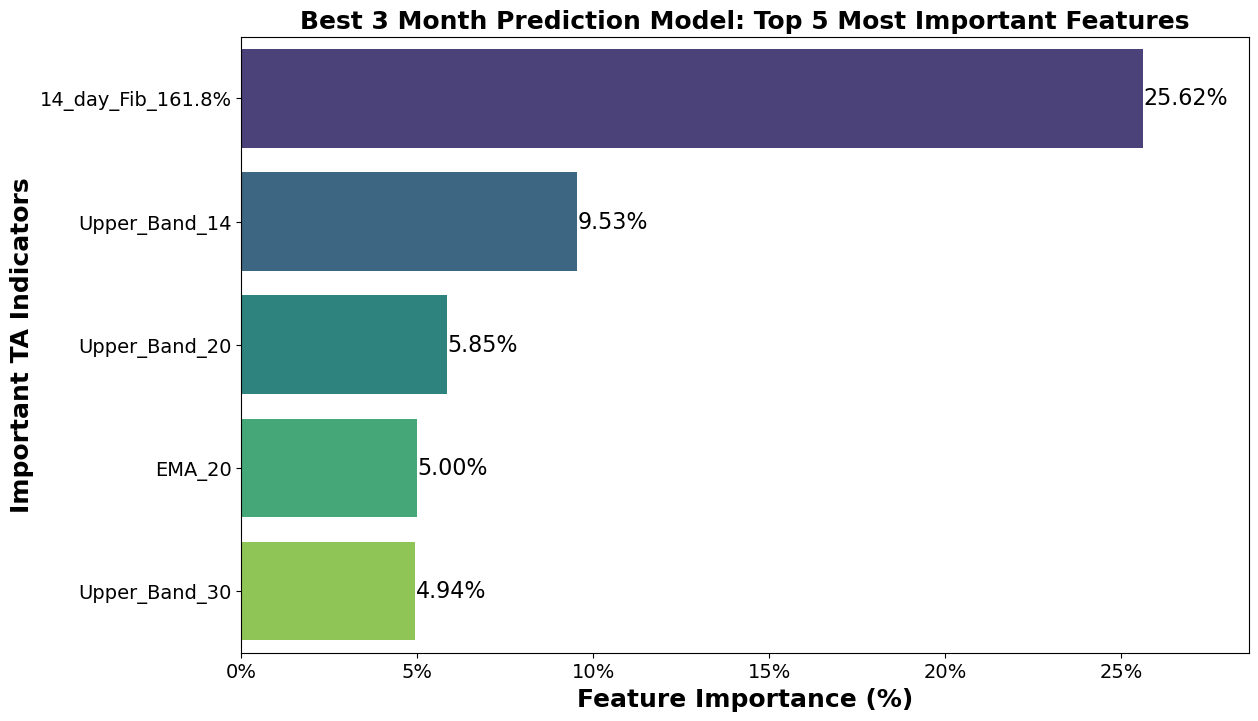

In [680]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert to NumPy arrays (ensuring correct types)
features = np.array([feature for feature, importance in sorted_features_3_month_md_3[:5]])  # Extract feature names
importances = np.array([importance for feature, importance in sorted_features_3_month_md_3[:5]])  # Extract importances

# Create a bar plot
plt.figure(figsize=(13, 8))
ax = sns.barplot(x=importances * 100, y=features, palette="viridis")

# Add text labels to the bars (feature importance values)
for i, v in enumerate(importances * 100):
    ax.text(v + 0.01, i, f"{v:.2f}%", va="center", fontsize=16)  # Adjust position & format

# Format x-axis labels to include % sign
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0f}%"))

# Extend x-axis limits for more space
plt.xlim(0, max(importances * 100) + 3)  # Extend to provide more space on the right

# Add labels and title
plt.xlabel("Feature Importance (%)", fontsize=18, fontweight='bold')  # Bigger x-axis title
plt.ylabel("Important TA Indicators", fontsize=18, fontweight='bold')  # Bigger y-axis title
plt.title("Best 3 Month Prediction Model: Top 5 Most Important Features", fontsize=18, fontweight='bold')  # Bigger title

# Increase font size for y-axis and x-axis tick labels (feature names)
ax.set_yticklabels(features, fontsize=14)
plt.xticks(fontsize=14)  # Increase font size for x-axis labels
# Show the plot
plt.show()


In [692]:
from collections import defaultdict
# maybe put all feature importances of best models together and find the top 5 most contributing features

# Combine feature importance values
feature_importance_dict = defaultdict(float)

# Iterate through all feature-importance pairs
all_important_features = sorted_features_1_month_md_3 + sorted_features_1_week_md_3 + sorted_features_3_month_md_3

for feature, importance in all_important_features:
    feature_importance_dict[feature] += importance  # Sum up importance values

sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)


# Print only features with at least 1% total importance
for feature, importance in sorted_features:
    if importance * 100 >= 1:
        print(f"{feature}: {importance * 100:.2f}%")

SMA_3: 45.20%
14_day_Fib_161.8%: 27.06%
SMA_7: 18.88%
Lower_Band_7: 12.09%
Daily_High: 10.54%
Upper_Band_14: 9.53%
Daily_Low: 8.06%
Lower_Band_20: 7.61%
Daily_Low_5day_avg: 7.53%
Lower_Band_30: 7.52%
Lower_Band_10: 7.16%
EMA_20: 6.93%
Upper_Band_30: 6.73%
Daily_Low_7day_avg: 6.43%
5_day_Fib_261.8%: 6.36%
Upper_Band_20: 5.95%
Upper_Band_3: 5.47%
Daily_High_14day_avg: 5.47%
EMA_14: 5.06%
Rolling_Quantile_25_7: 4.69%
Daily_Low_3day_avg: 4.36%
EMA_90: 4.35%
EMA_50: 4.02%
Lower_Band_14: 3.98%
5_day_Fib_78.6%: 3.39%
Daily_High_20day_avg: 3.24%
30_day_Fib_161.8%: 3.23%
Daily_High_10day_avg: 3.03%
30_day_Fib_100.0%: 2.77%
EMA_3: 2.76%
Lower_Band_3: 2.67%
5_day_Fib_161.8%: 2.57%
Daily_High_30day_avg: 2.56%
5_day_Fib_23.6%: 2.39%
EMA_7: 2.31%
VWAP: 2.00%
Upper_Band_5: 1.95%
5_day_Fib_423.6%: 1.63%
Daily_High_3day_avg: 1.58%
VWAP_30: 1.52%
Daily_High_50day_avg: 1.49%
Lower_Band_5: 1.39%
Daily_High_5day_avg: 1.23%
Close_lag_90: 1.20%
5_day_Fib_61.8%: 1.17%
14_day_Fib_261.8%: 1.15%
14_day_Fib_78.6%

In [689]:
all_important_features

[('14_day_Fib_161.8%', 0.2562147),
 ('Upper_Band_14', 0.09532025),
 ('Upper_Band_20', 0.05852972),
 ('EMA_20', 0.049986072),
 ('Upper_Band_30', 0.04942517),
 ('EMA_14', 0.044395383),
 ('EMA_90', 0.04354552),
 ('Daily_High', 0.04173713),
 ('EMA_50', 0.040164586),
 ('5_day_Fib_261.8%', 0.03766669),
 ('30_day_Fib_161.8%', 0.027877275),
 ('Daily_High_14day_avg', 0.024039952),
 ('Daily_High_30day_avg', 0.018553419),
 ('Daily_High_20day_avg', 0.017428938),
 ('5_day_Fib_23.6%', 0.016649429),
 ('Daily_High_50day_avg', 0.014942709),
 ('VWAP_30', 0.014605744),
 ('Daily_Low', 0.013685702),
 ('5_day_Fib_161.8%', 0.01325951),
 ('Close_lag_90', 0.012013476),
 ('VWAP', 0.011084907),
 ('5_day_Fib_423.6%', 0.010086692),
 ('VWAP_14', 0.00645369),
 ('EMA_30', 0.0061686435),
 ('SMA_14', 0.00568983),
 ('5_day_Fib_100.0%', 0.005298351),
 ('Daily_Low_14day_avg', 0.0041166423),
 ('Rolling_Median_90_lag_30', 0.0039424826),
 ('14_day_Fib_261.8%', 0.0036314428),
 ('SMA_90', 0.0033690217),
 ('Upper_Band_60', 0.00

best model: learning_rate = 0.01 and max_depth = 3

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert to NumPy arrays (ensuring correct types)
features = np.array([feature for feature, importance in sorted_features_6_month_md_3[:5]])  # Extract feature names
importances = np.array([importance for feature, importance in sorted_features_6_month_md_3[:5]])  # Extract importances

# Create a bar plot
plt.figure(figsize=(13, 8))
ax = sns.barplot(x=importances * 100, y=features, palette="viridis")

# Add text labels to the bars (feature importance values)
for i, v in enumerate(importances * 100):
    ax.text(v + 0.01, i, f"{v:.2f}%", va="center", fontsize=16)  # Adjust position & format

# Format x-axis labels to include % sign
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0f}%"))

# Extend x-axis limits for more space
plt.xlim(0, max(importances * 100) + 3)  # Extend to provide more space on the right

# Add labels and title
plt.xlabel("Feature Importance (%)", fontsize=18, fontweight='bold')  # Bigger x-axis title
plt.ylabel("Important TA Indicators", fontsize=18, fontweight='bold')  # Bigger y-axis title
plt.title("Best 6 Month Prediction Model: Top 5 Most Important Features", fontsize=18, fontweight='bold')  # Bigger title

# Increase font size for y-axis and x-axis tick labels (feature names)
ax.set_yticklabels(features, fontsize=14)
plt.xticks(fontsize=14)  # Increase font size for x-axis labels
# Show the plot
plt.show()


Best model metrics

most important metrics to visualize:

1. Root Mean Squared Error
2. R-squared
3. MAPE
4. Median Absolute Error

1 week:

Mean Squared Error on unseen data: 7604.147083529955
Mean Absolute Error on unseen data: 10.044193260395863
Root Mean Squared Error on unseen data: 87.20176078227982
R-squared on unseen data: 0.9656152295864199
Median Absolute Error on unseen data: 1.588897705078125
Durbin-Watson Statistic on unseen data: 0.1674710246723756
MAPE on unseen data: 3.96%




Fib_10_Low_Min: 63.23%
Fib_30_High_Max: 14.79%
Low: 4.90%
5_day-Fib_38: 4.25%
High: 3.05%
5_day-Fib_61: 1.76%
10_day_Fib_23: 1.33%
Fib_30_Low_Min: 1.28%
Volume: 1.07%
Fib_5_Low_Min: 0.89%
5_day-Fib_50: 0.66%
EMA_5: 0.49%
SMA_5: 0.44%
30_day_Fib_38: 0.42%
5_day-Fib_23: 0.24%
Std_Dev: 0.20%
Cumulative_Price_Volume: 0.20%
EMA_12_MACD: 0.08%
SMA_20: 0.08%
30_day_Fib_50: 0.06%
VWAP: 0.05%
30_day_Fib_61: 0.05%
SMA_5_lag_7: 0.05%
ATR_True_Range: 0.05%
SMA_50: 0.05%
ATR_Prev_Close: 0.05%
Cumulative_Volume: 0.05%
Fib_5_High_Max: 0.04%
EMA_20: 0.04%
ATR: 0.03%
Upper_Band: 0.03%
Fib_10_High_Max: 0.01%
Lower_Band: 0.01%
Volume_lag_1: 0.01%
EMA_26_MACD: 0.01%
EMA_50: 0.01%
10_day_Fib_61: 0.01%


1 month:

Mean Squared Error on unseen data: 10844.724459170979
Mean Absolute Error on unseen data: 15.639166248218757
Root Mean Squared Error on unseen data: 104.13800679469037
R-squared on unseen data: 0.9513849924746814
Median Absolute Error on unseen data: 3.326946258544922
Durbin-Watson Statistic on unseen data: 0.0750817215794377
MAPE on unseen data: 7.82%

30_day_Fib_23: 52.41%
Fib_30_High_Max: 32.44%
Fib_5_Low_Min: 2.25%
Low: 2.08%
10_day_Fib_23: 1.96%
High: 1.77%
Volume: 1.43%
5_day-Fib_50: 1.11%
30_day_Fib_50: 0.68%
10_day_Fib_38: 0.62%
5_day-Fib_23: 0.48%
Fib_10_High_Max: 0.28%
Fib_10_Low_Min: 0.25%
Std_Dev: 0.21%
VWAP: 0.21%
ATR_Prev_Close: 0.20%
EMA_5: 0.19%
Fib_5_High_Max: 0.19%
Cumulative_Price_Volume: 0.17%
Lower_Band: 0.16%
EMA_26_MACD: 0.14%
30_day_Fib_61: 0.11%
SMA_5: 0.11%
SMA_20_lag_1: 0.06%
Upper_Band: 0.05%
5_day-Fib_61: 0.04%
ATR_True_Range: 0.04%
Cumulative_Volume: 0.04%
30_day_Fib_38: 0.03%
10_day_Fib_61: 0.03%
EMA_50: 0.02%
Fib_30_Low_Min: 0.02%
ATR: 0.02%
Volume_lag_1: 0.02%
Close_lag_1: 0.02%
EMA_20_lag_20: 0.02%
SMA_50: 0.01%
EMA_12_MACD_lag_15: 0.01%
EMA_12_MACD_lag_12: 0.01%


3 months:

Mean Squared Error on unseen data: 25855.13009374476
Mean Absolute Error on unseen data: 25.29591435606357
Root Mean Squared Error on unseen data: 160.79530494931984
R-squared on unseen data: 0.8883720519645201
Median Absolute Error on unseen data: 6.283714294433594
Durbin-Watson Statistic on unseen data: 0.017109218495924613
MAPE on unseen data: 15.52%

Fib_30_Low_Min: 27.17%
30_day_Fib_38: 14.80%
5_day-Fib_61: 11.17%
Upper_Band: 8.25%
Fib_10_Low_Min: 3.10%
10_day_Fib_50: 2.76%
Close_lag_1: 2.34%
Volume: 1.87%
EMA_5: 1.82%
Fib_5_Low_Min: 1.69%
Fib_5_High_Max: 1.51%
30_day_Fib_23: 1.50%
High: 1.48%
EMA_50_lag_25: 1.37%
30_day_Fib_50: 1.29%
ATR_High_Low: 1.20%
EMA_26_MACD: 1.11%
EMA_50: 1.08%
SMA_50: 1.02%
ATR: 1.00%
10_day_Fib_61: 0.87%
Low: 0.86%
EMA_12_MACD: 0.82%
Close_lag_90: 0.76%
5_day-Fib_23: 0.76%
EMA_20: 0.73%
SMA_20_lag_90: 0.60%
EMA_12_MACD_lag_90: 0.58%
10_day_Fib_38: 0.57%
VWAP: 0.55%
30_day_Fib_61: 0.54%
Volume_lag_50: 0.53%
ATR_True_Range: 0.39%
ATR_Prev_Close: 0.32%
SMA_5_lag_90: 0.31%
EMA_50_lag_30: 0.30%
Lower_Band: 0.28%
Fib_30_High_Max: 0.24%
Std_Dev: 0.23%
Volume_lag_3: 0.16%
Volume_lag_25: 0.15%
SMA_50_lag_60: 0.13%
EMA_26_MACD_lag_40: 0.13%
Cumulative_Price_Volume: 0.13%
EMA_50_lag_20: 0.12%
Volume_lag_75: 0.11%
EMA_12_MACD_lag_20: 0.10%
SMA_50_lag_10: 0.07%
Volume_lag_60: 0.07%
EMA_20_lag_15: 0.06%
EMA_50_lag_50: 0.05%
SMA_50_lag_3: 0.05%
EMA_5_lag_40: 0.04%
SMA_50_lag_5: 0.04%
EMA_50_lag_75: 0.04%
Cumulative_Volume: 0.04%
SMA_5_lag_60: 0.04%
Fib_10_High_Max: 0.04%
EMA_50_lag_60: 0.03%
SMA_50_lag_30: 0.03%
SMA_5_lag_25: 0.03%
Volume_lag_90: 0.03%
SMA_20_lag_25: 0.03%
SMA_50_lag_7: 0.03%
ATR_High_Close: 0.02%
EMA_50_lag_90: 0.02%
SMA_20_lag_40: 0.02%
Signal_Line: 0.02%
Volume_lag_1: 0.02%
SMA_50_lag_20: 0.02%
SMA_20_lag_30: 0.02%
EMA_26_MACD_lag_50: 0.02%
SMA_5_lag_50: 0.02%
SMA_50_lag_15: 0.02%
Volume_lag_40: 0.02%
SMA_50_lag_25: 0.01%
EMA_50_lag_15: 0.01%
EMA_12_MACD_lag_40: 0.01%
MACD: 0.01%
SMA_20_lag_20: 0.01%
EMA_12_MACD_lag_15: 0.01%
Volume_lag_5: 0.01%
SMA_5: 0.01%
SMA_5_lag_15: 0.01%
EMA_26_MACD_lag_30: 0.01%
Close_lag_20: 0.01%
EMA_20_lag_50: 0.01%
Close_lag_25: 0.01%
Volume_lag_20: 0.01%
Close_lag_40: 0.01%
EMA_5_lag_50: 0.01%
SMA_5_lag_40: 0.01%
SMA_50_lag_90: 0.01%
5_day-Fib_50: 0.01%
SMA_50_lag_40: 0.01%
EMA_5_lag_75: 0.01%
SMA_20_lag_50: 0.01%
Close_lag_10: 0.01%
EMA_12_MACD_lag_5: 0.01%


6 months:

Mean Squared Error on unseen data: 31411.174267588787
Mean Absolute Error on unseen data: 34.84146322021573
Root Mean Squared Error on unseen data: 177.23197868214638
R-squared on unseen data: 0.871485858716382
Median Absolute Error on unseen data: 8.994926452636719
Durbin-Watson Statistic on unseen data: 0.020845241129731375
MAPE on unseen data: 21.51%

Fib_10_High_Max: 17.93%
Fib_30_High_Max: 13.03%
Fib_5_Low_Min: 12.74%
ATR_High_Low: 5.86%
10_day_Fib_50: 4.75%
EMA_50_lag_25: 4.42%
EMA_5: 2.79%
Middle_Band: 2.77%
Volume: 2.74%
EMA_12_MACD: 2.23%
EMA_50: 2.11%
Fib_5_High_Max: 2.10%
5_day-Fib_61: 1.93%
Low: 1.78%
High: 1.60%
30_day_Fib_61: 1.47%
VWAP: 1.45%
Fib_30_Low_Min: 1.18%
EMA_26_MACD_lag_40: 1.09%
SMA_50: 1.05%
Fib_10_Low_Min: 1.02%
SMA_50_lag_90: 1.01%
SMA_5: 0.98%
EMA_50_lag_30: 0.97%
ATR: 0.92%
SMA_50_lag_20: 0.76%
EMA_20: 0.69%
Close_lag_90: 0.65%
5_day-Fib_23: 0.58%
SMA_50_lag_25: 0.55%
ATR_Prev_Close: 0.54%
Lower_Band: 0.53%
Std_Dev: 0.43%
ATR_True_Range: 0.38%
Volume_lag_75: 0.35%
SMA_5_lag_60: 0.31%
30_day_Fib_23: 0.29%
EMA_12_MACD_lag_3: 0.21%
10_day_Fib_38: 0.21%
Volume_lag_60: 0.20%
SMA_50_lag_75: 0.20%
Volume_lag_1: 0.18%
EMA_5_lag_75: 0.17%
SMA_50_lag_3: 0.17%
Close_lag_180: 0.17%
Cumulative_Price_Volume: 0.16%
Volume_lag_50: 0.15%
5_day-Fib_50: 0.15%
EMA_50_lag_1: 0.14%
EMA_50_lag_90: 0.13%
Volume_lag_30: 0.13%
10_day_Fib_61: 0.12%
EMA_50_lag_40: 0.09%
EMA_20_lag_180: 0.08%
SMA_50_lag_40: 0.08%
Volume_lag_25: 0.08%
EMA_50_lag_75: 0.06%
Volume_lag_3: 0.05%
Cumulative_Volume: 0.04%
Volume_lag_5: 0.04%
EMA_20_lag_90: 0.04%
Signal_Line: 0.04%
EMA_50_lag_180: 0.04%
Volume_lag_40: 0.04%
EMA_26_MACD: 0.03%
EMA_26_MACD_lag_180: 0.03%
Upper_Band: 0.03%
EMA_12_MACD_lag_180: 0.03%
EMA_20_lag_3: 0.03%
EMA_5_lag_40: 0.03%
EMA_12_MACD_lag_40: 0.03%
SMA_50_lag_180: 0.02%
SMA_20_lag_15: 0.02%
Volume_lag_20: 0.02%
SMA_20_lag_30: 0.02%
EMA_12_MACD_lag_25: 0.02%
EMA_5_lag_60: 0.02%
SMA_5_lag_7: 0.02%
Volume_lag_180: 0.02%
EMA_5_lag_50: 0.02%
EMA_50_lag_15: 0.02%
SMA_50_lag_50: 0.02%
SMA_20_lag_60: 0.02%
SMA_20_lag_40: 0.02%
EMA_26_MACD_lag_10: 0.01%
Close_lag_20: 0.01%
5_day-Fib_38: 0.01%
Close_lag_50: 0.01%
MACD: 0.01%
EMA_20_lag_40: 0.01%
Close_lag_10: 0.01%
EMA_20_lag_50: 0.01%
SMA_5_lag_30: 0.01%
SMA_50_lag_10: 0.01%
Volume_lag_10: 0.01%
MACD_Histogram: 0.01%
EMA_50_lag_20: 0.01%
RSI: 0.01%
10_day_Fib_23: 0.01%
%D: 0.01%
Close_lag_5: 0.01%
Volume_lag_90: 0.01%
Volume_lag_15: 0.01%
SMA_20_lag_3: 0.01%
EMA_20_lag_15: 0.01%
SMA_5_lag_90: 0.01%
EMA_12_MACD_lag_50: 0.01%
SMA_20_lag_75: 0.01%
EMA_20_lag_75: 0.01%
EMA_50_lag_60: 0.01%
SMA_50_lag_1: 0.01%
SMA_50_lag_60: 0.01%
EMA_26_MACD_lag_60: 0.01%
Close_lag_1: 0.01%
Volume_lag_7: 0.01%
SMA_20_lag_90: 0.01%
Close_lag_75: 0.01%




In [ ]:
# Root mean squared error graph
import matplotlib.pyplot as plt

# Define time horizons and RMSE values
time_horizons = ["1 Week", "1 Month", "3 Months", "6 Months"]
rmse_values = [rmse_1_week_md_7, rmse_1_month_md_7, rmse_3_month_md_3, rmse_6_month_md_3]

# Create line plot
plt.figure(figsize=(8, 5))
plt.plot(time_horizons, rmse_values, marker='o', linestyle='-', color='b', linewidth=2, markersize=8)

# Labels and title
plt.xlabel("Prediction Horizon")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("RMSE Across Different Prediction Timelines")
plt.grid(True, linestyle='--', alpha=0.6)

# Display plot
plt.show()


In [ ]:
# r squared graph
import matplotlib.pyplot as plt

# Define time horizons and R-squared values
time_horizons = ["1 Week", "1 Month", "3 Months", "6 Months"]
r_squared_values = [r2_1_week_md_7, r2_1_month_md_7, r2_3_month_md_3, r2_6_month_md_3]

# Create line plot
plt.figure(figsize=(8, 5))
plt.plot(time_horizons, r_squared_values, marker='o', linestyle='-', color='g', linewidth=2, markersize=8)

# Labels and title
plt.xlabel("Prediction Horizon")
plt.ylabel("R-squared")
plt.title("R-squared Across Different Prediction Timelines")
plt.ylim(0.85, 1.0)  # Setting limits for better visualization
plt.grid(True, linestyle='--', alpha=0.6)

# Display plot
plt.show()


In [ ]:
# MAPE graph
import matplotlib.pyplot as plt

# Define time horizons and MAPE values
time_horizons = ["1 Week", "1 Month", "3 Months", "6 Months"]
mape_values = [mape_1_week_md_7, mape_1_month_md_7, mape_3_month_md_3, mape_6_month_md_3]

# Create line plot
plt.figure(figsize=(8, 5))
plt.plot(time_horizons, mape_values, marker='o', linestyle='-', color='r', linewidth=2, markersize=8)

# Labels and title
plt.xlabel("Prediction Horizon")
plt.ylabel("MAPE (%)")
plt.title("Mean Absolute Percentage Error (MAPE) Over Different Prediction Horizons")
plt.ylim(0, 30)  # Adjusted for better visualization
plt.grid(True, linestyle='--', alpha=0.6)

# Display plot
plt.show()


In [ ]:
# Median Absolute Error
import matplotlib.pyplot as plt

# Define time horizons and Median Absolute Error values
time_horizons = ["1 Week", "1 Month", "3 Months", "6 Months"]
medae_values = [medae_1_week_md_7, medae_1_month_md_7, medae_3_month_md_3, medae_6_month_md_3]

# Create line plot
plt.figure(figsize=(8, 5))
plt.plot(time_horizons, medae_values, marker='o', linestyle='-', color='b', linewidth=2, markersize=8)

# Labels and title
plt.xlabel("Prediction Horizon")
plt.ylabel("Median Absolute Error")
plt.title("Median Absolute Error Over Different Prediction Horizons")
plt.ylim(0, 15)  # Adjusted for better visualization
plt.grid(True, linestyle='--', alpha=0.6)

# Display plot
plt.show()


# interesting statistics
* I want to calculate:
1. * avg magnitude of predictions vs. avg magnitude of actual value
2. * % up stocks predicted to go up that did go up
3. * % of stocks predicted to go down that did go down
4. * if prediction and actual both went up, how often did the prediction overshoot (prediction > actual) and undershoot (prediction > actual) the actual
* if prediction and actual both went down, how often did the prediction overshoot or undershoot the actual
* * overshoot( |prediction - starting price| > |actual - starting price|)
  * undershoot (|prediction - starting price| < |actual - starting price|)


In [468]:
pd.set_option('display.max_rows', 25)
# Remove the column
column = stock_data_test_1_week_md_3.pop('Close_Target')

# Insert the column at the desired position
stock_data_test_1_week_md_3.insert(3, 'Close_Target', column)
stock_data_test_1_week_md_3.head(10)
stock_data_testing = stock_data_test_1_week_md_3[['Symbol', 'Date', 'Close', 'Close_Target']]
stock_data_testing.head(10)

,Symbol,Date,Close,Close_Target
0,AAPL,2023-02-01,145.429993,151.919998
1,AAPL,2023-02-02,150.820007,150.869995
2,AAPL,2023-02-03,154.500000,151.009995
3,AAPL,2023-02-06,151.729996,153.850006
4,AAPL,2023-02-07,154.649994,153.199997
5,AAPL,2023-02-08,151.919998,155.330002
6,AAPL,2023-02-09,150.869995,153.710007
7,AAPL,2023-02-10,151.009995,152.550003
8,AAPL,2023-02-13,153.850006,148.479996
9,AAPL,2023-02-14,153.199997,148.910004


In [532]:
# avg magnitude of predictions vs. actual value
# avg of |prediction - starting price| vs. avg of |actual - starting price|
# model_1_week_md_3.predict(X_test_1_week_md_3)
# X_test_1_week_md_3 = stock_data_test_1_week_md_3.drop(columns=['Close', 'Close_Target', 'Symbol', 'Date'])
# variables to use: X_test_1_week_md_3, y_test_1_week_md_3, and stock_data_test_1_week_md_3
# we're going to make a dataframe with the following columns: 
# 'Date', 'Symbol', 'Close', 'Actual Price' (shift +5 i think), and 'Predicted Price' 
# y_pred_1_week_md_3 contains our actual values and it is in the same order as stock_data_test_1_week_md_3

# df_all = df_all[['Ticker', 'Date', 'Close', 'High', 'Low', 'Volume']]
# df_all = df_all.rename(columns={'Ticker': 'Symbol',
#                                'High': 'Daily_High',
#                                'Low': 'Daily_Low'})
# df_all.head()

predicted_values = pd.DataFrame(y_pred_1_week_md_3)
stock_data_test_1_week_md_3.reset_index(drop=True, inplace=True)
one_week_pred_actual = pd.concat([stock_data_test_1_week_md_3, predicted_values], axis=1)
one_week_pred_actual = one_week_pred_actual.rename(columns={0: 'Predicted Price',
                                                  'Close_Target': 'Starting Price',
                                                  'Close': 'Actual Price'})
columns_to_keep = ['Symbol', 'Date', 'Starting Price', 'Actual Price', 'Predicted Price']
one_week_pred_actual.drop(columns=[col for col in one_week_pred_actual.columns if col not in columns_to_keep], inplace=True)
one_week_pred_actual['Starting Price'] = one_week_pred_actual.groupby('Symbol')['Starting Price'].shift(+10)
one_week_pred_actual = one_week_pred_actual.dropna(subset=['Starting Price']).reset_index(drop=True)
one_week_pred_actual.head(10)

,Symbol,Date,Actual Price,Starting Price,Predicted Price
0,AAPL,2023-02-15,155.330002,151.919998,154.715958
1,AAPL,2023-02-16,153.710007,150.869995,154.931183
2,AAPL,2023-02-17,152.550003,151.009995,151.959793
3,AAPL,2023-02-21,148.479996,153.850006,149.453186
4,AAPL,2023-02-22,148.910004,153.199997,148.732697
5,AAPL,2023-02-23,149.399994,155.330002,150.030777
6,AAPL,2023-02-24,146.710007,153.710007,146.656830
7,AAPL,2023-02-27,147.919998,152.550003,148.591827
8,AAPL,2023-02-28,147.410004,148.479996,148.008240
9,AAPL,2023-03-01,145.309998,148.910004,145.251724


# interesting statistics
* I want to calculate:
1. * avg magnitude of predictions vs. avg magnitude of actual value
2. * % up stocks predicted to go up that did go up
3. * % of stocks predicted to go down that did go down
4. * if prediction and actual both went up, how often did the prediction overshoot (prediction > actual) and undershoot (prediction > actual) the actual
* if prediction and actual both went down, how often did the prediction overshoot or undershoot the actual
* * overshoot( |prediction - starting price| > |actual - starting price|)
  * undershoot (|prediction - starting price| < |actual - starting price|)

In [533]:
# now we have our dataframe with the actual price, starting price, and predicted price

# avg magnitude of preditions from starting price and avg of magnitude of actual from starting price

total_actual_diff = 0
total_pred_diff = 0

for i, row in one_week_pred_actual.iterrows():
    total_actual_diff += ((abs(row['Actual Price'] - row['Starting Price'])) / row['Starting Price']) * 100
    total_pred_diff += ((abs(row['Predicted Price'] - row['Starting Price'])) / row['Starting Price']) * 100

avg_actual_mag = (total_actual_diff / len(one_week_pred_actual))
avg_pred_mag = (total_pred_diff / len(one_week_pred_actual))
print(f'Average Magnitude from Starting Price to Actual Price: {avg_actual_mag:.2f}%')
print(f'Average Magnitude from Starting Price to Predicted Price: {avg_pred_mag:.2f}%')

Average Magnitude from Starting Price to Actual Price: 2.80%
Average Magnitude from Starting Price to Predicted Price: 3.51%


before:
Average Magnitude from Starting Price to Actual Price: 2.78%
Average Magnitude from Starting Price to Predicted Price: 3.59%

In [535]:
# % stocks predicted to increase that did increase
# if prediction and actual both went correctly increased, how often did the prediction overshoot 
# actual value and undershoot actual value
# if prediction and actual both went correctly decreased, how often did the prediction overshoot 
# actual value (as in go decrease further than the actual value and undershoot actual value)
total_pred_up = 0
total_pred_down = 0
total_actual_increase = 0
total_actual_decrease = 0
total_pred_wrong_direction = 0
correct_pred_up = 0
correct_pred_down = 0
correct_pred_up_over_estimate = 0
correct_pred_up_under_estimate = 0
correct_pred_down_over_estimate = 0
correct_pred_down_under_estimate = 0
total_over_estimate_bull_mag_percent = 0
total_under_estimate_bull_mag_percent = 0
total_over_estimate_bear_mag_percent = 0
total_under_estimate_bear_mag_percent = 0

for i, row in one_week_pred_actual.iterrows():
    pred_change = row['Predicted Price'] - row['Starting Price']
    actual_change = row['Actual Price'] - row['Starting Price']
    if pred_change > 0:
        total_pred_up += 1
    elif pred_change < 0:
        total_pred_down += 1

    if actual_change > 0:
        total_actual_increase += 1
    elif actual_change < 0:
        total_actual_decrease += 1

    if pred_change > 0 and actual_change > 0 and pred_change > actual_change:
        correct_pred_up += 1
        correct_pred_up_over_estimate += 1
        total_over_estimate_bull_mag_percent += (abs(pred_change - actual_change) / row['Actual Price']) * 100

    elif pred_change > 0 and actual_change > 0 and pred_change < actual_change:
        correct_pred_up += 1
        correct_pred_up_under_estimate += 1
        total_under_estimate_bull_mag_percent += (abs(pred_change - actual_change) / row['Actual Price']) * 100
    
    elif pred_change < 0  and actual_change < 0 and abs(pred_change) > abs(actual_change):
        correct_pred_down += 1
        correct_pred_down_over_estimate += 1
        total_over_estimate_bear_mag_percent += (abs(pred_change - actual_change) / row['Actual Price']) * 100
    
    elif pred_change < 0  and actual_change < 0 and abs(pred_change) < abs(actual_change):
        correct_pred_down += 1
        correct_pred_down_under_estimate += 1
        total_under_estimate_bear_mag_percent += (abs(pred_change - actual_change) / row['Actual Price']) * 100
    
    if pred_change > 0  and actual_change < 0:
        total_pred_wrong_direction += 1
    elif pred_change < 0  and actual_change > 0:
        total_pred_wrong_direction += 1
       
correct_price_increase = ((correct_pred_up / total_pred_up) * 100) if total_pred_up else 0
correct_price_decrease = ((correct_pred_down / total_pred_down) * 100) if total_pred_down else 0
pred_wrong_direction = ((total_pred_wrong_direction / (total_pred_up + total_pred_down))) * 100
over_estimate_correct_bull_pred = (correct_pred_up_over_estimate / correct_pred_up) * 100
under_estimate_correct_bull_pred = (correct_pred_up_under_estimate / correct_pred_up) * 100
over_estimate_correct_bear_pred =(correct_pred_down_over_estimate / correct_pred_down) * 100
under_estimate_correct_bear_pred = (correct_pred_down_under_estimate / correct_pred_down) * 100

avg_bull_over_estimate_mag_percent = (total_over_estimate_bull_mag_percent / correct_pred_up_over_estimate) 
avg_bull_under_estimate_mag_percent = (total_under_estimate_bull_mag_percent / correct_pred_up_under_estimate) 
avg_bear_over_estimate_mag_percent = (total_over_estimate_bear_mag_percent / correct_pred_down_over_estimate) 
avg_bear_under_estimate_mag_percent = (total_under_estimate_bear_mag_percent / correct_pred_down_under_estimate)

print(f'Total correct bullish predictions: {correct_pred_up}')
print(f'Total correct bearish predictions: {correct_pred_down}')
print(f'Correct Bullish Predictions: {correct_price_increase:.2f}%')
print(f'Correct Bearish Predictions: {correct_price_decrease:.2f}%')
print(f'Missed Direction: {pred_wrong_direction:.2f}%')
print(f'Percentage of Overestimated Correct Bullish Predictions: {over_estimate_correct_bull_pred:.2f}%')
print(f'Average magnitude of Overestimated Correct Bullish Predictions: {avg_bull_over_estimate_mag_percent:.2f}%')
print(f'Percentage of Underestimated Correct Bullish Predictions: {under_estimate_correct_bull_pred:.2f}%')
print(f'Average magnitude of Underestimated Correct Bullish Predictions: {avg_bull_under_estimate_mag_percent:.2f}%')
print(f'Percentage of Overestimated Correct Bearish Predictions: {over_estimate_correct_bear_pred:.2f}%')
print(f'Average magnitude of Overestimated Correct Bearish Predictions: {avg_bear_over_estimate_mag_percent:.2f}%')
print(f'Percentage of Underestimated Correct Bearish Predictions: {under_estimate_correct_bear_pred:.2f}%')
print(f'Average magnitude of Underestimated Correct Bearish Predictions: {avg_bear_under_estimate_mag_percent:.2f}%')

Total correct bullish predictions: 49546
Total correct bearish predictions: 38603
Correct Bullish Predictions: 88.31%
Correct Bearish Predictions: 89.76%
Missed Direction: 10.78%
Percentage of Overestimated Correct Bullish Predictions: 58.63%
Average magnitude of Overestimated Correct Bullish Predictions: 1.67%
Percentage of Underestimated Correct Bullish Predictions: 41.37%
Average magnitude of Underestimated Correct Bullish Predictions: 0.58%
Percentage of Overestimated Correct Bearish Predictions: 37.88%
Average magnitude of Overestimated Correct Bearish Predictions: 1.62%
Percentage of Underestimated Correct Bearish Predictions: 62.12%
Average magnitude of Underestimated Correct Bearish Predictions: 0.80%


# a few more statistical stuff for fun
* standard deveiation
* mean error
* skewness
* kurtoosis maybe
* price change analysis
* trading simulation

In [568]:
# from sklearn.preprocessing import MinMaxScaler
# standard deviation

# Calculation for standard deviation
one_week_pred_actual['Error'] = one_week_pred_actual['Actual Price'] - one_week_pred_actual['Predicted Price']
error_stdev = one_week_pred_actual['Error'].std()

error_stdev_percent = (error_stdev / one_week_pred_actual['Actual Price'].mean()) * 100
print (f'Standard Deviation: {error_stdev:.2f}')
print(f'Standard Deviation Percent Error: {error_stdev_percent:.2f}%')


Standard Deviation: 109.53
Standard Deviation Percent Error: 48.94%


In [552]:
# Calculate standard deviation percent error per stock
error_stdev_percent = (
    one_week_pred_actual.groupby('Symbol')['Error'].std() / 
    one_week_pred_actual.groupby('Symbol')['Actual Price'].mean()
) * 100

# Map the values back to the original dataframe
one_week_pred_actual['Error Std Dev Percent'] = one_week_pred_actual['Symbol'].map(error_stdev_percent)
one_week_pred_actual.head()

,Symbol,Date,Actual Price,Starting Price,Predicted Price,Error,Error Std Dev Percent
0,AAPL,2023-02-15,155.330002,151.919998,154.715958,0.614044,0.562376
1,AAPL,2023-02-16,153.710007,150.869995,154.931183,-1.221176,0.562376
2,AAPL,2023-02-17,152.550003,151.009995,151.959793,0.590210,0.562376
3,AAPL,2023-02-21,148.479996,153.850006,149.453186,-0.973190,0.562376
4,AAPL,2023-02-22,148.910004,153.199997,148.732697,0.177307,0.562376


In [645]:
one_week_pred_actual.tail()

,Symbol,Date,Actual Price,Starting Price,Predicted Price,Error,Error Std Dev Percent,Raw Error
99104,ZTS,2025-02-03,171.940002,173.029999,169.543503,2.396500,0.68588,2.396500
99105,ZTS,2025-02-04,172.240005,170.419998,171.326538,0.913467,0.68588,0.913467
99106,ZTS,2025-02-05,175.669998,170.220001,173.904892,1.765106,0.68588,1.765106
99107,ZTS,2025-02-06,174.119995,172.710007,174.191452,-0.071457,0.68588,-0.071457
99108,ZTS,2025-02-07,171.429993,170.899994,171.993134,-0.563141,0.68588,-0.563141


In [564]:
# mean error
# we'll do one for up scenarios, one for down scenarios, then one overall
bullish_count = 0
bearish_count = 0
bullish_sum = 0
bearish_sum = 0
for i, row in one_week_pred_actual.iterrows():
    actual_bull = row['Actual Price'] > row['Starting Price']
    actual_bear = row['Actual Price'] < row['Starting Price']
    predicted_bull = row['Predicted Price'] > row['Starting Price']
    predicted_bear = row['Predicted Price'] < row['Starting Price']
    if actual_bull and predicted_bull:
        bullish_sum += row['Actual Price'] - row['Predicted Price']
        bullish_count += 1
    elif actual_bear and predicted_bear:
        bearish_sum += row['Actual Price'] - row['Predicted Price']
        bearish_count +=1

bullish_mean_error = (bullish_sum / bullish_count)
bearish_mean_error = (bearish_sum / bearish_count)
bullish_mean_error_percent = (bullish_mean_error / one_week_pred_actual['Starting Price'].mean()) * 100
bearish_mean_error_percent = (bearish_mean_error / one_week_pred_actual['Starting Price'].mean()) * 100
print(f'Bullish Mean Error: {bullish_mean_error_percent:.2f}%')
print(f'Bearish Mean Error: {bearish_mean_error_percent:.2f}%')
# this is good stuff
# i think this is slightly better than the overestimation/underestimation calculation i did above

Bullish Mean Error: -0.35%
Bearish Mean Error: 4.43%
49546
38604


In [570]:
# Trading simulation
# typical margin interest rate: 12.5% APR
    # 12.5% / 365 days = 0.03425% per day
# margin requirement: 50%
# we'll say we are trading $10k every position and then we'll run 
# another one where we wrap 10% of our profits back into our position
# let's run code to find all non-trading days missing from our ['Date']
# column so we can find the average amount of days I would be holding a margin position


18.238484981002504


In [573]:
# let's run code to find all non-trading days missing from our ['Date']
# column so we can find the average amount of days I would be holding a margin position
full_date_range = pd.date_range(
    start = one_week_pred_actual['Date'].min(), end = one_week_pred_actual['Date'].max(), freq = 'D')
trading_days = set(one_week_pred_actual['Date'])
missing_days = [date for date in full_date_range if date not in trading_days]
total_missing_days = len(missing_days)
total_trading_weeks = (one_week_pred_actual['Date'].max() - one_week_pred_actual['Date'].min()).days / 5
average_missing_days_per_week = total_missing_days / total_trading_weeks
print(f'Total Missing (non-trading) days: {total_missing_days}')
print(f'Average missing days per week: {average_missing_days_per_week}')

Total Missing (non-trading) days: 227
Average missing days per week: 1.56984785615491


In [617]:
# Same simulation as below but for a specific stock
# Choose a specific stock symbol to simulate
specific_stock = "BKNG"  # Replace with the stock symbol of your choice

# Filter the DataFrame to only include rows for the selected stock
filtered_df = one_week_pred_actual[one_week_pred_actual['Symbol'] == specific_stock]

# Check if the stock exists in the dataset
if filtered_df.empty:
    print(f"No data found for {specific_stock}. Please check the symbol and try again.")
else:
    # Initialize overall statistics
    overall_results = []

    print(f"\nStarting trading simulation for {specific_stock}\n")

    # Reset trading account for the stock
    trading_account = 100000
    profit_loss = 0
    bullish_trade_count = 0
    bearish_trade_count = 0
    positive_bullish_trade = 0
    negative_bullish_trade = 0
    positive_bearish_trade = 0
    negative_bearish_trade = 0

    for i, row in filtered_df.iterrows():
        bullish_pred = row['Predicted Price'] > row['Starting Price']
        actual_bull = row['Actual Price'] > row['Starting Price']
        bearish_pred = row['Predicted Price'] < row['Starting Price']
        actual_bear = row['Actual Price'] < row['Starting Price']
        starting_price = row['Starting Price']
        actual_price = row['Actual Price']
        predicted_price = row['Predicted Price']
        portfolio_trade_percent = 0.1
        trade_fee = 0.0025
        stock_borrow_fee_percent = 0.03
        total_days_one_year = 365
        avg_days_borrowing_stocks = 6.57
        avg_stock_borrow_fee_per_trade = (stock_borrow_fee_percent / total_days_one_year) * avg_days_borrowing_stocks

        if bullish_pred:
            bullish_trade_count += 1
            bull_share_amount = (trading_account * portfolio_trade_percent) // starting_price
            bull_starting_trade_cost = (bull_share_amount * starting_price)
            bull_start_trade_fee = bull_starting_trade_cost * trade_fee
            trading_account -= (bull_starting_trade_cost + bull_start_trade_fee)

            bull_actual_trade_sell = bull_share_amount * actual_price
            bull_actual_trade_fee = bull_actual_trade_sell * trade_fee
            trading_account += (bull_actual_trade_sell - bull_actual_trade_fee)

            profit_loss += ((bull_actual_trade_sell - bull_actual_trade_fee) - (bull_starting_trade_cost + bull_start_trade_fee))
            if (bull_actual_trade_sell - bull_actual_trade_fee) > (bull_starting_trade_cost + bull_start_trade_fee):
                positive_bullish_trade += 1
            else: 
                negative_bullish_trade += 1

        elif bearish_pred:
            bearish_trade_count += 1
            bear_share_amount = (trading_account * portfolio_trade_percent) // starting_price
            bear_starting_short_trade_value = (bear_share_amount * starting_price)
            bear_start_trade_fee = bear_starting_short_trade_value * trade_fee
            trading_account += (bear_starting_short_trade_value - bear_start_trade_fee)

            bear_actual_short_trade_value = (bear_share_amount * actual_price)
            bear_actual_trade_fee = bear_actual_short_trade_value * trade_fee
            stock_borrow_trade_fee = bear_starting_short_trade_value * avg_stock_borrow_fee_per_trade
            trading_account -= (bear_actual_short_trade_value + bear_actual_trade_fee + stock_borrow_trade_fee)

            profit_loss += (bear_starting_short_trade_value - bear_start_trade_fee) - (
                bear_actual_short_trade_value + bear_actual_trade_fee + stock_borrow_trade_fee)
            if (bear_starting_short_trade_value - bear_start_trade_fee) > (
                bear_actual_short_trade_value + bear_actual_trade_fee + stock_borrow_trade_fee):
                positive_bearish_trade += 1
            else:
                negative_bearish_trade += 1

        elif trading_account <= 0:
            print(f"Trading account depleted for {specific_stock}. Stopping simulation.")
            break

    # Store results for the stock
    result = {
        'Symbol': specific_stock,
        'Ending Account Value': trading_account,
        'Total Profit/Loss': profit_loss,
        'Bullish Trades': bullish_trade_count,
        'Bearish Trades': bearish_trade_count,
        'Positive Bullish Trades': positive_bullish_trade,
        'Negative Bullish Trades': negative_bullish_trade,
        'Positive Bearish Trades': positive_bearish_trade,
        'Negative Bearish Trades': negative_bearish_trade
    }
    overall_results.append(result)

    # Print results for the stock
    print(f"\nResults for {specific_stock}:")
    print(f'Trade Account Ending Value: ${trading_account:.2f}')
    print(f'Total Profit/Loss: ${profit_loss:.2f}')
    print(f'Number of Bullish Trades: {bullish_trade_count}')
    print(f'Number of Bearish Trades: {bearish_trade_count}')
    print(f'Number of Positive Bullish Trades: {positive_bullish_trade}')
    print(f'Number of Negative Bullish Trades: {negative_bullish_trade}')
    print(f'Number of Positive Bearish Trades: {positive_bearish_trade}')
    print(f'Number of Negative Bearish Trades: {negative_bearish_trade}')

    # Convert results to a DataFrame
    import pandas as pd
    stock_results_df = pd.DataFrame(overall_results)
    print("\nFinal summary for the selected stock:")
    print(stock_results_df)



Starting trading simulation for BKNG


Results for BKNG:
Trade Account Ending Value: $58519.24
Total Profit/Loss: $-41480.76
Number of Bullish Trades: 0
Number of Bearish Trades: 497
Number of Positive Bullish Trades: 0
Number of Negative Bullish Trades: 0
Number of Positive Bearish Trades: 177
Number of Negative Bearish Trades: 320

Final summary for the selected stock:
  Symbol  Ending Account Value  Total Profit/Loss  Bullish Trades  \
0   BKNG          58519.244993      -41480.755007               0   

   Bearish Trades  Positive Bullish Trades  Negative Bullish Trades  \
0             497                        0                        0   

   Positive Bearish Trades  Negative Bearish Trades  
0                      177                      320  


In [ ]:
# Trading simulation
# typical margin interest rate: 12.5% APR
    # 12.5% / 365 days = 0.03425% per day
# margin requirement: 50%
# we'll say we are trading $10k every position and then we'll run 
# another one where we wrap 10% of our profits back into our position
# avg amount of days holding margin position: 6.57
# if bullish prediction, buy as many stocks as you can, then sell for profit
# for bearish prediction, use margin account to borrow shares to sell, then return to broker and keep difference
    # subtract 
# 0.25% fee per trade
# start with $100,000 for ease
# each trade is 10% of portfolio
# Initialize overall statistics
# this simulation is going to also incorporate a hedging strategy
overall_results = []

# Group the dataframe by 'Symbol' and run the simulation for each stock separately
for symbol, group in one_week_pred_actual.groupby('Symbol'):
    print(f"\nStarting trading simulation for {symbol}\n")

    # Reset trading account for each stock
    trading_account = 100000
    profit_loss = 0
    bullish_trade_count = 0
    bearish_trade_count = 0
    positive_bullish_trade = 0
    negative_bullish_trade = 0
    positive_bearish_trade = 0
    negative_bearish_trade = 0

    for i, row in group.iterrows():
        bullish_pred = row['Predicted Price'] > row['Starting Price']
        actual_bull = row['Actual Price'] > row['Starting Price']
        bearish_pred = row['Predicted Price'] < row['Starting Price']
        actual_bear = row['Actual Price'] < row['Starting Price']
        starting_price = row['Starting Price']
        actual_price = row['Actual Price']
        predicted_price = row['Predicted Price']
        portfolio_trade_percent = 0.05
        trade_fee = 0.0025
        stock_borrow_fee_percent = 0.03
        total_days_one_year = 365
        avg_days_borrowing_stocks = 6.57
        avg_stock_borrow_fee_per_trade = (stock_borrow_fee_percent / total_days_one_year) * avg_days_borrowing_stocks

        if bullish_pred:
            bullish_trade_count += 1
            bull_share_amount = (trading_account * portfolio_trade_percent) // starting_price
            bull_starting_trade_cost = (bull_share_amount * starting_price)
            bull_start_trade_fee = bull_starting_trade_cost * trade_fee
            trading_account -= (bull_starting_trade_cost + bull_start_trade_fee)

            bull_actual_trade_sell = bull_share_amount * actual_price
            bull_actual_trade_fee = bull_actual_trade_sell * trade_fee
            trading_account += (bull_actual_trade_sell - bull_actual_trade_fee)

            profit_loss += ((bull_actual_trade_sell - bull_actual_trade_fee) - (bull_starting_trade_cost + bull_start_trade_fee))
            if (bull_actual_trade_sell - bull_actual_trade_fee) > (bull_starting_trade_cost + bull_start_trade_fee):
                positive_bullish_trade += 1
            else: 
                negative_bullish_trade += 1

        elif bearish_pred:
            bearish_trade_count += 1
            bear_share_amount = (trading_account * portfolio_trade_percent) // starting_price
            bear_starting_short_trade_value = (bear_share_amount * starting_price)
            bear_start_trade_fee = bear_starting_short_trade_value * trade_fee
            trading_account += (bear_starting_short_trade_value - bear_start_trade_fee)

            bear_actual_short_trade_value = (bear_share_amount * actual_price)
            bear_actual_trade_fee = bear_actual_short_trade_value * trade_fee
            stock_borrow_trade_fee = bear_starting_short_trade_value * avg_stock_borrow_fee_per_trade
            trading_account -= (bear_actual_short_trade_value + bear_actual_trade_fee + stock_borrow_trade_fee)

            profit_loss += (bear_starting_short_trade_value - bear_start_trade_fee) - (
                bear_actual_short_trade_value + bear_actual_trade_fee + stock_borrow_trade_fee)
            if (bear_starting_short_trade_value - bear_start_trade_fee) > (
                bear_actual_short_trade_value + bear_actual_trade_fee + stock_borrow_trade_fee):
                positive_bearish_trade += 1
            else:
                negative_bearish_trade += 1

        elif trading_account <= 0:
            print(f"Trading account depleted for {symbol}. Stopping simulation.")
            break

    # Store results for each stock symbol
    result = {
        'Symbol': symbol,
        'Ending Account Value': trading_account,
        'Total Profit/Loss': profit_loss,
        'Bullish Trades': bullish_trade_count,
        'Bearish Trades': bearish_trade_count,
        'Positive Bullish Trades': positive_bullish_trade,
        'Negative Bullish Trades': negative_bullish_trade,
        'Positive Bearish Trades': positive_bearish_trade,
        'Negative Bearish Trades': negative_bearish_trade
    }
    overall_results.append(result)

    # Print results for the current stock
    print(f"\nResults for {symbol}:")
    print(f'Trade Account Ending Value: ${trading_account:.2f}')
    print(f'Total Profit/Loss: ${profit_loss:.2f}')
    print(f'Number of Bullish Trades: {bullish_trade_count}')
    print(f'Number of Bearish Trades: {bearish_trade_count}')
    print(f'Number of Positive Bullish Trades: {positive_bullish_trade}')
    print(f'Number of Negative Bullish Trades: {negative_bullish_trade}')
    print(f'Number of Positive Bearish Trades: {positive_bearish_trade}')
    print(f'Number of Negative Bearish Trades: {negative_bearish_trade}')
    
# Convert overall results to a DataFrame for easier analysis
import pandas as pd
hedge_simulation_results_df = pd.DataFrame(overall_results)
print("\nFinal summary of all stocks:")
hedge_simulation_results_df.head()


In [641]:
# Trading simulation with no hedging
# typical margin interest rate: 12.5% APR
    # 12.5% / 365 days = 0.03425% per day
# margin requirement: 50%
# we'll say we are trading $10k every position and then we'll run 
# another one where we wrap 10% of our profits back into our position
# avg amount of days holding margin position: 6.57
# if bullish prediction, buy as many stocks as you can, then sell for profit
# for bearish prediction, use margin account to borrow shares to sell, then return to broker and keep difference
    # subtract 
# 0.25% fee per trade
# start with $100,000 for ease
# each trade is 10% of portfolio
# Initialize overall statistics
overall_results = []

# Group the dataframe by 'Symbol' and run the simulation for each stock separately
for symbol, group in one_week_pred_actual.groupby('Symbol'):
    print(f"\nStarting trading simulation for {symbol}\n")

    # Reset trading account for each stock
    trading_account = 100000
    profit_loss = 0
    bullish_trade_count = 0
    bearish_trade_count = 0
    positive_bullish_trade = 0
    negative_bullish_trade = 0
    positive_bearish_trade = 0
    negative_bearish_trade = 0

    for i, row in group.iterrows():
        bullish_pred = row['Predicted Price'] > row['Starting Price']
        actual_bull = row['Actual Price'] > row['Starting Price']
        bearish_pred = row['Predicted Price'] < row['Starting Price']
        actual_bear = row['Actual Price'] < row['Starting Price']
        starting_price = row['Starting Price']
        actual_price = row['Actual Price']
        predicted_price = row['Predicted Price']
        portfolio_trade_percent = 0.05
        trade_fee = 0.0025
        stock_borrow_fee_percent = 0.03
        total_days_one_year = 365
        avg_days_borrowing_stocks = 6.57
        avg_stock_borrow_fee_per_trade = (stock_borrow_fee_percent / total_days_one_year) * avg_days_borrowing_stocks

        if bullish_pred:
            bullish_trade_count += 1
            bull_share_amount = (trading_account * portfolio_trade_percent) // starting_price
            bull_starting_trade_cost = (bull_share_amount * starting_price)
            bull_start_trade_fee = bull_starting_trade_cost * trade_fee
            trading_account -= (bull_starting_trade_cost + bull_start_trade_fee)

            bull_actual_trade_sell = bull_share_amount * actual_price
            bull_actual_trade_fee = bull_actual_trade_sell * trade_fee
            trading_account += (bull_actual_trade_sell - bull_actual_trade_fee)

            profit_loss += ((bull_actual_trade_sell - bull_actual_trade_fee) - (bull_starting_trade_cost + bull_start_trade_fee))
            if (bull_actual_trade_sell - bull_actual_trade_fee) > (bull_starting_trade_cost + bull_start_trade_fee):
                positive_bullish_trade += 1
            else: 
                negative_bullish_trade += 1

        elif bearish_pred:
            bearish_trade_count += 1
            bear_share_amount = (trading_account * portfolio_trade_percent) // starting_price
            bear_starting_short_trade_value = (bear_share_amount * starting_price)
            bear_start_trade_fee = bear_starting_short_trade_value * trade_fee
            trading_account += (bear_starting_short_trade_value - bear_start_trade_fee)

            bear_actual_short_trade_value = (bear_share_amount * actual_price)
            bear_actual_trade_fee = bear_actual_short_trade_value * trade_fee
            stock_borrow_trade_fee = bear_starting_short_trade_value * avg_stock_borrow_fee_per_trade
            trading_account -= (bear_actual_short_trade_value + bear_actual_trade_fee + stock_borrow_trade_fee)

            profit_loss += (bear_starting_short_trade_value - bear_start_trade_fee) - (
                bear_actual_short_trade_value + bear_actual_trade_fee + stock_borrow_trade_fee)
            if (bear_starting_short_trade_value - bear_start_trade_fee) > (
                bear_actual_short_trade_value + bear_actual_trade_fee + stock_borrow_trade_fee):
                positive_bearish_trade += 1
            else:
                negative_bearish_trade += 1

        elif trading_account <= 0:
            print(f"Trading account depleted for {symbol}. Stopping simulation.")
            break

    # Store results for each stock symbol
    result = {
        'Symbol': symbol,
        'Ending Account Value': trading_account,
        'Total Profit/Loss': profit_loss,
        'Bullish Trades': bullish_trade_count,
        'Bearish Trades': bearish_trade_count,
        'Positive Bullish Trades': positive_bullish_trade,
        'Negative Bullish Trades': negative_bullish_trade,
        'Positive Bearish Trades': positive_bearish_trade,
        'Negative Bearish Trades': negative_bearish_trade
    }
    overall_results.append(result)

    # Print results for the current stock
    print(f"\nResults for {symbol}:")
    print(f'Trade Account Ending Value: ${trading_account:.2f}')
    print(f'Total Profit/Loss: ${profit_loss:.2f}')
    print(f'Number of Bullish Trades: {bullish_trade_count}')
    print(f'Number of Bearish Trades: {bearish_trade_count}')
    print(f'Number of Positive Bullish Trades: {positive_bullish_trade}')
    print(f'Number of Negative Bullish Trades: {negative_bullish_trade}')
    print(f'Number of Positive Bearish Trades: {positive_bearish_trade}')
    print(f'Number of Negative Bearish Trades: {negative_bearish_trade}')
    
# Convert overall results to a DataFrame for easier analysis
import pandas as pd
trade_simulation_results = pd.DataFrame(overall_results)
print("\nFinal summary of all stocks:")
trade_simulation_results.head()



Starting trading simulation for AAPL


Results for AAPL:
Trade Account Ending Value: $161895.99
Total Profit/Loss: $61895.99
Number of Bullish Trades: 274
Number of Bearish Trades: 223
Number of Positive Bullish Trades: 246
Number of Negative Bullish Trades: 28
Number of Positive Bearish Trades: 179
Number of Negative Bearish Trades: 44

Starting trading simulation for ABBV


Results for ABBV:
Trade Account Ending Value: $155503.16
Total Profit/Loss: $55503.16
Number of Bullish Trades: 262
Number of Bearish Trades: 235
Number of Positive Bullish Trades: 228
Number of Negative Bullish Trades: 34
Number of Positive Bearish Trades: 176
Number of Negative Bearish Trades: 59

Starting trading simulation for ABNB


Results for ABNB:
Trade Account Ending Value: $219803.88
Total Profit/Loss: $119803.88
Number of Bullish Trades: 287
Number of Bearish Trades: 210
Number of Positive Bullish Trades: 249
Number of Negative Bullish Trades: 38
Number of Positive Bearish Trades: 194
Number of Negativ

,Symbol,Ending Account Value,Total Profit/Loss,Bullish Trades,Bearish Trades,Positive Bullish Trades,Negative Bullish Trades,Positive Bearish Trades,Negative Bearish Trades
0,AAPL,161895.990677,61895.990677,274,223,246,28,179,44
1,ABBV,155503.162403,55503.162403,262,235,228,34,176,59
2,ABNB,219803.876518,119803.876518,287,210,249,38,194,16
3,ABT,147828.144711,47828.144711,253,244,217,36,208,36
4,ACN,163525.313159,63525.313159,271,226,233,38,183,43


In [643]:
trade_simulation_results['Total Profit/Loss ($)'] = trade_simulation_results['Total Profit/Loss'].apply(lambda x: f"${x:,.2f}")
trade_simulation_results['Ending Account Value ($)'] = trade_simulation_results['Ending Account Value'].apply(lambda x: f"${x:,.2f}")
trade_simulation_results = trade_simulation_results[['Symbol', 'Total Profit/Loss ($)', 'Ending Account Value ($)', 
                         'Ending Account Value', 'Total Profit/Loss', 'Bullish Trades',
       'Bearish Trades', 'Positive Bullish Trades', 'Negative Bullish Trades',
       'Positive Bearish Trades', 'Negative Bearish Trades',]]
trade_simulation_results.head()

,Symbol,Total Profit/Loss ($),Ending Account Value ($),Ending Account Value,Total Profit/Loss,Bullish Trades,Bearish Trades,Positive Bullish Trades,Negative Bullish Trades,Positive Bearish Trades,Negative Bearish Trades
0,AAPL,"$61,895.99","$161,895.99",161895.990677,61895.990677,274,223,246,28,179,44
1,ABBV,"$55,503.16","$155,503.16",155503.162403,55503.162403,262,235,228,34,176,59
2,ABNB,"$119,803.88","$219,803.88",219803.876518,119803.876518,287,210,249,38,194,16
3,ABT,"$47,828.14","$147,828.14",147828.144711,47828.144711,253,244,217,36,208,36
4,ACN,"$63,525.31","$163,525.31",163525.313159,63525.313159,271,226,233,38,183,43


In [649]:
one_week_trade_simulation = trade_simulation_results.copy()
starting_trade_account_value = 100000
# one_week_trade_simulation = one_week_trade_simulation.sort_values(by = 'Total Profit/Loss', ascending=False)

one_week_trade_simulation['Avg Profit per Trade'] = (one_week_trade_simulation['Total Profit/Loss'] / (
    one_week_trade_simulation['Bullish Trades'] + one_week_trade_simulation['Bearish Trades']))
one_week_trade_simulation['Avg % Return Per Year'] = (((
    one_week_trade_simulation['Ending Account Value'] - starting_trade_account_value) / starting_trade_account_value) / 2) * 100
one_week_trade_simulation.head()

,Symbol,Total Profit/Loss ($),Ending Account Value ($),Ending Account Value,Total Profit/Loss,Bullish Trades,Bearish Trades,Positive Bullish Trades,Negative Bullish Trades,Positive Bearish Trades,Negative Bearish Trades,Avg Profit per Trade,Avg % Return Per Year
0,AAPL,"$61,895.99","$161,895.99",161895.990677,61895.990677,274,223,246,28,179,44,124.539217,30.947995
1,ABBV,"$55,503.16","$155,503.16",155503.162403,55503.162403,262,235,228,34,176,59,111.676383,27.751581
2,ABNB,"$119,803.88","$219,803.88",219803.876518,119803.876518,287,210,249,38,194,16,241.054078,59.901938
3,ABT,"$47,828.14","$147,828.14",147828.144711,47828.144711,253,244,217,36,208,36,96.233692,23.914072
4,ACN,"$63,525.31","$163,525.31",163525.313159,63525.313159,271,226,233,38,183,43,127.817532,31.762657


In [ ]:
one_week_trade_simulation

In [650]:
# One Week Prediction Trade Simulation Results
avg_profit = one_week_trade_simulation['Total Profit/Loss'].mean()
print(avg_profit)

win_ratio = one_week_trade_simulation[one_week_trade_simulation['Total Profit/Loss'] > 0].shape[0] / one_week_trade_simulation.shape[0]
print(f'win ratio: {win_ratio*100}%')
# sharp ratio

sharp_ratio = (one_week_trade_simulation['Total Profit/Loss'].mean() / one_week_trade_simulation['Total Profit/Loss'].std())
print(f'sharp ratio: {sharp_ratio}')

avg_percent_yearly_return = one_week_trade_simulation['Avg % Return Per Year'].mean()
print(f'Avg Yearly Return: {avg_percent_yearly_return:.2f}%')

69573.94964095835
win ratio: 98.0%
sharp ratio: 1.4380094969868753
Avg Yearly Return: 34.79%


# Example of userinput
* first one: user will input a stock and dataframe, and available testing dates appear
* second one: user inputs stock ticker and date,  output is predicted price, actual price, percent error, and dates

In [412]:
# 1 Week Price Prediction: Available Testing Dates
# Prints the first available date and the last available date 
# where 'Close' and 'Close_Target' values exist for a given stock ticker.

def print_stock_date_range(df_test, symbol):
 
    required_columns = {'Symbol', 'Date', 'Actual Price', 'Starting Price', 'Predicted Price'}
    
    # Ensure required columns exist in df_test
    if not required_columns.issubset(df_test.columns):
        raise ValueError(f"The test dataframe must contain the following columns: {required_columns}")
    
    # Filter DataFrame for the given symbol and ensure 'Close' and 'Close_Target' are not NaN
    df_filtered = df_test[(df_test['Symbol'] == symbol) & 
                          (df_test['Actual Price'].notna()) & 
                          (df_test['Starting Price'].notna())].reset_index(drop=True)

    if df_filtered.empty:
        print(f"No available data for symbol: {symbol}")
        return

    # Extract first and last available dates
    first_date = df_filtered['Date'].min()
    last_date = df_filtered['Date'].max()

    # Print the results
    print(f"Symbol: {symbol}"),
    print(f"First Available Date: {first_date.strftime('%Y-%m-%d')}"),
    print(f"Last Available Date: {last_date.strftime('%Y-%m-%d')}")

# Example usage:
print_stock_date_range(one_week_pred_actual, 'NVDA')


Symbol: NVDA
First Available Date: 2023-02-01
Last Available Date: 2025-02-07


In [521]:
# 1 Week Price Prediction
# Prints the stock symbol, specified date, actual close price ('Close'), 
# and predicted price ('Close_Target'). If the date is not available, 
# it finds the next available future date. If the entered date is the last date, 
# it looks for the closest previous available date.
import pandas as pd

def print_stock_prediction_by_date(df_test, symbol, date):

    required_columns = {'Symbol', 'Date', 'Actual Price', 'Starting Price', 'Predicted Price'}
    
    # Ensure required columns exist in df_test
    if not required_columns.issubset(df_test.columns):
        raise ValueError(f"The test dataframe must contain the following columns: {required_columns}")
    
    # Convert date input to datetime for accurate comparisons
    date = pd.to_datetime(date)

    # Filter DataFrame for the given stock symbol
    df_filtered = df_test[df_test['Symbol'] == symbol].copy()

    if df_filtered.empty:
        print(f"No data available for symbol: {symbol}")
        return
    
    # Convert 'Date' column to datetime format
    df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])

    # Ensure sorting by date for correct traversal
    df_filtered = df_filtered.sort_values(by='Date').reset_index(drop=True)

    # Try to find the exact date
    if date in df_filtered['Date'].values:
        closest_date = date
    else:
        # Find the next available future date
        future_dates = df_filtered[df_filtered['Date'] > date]
        if not future_dates.empty:
            closest_date = future_dates['Date'].iloc[0]  # Next available future date
        else:
            # If no future date exists, get the closest past date
            past_dates = df_filtered[df_filtered['Date'] < date]
            if not past_dates.empty:
                closest_date = past_dates['Date'].iloc[-1]  # Last available past date
            else:
                print(f"No available dates found for symbol: {symbol}")
                return

    # Get row for the closest available date
    row = df_filtered[df_filtered['Date'] == closest_date].iloc[0]
    starting_price = row['Starting Price']
    actual_close = row['Actual Price']
    predicted_price = row['Predicted Price']

    # Calculate the future date (120 trading days = 6 months)
    future_date = closest_date - pd.DateOffset(days=7)
    
    # To ensure it represents 120 trading days, we might need to filter out weekends
    # and filter out time
    future_trading_date = future_date
    trading_days = pd.date_range(closest_date, future_date, freq='B')  # 'B' for business days (weekdays)
    future_trading_date = (trading_days[-1] if len(trading_days) > 0 else future_date).strftime('%Y-%m-%d')


    #Calculate percent error of actual price vs. predicted price
    percent_error = ((abs(actual_close - predicted_price)) / abs(actual_close)) * 100
    formatted_percent_error = f'{percent_error:.2f}%'

    # Print the result
    print(f"Symbol: {symbol}")
    print(f"Prediction made on this Date: {future_trading_date}")
    print(f"Starting Price: ${starting_price:.2f}")
    print(f"Predicted Price Date: {closest_date.strftime('%Y-%m-%d')}")
    print(f"Actual Price: ${actual_close:.2f}")
    print(f"Predicted Price: ${predicted_price:.2f}")
    print(f"Percent Error: {formatted_percent_error}")


# Example usage:
print_stock_prediction_by_date(one_week_pred_actual_shift, 'NVDA', '2025-01-17')


Symbol: NVDA
Prediction made on this Date: 2025-01-10
Starting Price: $135.91
Predicted Price Date: 2025-01-17
Actual Price: $137.71
Predicted Price: $138.23
Percent Error: 0.38%


In [ ]:
df_stock_data_test_1_week_md_3[1990:1995]

In [ ]:
# 1 Month Price Prediction: Available Testing Dates
# Prints the first available date and the last available date 
# where 'Close' and 'Close_Target' values exist for a given stock ticker.

def print_stock_date_range(df_test, symbol):
 
    required_columns = {'Symbol', 'Date', 'Close', 'Close_Target'}
    
    # Ensure required columns exist in df_test
    if not required_columns.issubset(df_test.columns):
        raise ValueError(f"The test dataframe must contain the following columns: {required_columns}")

    # Ensure the 'Date' column is in datetime format
    df_test['Date'] = pd.to_datetime(df_test['Date']) 
    
    # Filter DataFrame for the given symbol and ensure 'Close' and 'Close_Target' are not NaN
    df_filtered = df_test[(df_test['Symbol'] == symbol) & 
                          (df_test['Close'].notna()) & 
                          (df_test['Close_Target'].notna())].reset_index(drop=True)

    if df_filtered.empty:
        print(f"No available data for symbol: {symbol}")
        return

    # Extract first and last available dates
    first_date = df_filtered['Date'].min()
    last_date = df_filtered['Date'].max()

    # Print the results
    print(f"Symbol: {symbol}"),
    print(f"First Available Date: {first_date.strftime('%Y-%m-%d')}"),
    print(f"Last Available Date: {last_date.strftime('%Y-%m-%d')}")

# Example usage:
print_stock_date_range(df_stock_data_test_1_month_md_7, 'AAPL')


In [ ]:
# 1 Month Price Prediction
# Prints the stock symbol, specified date, actual close price ('Close'), 
# and predicted price ('Close_Target'). If the date is not available, 
# it finds the next available future date. If the entered date is the last date, 
# it looks for the closest previous available date.
import pandas as pd

def print_stock_prediction_by_date(df_test, symbol, date):

    required_columns = {'Symbol', 'Date', 'Close', 'Close_Target'}
    
    # Ensure required columns exist in df_test
    if not required_columns.issubset(df_test.columns):
        raise ValueError(f"The test dataframe must contain the following columns: {required_columns}")
    
    # Convert date input to datetime for accurate comparisons
    date = pd.to_datetime(date)

    # Filter DataFrame for the given stock symbol
    df_filtered = df_test[df_test['Symbol'] == symbol].copy()

    if df_filtered.empty:
        print(f"No data available for symbol: {symbol}")
        return
    
    # Convert 'Date' column to datetime format
    df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])

    # Ensure sorting by date for correct traversal
    df_filtered = df_filtered.sort_values(by='Date').reset_index(drop=True)

    # Try to find the exact date
    if date in df_filtered['Date'].values:
        closest_date = date
    else:
        # Find the next available future date
        future_dates = df_filtered[df_filtered['Date'] > date]
        if not future_dates.empty:
            closest_date = future_dates['Date'].iloc[0]  # Next available future date
        else:
            # If no future date exists, get the closest past date
            past_dates = df_filtered[df_filtered['Date'] < date]
            if not past_dates.empty:
                closest_date = past_dates['Date'].iloc[-1]  # Last available past date
            else:
                print(f"No available dates found for symbol: {symbol}")
                return

    # Get row for the closest available date
    row = df_filtered[df_filtered['Date'] == closest_date].iloc[0]
    actual_close = row['Close']
    predicted_price = row['Close_Target']

    # Calculate the future date (120 trading days = 6 months)
    future_date = closest_date + pd.DateOffset(days=120)
    
    # To ensure it represents 120 trading days, we might need to filter out weekends
    # and filter out time
    future_trading_date = future_date
    trading_days = pd.date_range(closest_date, future_date, freq='B')  # 'B' for business days (weekdays)
    future_trading_date = (trading_days[-1] if len(trading_days) > 0 else future_date).strftime('%Y-%m-%d')


    #Calculate percent error of actual price vs. predicted price
    percent_error = ((abs(actual_close - predicted_price)) / abs(actual_close)) * 100
    formatted_percent_error = f'{percent_error:.2f}%'

    # Print the result
    print(f"Symbol: {symbol}")
    print(f"Date: {closest_date.strftime('%Y-%m-%d')}")
    print(f"Close Price: {actual_close:.2f}")
    print(f"Predicted Price Date: {future_trading_date}")
    print(f"Predicted Price: {predicted_price:.2f}")
    print(f"Percent Error: {formatted_percent_error}")

# Example usage:
print_stock_prediction_by_date(df_stock_data_test_1_month_md_3, 'MSFT', '2024-02-09')


In [ ]:
# 3 Month Price Prediction: Available Testing Dates
# Prints the first available date and the last available date 
# where 'Close' and 'Close_Target' values exist for a given stock ticker.

def print_stock_date_range(df_test, symbol):
 
    required_columns = {'Symbol', 'Date', 'Close', 'Close_Target'}
    
    # Ensure required columns exist in df_test
    if not required_columns.issubset(df_test.columns):
        raise ValueError(f"The test dataframe must contain the following columns: {required_columns}")

    
    
    # Filter DataFrame for the given symbol and ensure 'Close' and 'Close_Target' are not NaN
    df_filtered = df_test[(df_test['Symbol'] == symbol) & 
                          (df_test['Close'].notna()) & 
                          (df_test['Close_Target'].notna())].reset_index(drop=True)

    if df_filtered.empty:
        print(f"No available data for symbol: {symbol}")
        return

    # Extract first and last available dates
    first_date = df_filtered['Date'].min()
    last_date = df_filtered['Date'].max()

    # Print the results
    print(f"Symbol: {symbol}"),
    print(f"First Available Date: {first_date.strftime('%Y-%m-%d')}"),
    print(f"Last Available Date: {last_date.strftime('%Y-%m-%d')}")

# Example usage:
print_stock_date_range(df_stock_data_test_3_month_md_3, 'AAPL')


In [ ]:
# 3 Month Price Prediction
# Prints the stock symbol, specified date, actual close price ('Close'), 
# and predicted price ('Close_Target'). If the date is not available, 
# it finds the next available future date. If the entered date is the last date, 
# it looks for the closest previous available date.
import pandas as pd

def print_stock_prediction_by_date(df_test, symbol, date):

    required_columns = {'Symbol', 'Date', 'Close', 'Close_Target'}
    
    # Ensure required columns exist in df_test
    if not required_columns.issubset(df_test.columns):
        raise ValueError(f"The test dataframe must contain the following columns: {required_columns}")
    
    # Convert date input to datetime for accurate comparisons
    date = pd.to_datetime(date)

    # Filter DataFrame for the given stock symbol
    df_filtered = df_test[df_test['Symbol'] == symbol].copy()

    if df_filtered.empty:
        print(f"No data available for symbol: {symbol}")
        return
    
    # Convert 'Date' column to datetime format
    df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])

    # Ensure sorting by date for correct traversal
    df_filtered = df_filtered.sort_values(by='Date').reset_index(drop=True)

    # Try to find the exact date
    if date in df_filtered['Date'].values:
        closest_date = date
    else:
        # Find the next available future date
        future_dates = df_filtered[df_filtered['Date'] > date]
        if not future_dates.empty:
            closest_date = future_dates['Date'].iloc[0]  # Next available future date
        else:
            # If no future date exists, get the closest past date
            past_dates = df_filtered[df_filtered['Date'] < date]
            if not past_dates.empty:
                closest_date = past_dates['Date'].iloc[-1]  # Last available past date
            else:
                print(f"No available dates found for symbol: {symbol}")
                return

    # Get row for the closest available date
    row = df_filtered[df_filtered['Date'] == closest_date].iloc[0]
    actual_close = row['Close']
    predicted_price = row['Close_Target']

    # Calculate the future date (120 trading days = 6 months)
    future_date = closest_date + pd.DateOffset(days=120)
    
    # To ensure it represents 120 trading days, we might need to filter out weekends
    # and filter out time
    future_trading_date = future_date
    trading_days = pd.date_range(closest_date, future_date, freq='B')  # 'B' for business days (weekdays)
    future_trading_date = (trading_days[-1] if len(trading_days) > 0 else future_date).strftime('%Y-%m-%d')


    #Calculate percent error of actual price vs. predicted price
    percent_error = ((abs(actual_close - predicted_price)) / abs(actual_close)) * 100
    formatted_percent_error = f'{percent_error:.2f}%'

    # Print the result
    print(f"Symbol: {symbol}")
    print(f"Date: {closest_date.strftime('%Y-%m-%d')}")
    print(f"Close Price: {actual_close:.2f}")
    print(f"Predicted Price Date: {future_trading_date}")
    print(f"Predicted Price: {predicted_price:.2f}")
    print(f"Percent Error: {formatted_percent_error}")

# Example usage:
print_stock_prediction_by_date(df_stock_data_test_3_month_md_3, 'AAPL', '2024-02-09')


In [ ]:
# 6 Month Price Prediction: Available Testing Dates
# Prints the first available date and the last available date 
# where 'Close' and 'Close_Target' values exist for a given stock ticker.

def print_stock_date_range(df_test, symbol):
 
    required_columns = {'Symbol', 'Date', 'Close', 'Close_Target'}
    
    # Ensure required columns exist in df_test
    if not required_columns.issubset(df_test.columns):
        raise ValueError(f"The test dataframe must contain the following columns: {required_columns}")

    # Ensure the 'Date' column is in datetime format
    df_test['Date'] = pd.to_datetime(df_test['Date']) 
    
    # Filter DataFrame for the given symbol and ensure 'Close' and 'Close_Target' are not NaN
    df_filtered = df_test[(df_test['Symbol'] == symbol) & 
                          (df_test['Close'].notna()) & 
                          (df_test['Close_Target'].notna())].reset_index(drop=True)

    if df_filtered.empty:
        print(f"No available data for symbol: {symbol}")
        return

    # Extract first and last available dates
    first_date = df_filtered['Date'].min()
    last_date = df_filtered['Date'].max()

    # Print the results
    print(f"Symbol: {symbol}"),
    print(f"First Available Date: {first_date.strftime('%Y-%m-%d')}"),
    print(f"Last Available Date: {last_date.strftime('%Y-%m-%d')}")

# Example usage:
print_stock_date_range(df_stock_data_test_6_month_md_3, 'MSFT')


In [ ]:
# 6 Month Price Prediction
# Prints the stock symbol, specified date, actual close price ('Close'), 
# and predicted price ('Close_Target'). If the date is not available, 
# it finds the next available future date. If the entered date is the last date, 
# it looks for the closest previous available date.
import pandas as pd

def print_stock_prediction_by_date(df_test, symbol, date):

    required_columns = {'Symbol', 'Date', 'Close', 'Close_Target'}
    
    # Ensure required columns exist in df_test
    if not required_columns.issubset(df_test.columns):
        raise ValueError(f"The test dataframe must contain the following columns: {required_columns}")
    
    # Convert date input to datetime for accurate comparisons
    date = pd.to_datetime(date)

    # Filter DataFrame for the given stock symbol
    df_filtered = df_test[df_test['Symbol'] == symbol].copy()

    if df_filtered.empty:
        print(f"No data available for symbol: {symbol}")
        return
    
    # Convert 'Date' column to datetime format
    df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])

    # Ensure sorting by date for correct traversal
    df_filtered = df_filtered.sort_values(by='Date').reset_index(drop=True)

    # Try to find the exact date
    if date in df_filtered['Date'].values:
        closest_date = date
    else:
        # Find the next available future date
        future_dates = df_filtered[df_filtered['Date'] > date]
        if not future_dates.empty:
            closest_date = future_dates['Date'].iloc[0]  # Next available future date
        else:
            # If no future date exists, get the closest past date
            past_dates = df_filtered[df_filtered['Date'] < date]
            if not past_dates.empty:
                closest_date = past_dates['Date'].iloc[-1]  # Last available past date
            else:
                print(f"No available dates found for symbol: {symbol}")
                return

    # Get row for the closest available date
    row = df_filtered[df_filtered['Date'] == closest_date].iloc[0]
    actual_close = row['Close']
    predicted_price = row['Close_Target']

    # Calculate the future date (120 trading days = 6 months)
    future_date = closest_date + pd.DateOffset(days=120)
    
    # To ensure it represents 120 trading days, we might need to filter out weekends
    # and filter out time
    future_trading_date = future_date
    trading_days = pd.date_range(closest_date, future_date, freq='B')  # 'B' for business days (weekdays)
    future_trading_date = (trading_days[-1] if len(trading_days) > 0 else future_date).strftime('%Y-%m-%d')


    #Calculate percent error of actual price vs. predicted price
    percent_error = ((abs(actual_close - predicted_price)) / abs(actual_close)) * 100
    formatted_percent_error = f'{percent_error:.2f}%'

    # Print the result
    print(f"Symbol: {symbol}")
    print(f"Date: {closest_date.strftime('%Y-%m-%d')}")
    print(f"Close Price: {actual_close:.2f}")
    print(f"Predicted Price Date: {future_trading_date}")
    print(f"Predicted Price: {predicted_price:.2f}")
    print(f"Percent Error: {formatted_percent_error}")

# Example usage:
print_stock_prediction_by_date(df_stock_data_test_6_month_md_3, 'AAPL', '2024-02-09')


In [ ]:
df_all_cleaned[1500:1505]

In [ ]:
df_all_cleaned.head()